In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd

import mplhep as hep
plt.style.use(hep.style.CMS)
from plotting_utils import *
import uproot
import awkward as ak

In [2]:
input_folder = "/work/dvalsecc/Clustering/dataset/genmatching_efficiency_studies/electrons_genmatching/"
output_folder = "plots/electrons_gen_matching_run3std_126Xrealistic-v4"
os.makedirs(output_folder, exist_ok=True)

In [3]:
df_1 = pd.HDFStore(f"{input_folder}/DeepSC_algoA_run3std_v1.h5py", "r")["df"]
df_2 = pd.HDFStore(f"{input_folder}/Mustache_run3std_v1.h5py", "r")["df"]
df_1.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df_2.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df_1 = df_1.iloc[:-1]
df_2 = df_2.iloc[:-1]

In [4]:
dfj = df_1.merge(df_2, on=["runId","eventId","genpart_index"], suffixes=["_D", "_M"],indicator=True, how="inner", sort=False)

In [237]:
dfj.columns

Index(['genpart_index', 'elematched_D', 'phomatched_D', 'ele_index_D',
       'pho_index_D', 'deltaR_genPart_ele_D', 'calomatched_D', 'caloindex_D',
       'sc_matched_D', 'sc_index_D',
       ...
       'genpart_en_M', 'genpart_et_M', 'genpart_eta_M', 'genpart_phi_M',
       'genpart_pt_M', 'nVtx_M', 'rho_M', 'obsPU_M', 'truePU_M', '_merge'],
      dtype='object', length=286)

In [265]:
list(filter(lambda a: "brem" in a ,list(dfj.columns), ))

['ele_SCfbrem_D',
 'ele_tracfbrem_D',
 'ele_trackFbrem_D',
 'ele_superClusterFbrem_D',
 'ele_SCfbrem_M',
 'ele_tracfbrem_M',
 'ele_trackFbrem_M',
 'ele_superClusterFbrem_M']

# Checks on the genParticle distribution

In [6]:
plt.hist2d(dfj.genpart_phi_M,dfj.genpart_eta_M,  bins=(170, 180), range=((-np.pi,np.pi),(-3,3)));
plt.xlabel("genPart $\phi$")
plt.ylabel("genPart $\eta$")

Text(0, 1, 'genPart $\\eta$')

In [7]:
plt.hist2d(dfj.sc_phi_M,dfj.sc_eta_M,  bins=(170, 180), range=((-np.pi,np.pi),(-3,3)));
plt.xlabel("SC $\phi$")
plt.ylabel("SC $\eta$")

Text(0, 1, 'SC $\\eta$')

Text(0, 1, 'patEle $\\eta$')

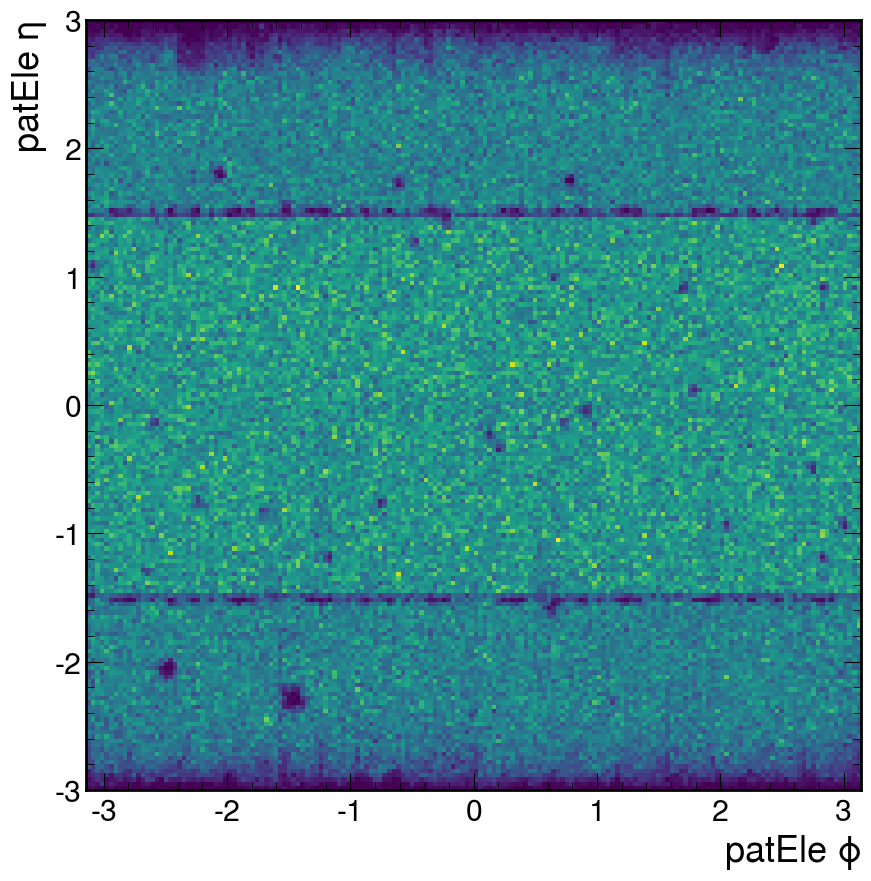

In [8]:
count_M, xbins, ybins, _ = plt.hist2d(df_2.ele_phi,df_2.ele_eta,  bins=(170,180), range=((-np.pi,np.pi),(-3,3)))
plt.xlabel("patEle $\phi$")
plt.ylabel("patEle $\eta$")

# SC matching

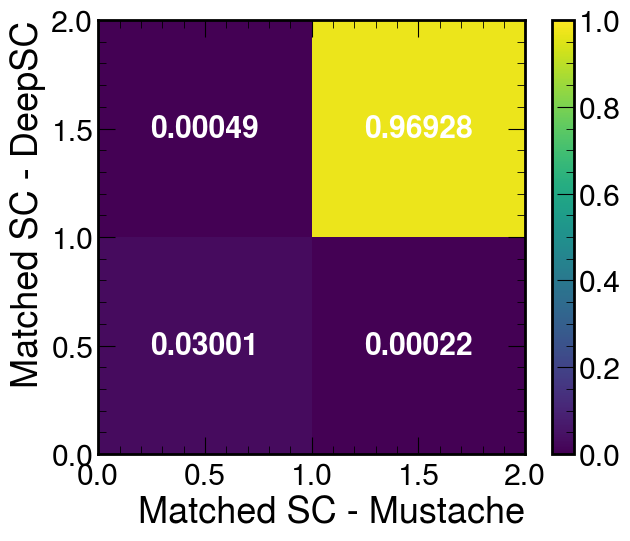

In [9]:
fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d(dfj.sc_matched_M, dfj.sc_matched_D,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched SC - Mustache")
ax.set_ylabel("Matched SC - DeepSC")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_inclusive.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_inclusive.pdf")

## Matching efficiency by eta,pt,phi

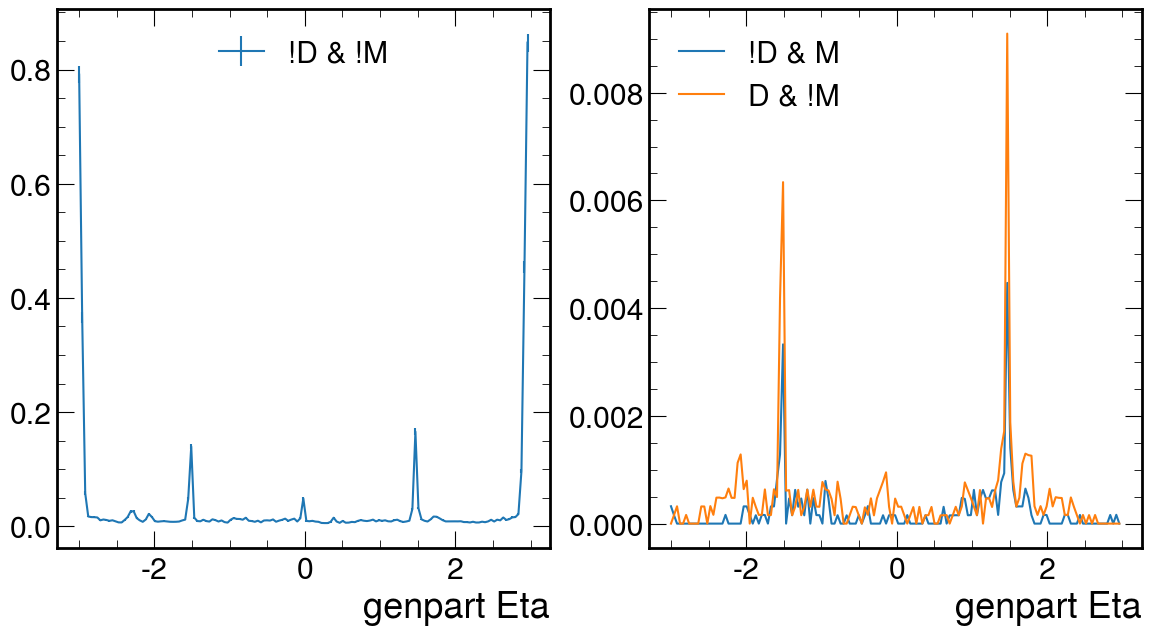

In [10]:
bins = np.linspace(-3,3, 150)

N_matched_both_pt, _ = np.histogram(dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)], 
               bins=bins )

N_matched_Donly_pt, _ = np.histogram(dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==0)], 
             bins=bins )

N_matched_Monly_pt, _= np.histogram(dfj["genpart_eta_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==1)], 
              bins=bins )

N_notmatched_pt, xbins = np.histogram(dfj["genpart_eta_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==0)], 
              bins=bins )

N_tot = N_matched_both_pt + N_matched_Donly_pt + N_matched_Monly_pt + N_notmatched_pt

fig, (ax,bx) = plt.subplots(1,2, figsize=(14,7))

err_both =  np.sqrt(  (1/N_tot)**2 * N_matched_both_pt + (N_matched_both_pt/N_tot**2)**2*N_tot)
err_notmatched =  np.sqrt(  (1/N_tot)**2 * N_notmatched_pt + (N_notmatched_pt/N_tot**2)**2*N_tot)
err_Donly =  np.sqrt(  (1/N_tot)**2 * N_matched_Donly_pt + (N_matched_Donly_pt/N_tot**2)**2*N_tot)
err_Monly =  np.sqrt(  (1/N_tot)**2 * N_matched_Monly_pt + (N_matched_Monly_pt/N_tot**2)**2*N_tot)

#ax.errorbar(xbins[:-1], N_matched_both_pt/N_tot, err_both, label="D & M")
ax.errorbar(xbins[:-1], N_notmatched_pt/N_tot, err_notmatched, label="!D & !M")
bx.plot(xbins[:-1],  N_matched_Monly_pt/N_tot,label="!D & M")
bx.plot(xbins[:-1],  N_matched_Donly_pt/N_tot,label="D & !M")
ax.set_xlabel("genpart Eta")
bx.set_xlabel("genpart Eta")

plt.savefig(f"{output_folder}/Matched_genparticle_SC_byeta.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_byeta.pdf")

ax.legend()
bx.legend()

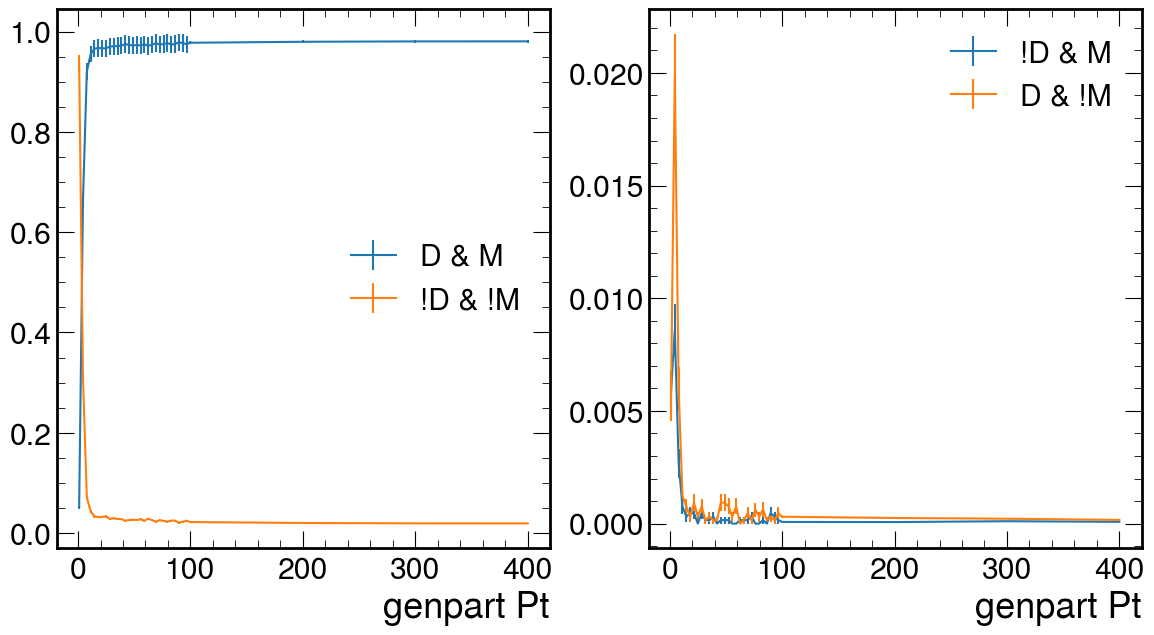

In [11]:
bins = np.concatenate([np.linspace(1, 100, 30), [200,300,400, 500]])

N_matched_both_pt, _ = np.histogram(dfj["genpart_pt_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)], 
               bins=bins )

N_matched_Donly_pt, _ = np.histogram(dfj["genpart_pt_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==0)], 
             bins=bins )

N_matched_Monly_pt, _= np.histogram(dfj["genpart_pt_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==1)], 
              bins=bins )

N_notmatched_pt, xbins = np.histogram(dfj["genpart_pt_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==0)], 
              bins=bins )

N_tot = N_matched_both_pt + N_matched_Donly_pt + N_matched_Monly_pt + N_notmatched_pt

fig, (ax,bx) = plt.subplots(1,2, figsize=(14,7))

err_both =  np.sqrt(  (1/N_tot)**2 * N_matched_both_pt + (N_matched_both_pt/N_tot**2)**2*N_tot)
err_notmatched =  np.sqrt(  (1/N_tot)**2 * N_notmatched_pt + (N_notmatched_pt/N_tot**2)**2*N_tot)
err_Donly =  np.sqrt(  (1/N_tot)**2 * N_matched_Donly_pt + (N_matched_Donly_pt/N_tot**2)**2*N_tot)
err_Monly =  np.sqrt(  (1/N_tot)**2 * N_matched_Monly_pt + (N_matched_Monly_pt/N_tot**2)**2*N_tot)

ax.errorbar(xbins[:-1], N_matched_both_pt/N_tot, err_both, label="D & M")
ax.errorbar(xbins[:-1], N_notmatched_pt/N_tot, err_notmatched, label="!D & !M")
bx.errorbar(xbins[:-1], N_matched_Monly_pt/N_tot,err_Monly, label="!D & M")
bx.errorbar(xbins[:-1], N_matched_Donly_pt/N_tot,err_Donly, label="D & !M")
ax.set_xlabel("genpart Pt")
bx.set_xlabel("genpart Pt")

plt.savefig(f"{output_folder}/Matched_genparticle_SC_bypt.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_bypt.pdf")
ax.legend()
bx.legend()

In [12]:
[f for f in dfj.columns if "ncls" in f]

['ncls_sel_M',
 'ncls_sel_true_M',
 'ncls_sel_false_M',
 'ncls_true_M',
 'ncls_tot_M',
 'ncls_missing_M',
 'ncls_sel_D',
 'ncls_sel_true_D',
 'ncls_sel_false_D',
 'ncls_true_D',
 'ncls_tot_D',
 'ncls_missing_D']

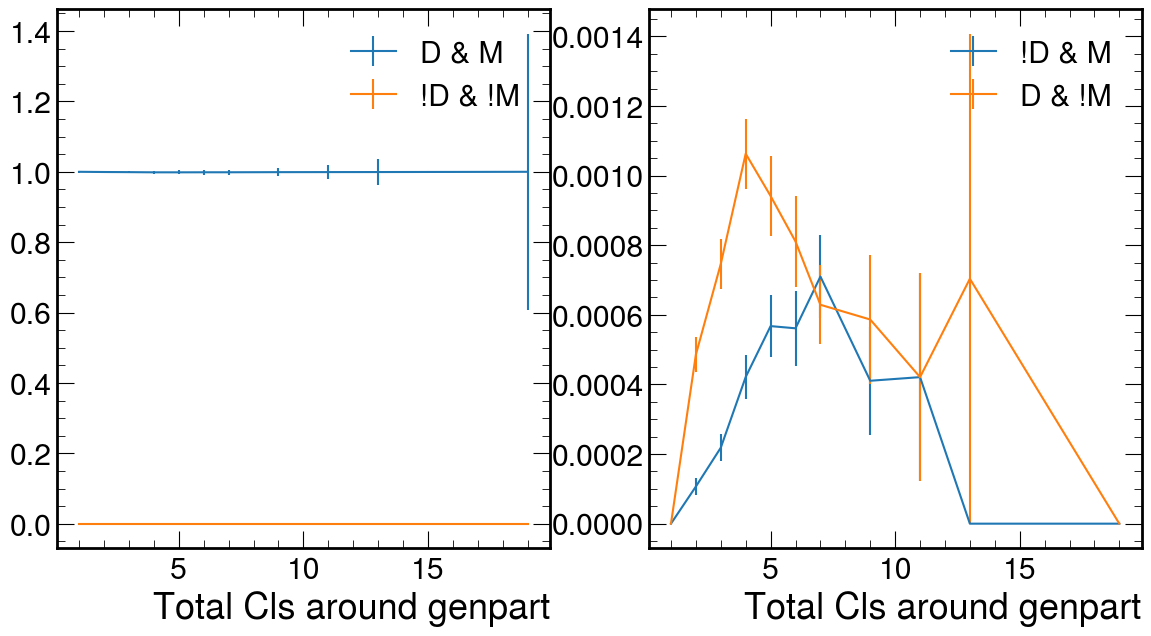

In [12]:
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,8.5,10.5,12.5,18.5,25.5]

N_matched_both_pt, _ = np.histogram(dfj["ncls_tot_M"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)], 
               bins=bins )

N_matched_Donly_pt, _ = np.histogram(dfj["ncls_tot_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==0)], 
             bins=bins )

N_matched_Monly_pt, _= np.histogram(dfj["ncls_tot_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==1)], 
              bins=bins )

N_notmatched_pt, xbins = np.histogram(dfj["ncls_tot_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==0)], 
              bins=bins )

N_tot = N_matched_both_pt + N_matched_Donly_pt + N_matched_Monly_pt + N_notmatched_pt

fig, (ax,bx) = plt.subplots(1,2, figsize=(14,7))

err_both =  np.sqrt(  (1/N_tot)**2 * N_matched_both_pt + (N_matched_both_pt/N_tot**2)**2*N_tot)
err_notmatched =  np.sqrt(  (1/N_tot)**2 * N_notmatched_pt + (N_notmatched_pt/N_tot**2)**2*N_tot)
err_Donly =  np.sqrt(  (1/N_tot)**2 * N_matched_Donly_pt + (N_matched_Donly_pt/N_tot**2)**2*N_tot)
err_Monly =  np.sqrt(  (1/N_tot)**2 * N_matched_Monly_pt + (N_matched_Monly_pt/N_tot**2)**2*N_tot)

ax.errorbar(xbins[:-1]+0.5, N_matched_both_pt/N_tot, err_both, label="D & M")
ax.errorbar(xbins[:-1]+0.5, N_notmatched_pt/N_tot, err_notmatched, label="!D & !M")
bx.errorbar(xbins[:-1]+0.5, N_matched_Monly_pt/N_tot,err_Monly, label="!D & M")
bx.errorbar(xbins[:-1]+0.5, N_matched_Donly_pt/N_tot,err_Donly, label="D & !M")
ax.set_xlabel("Total Cls around genpart")
bx.set_xlabel("Total Cls around genpart")


plt.savefig(f"{output_folder}/Matched_genparticle_SC_nclstot.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_nclstot.pdf")
ax.legend()
bx.legend()

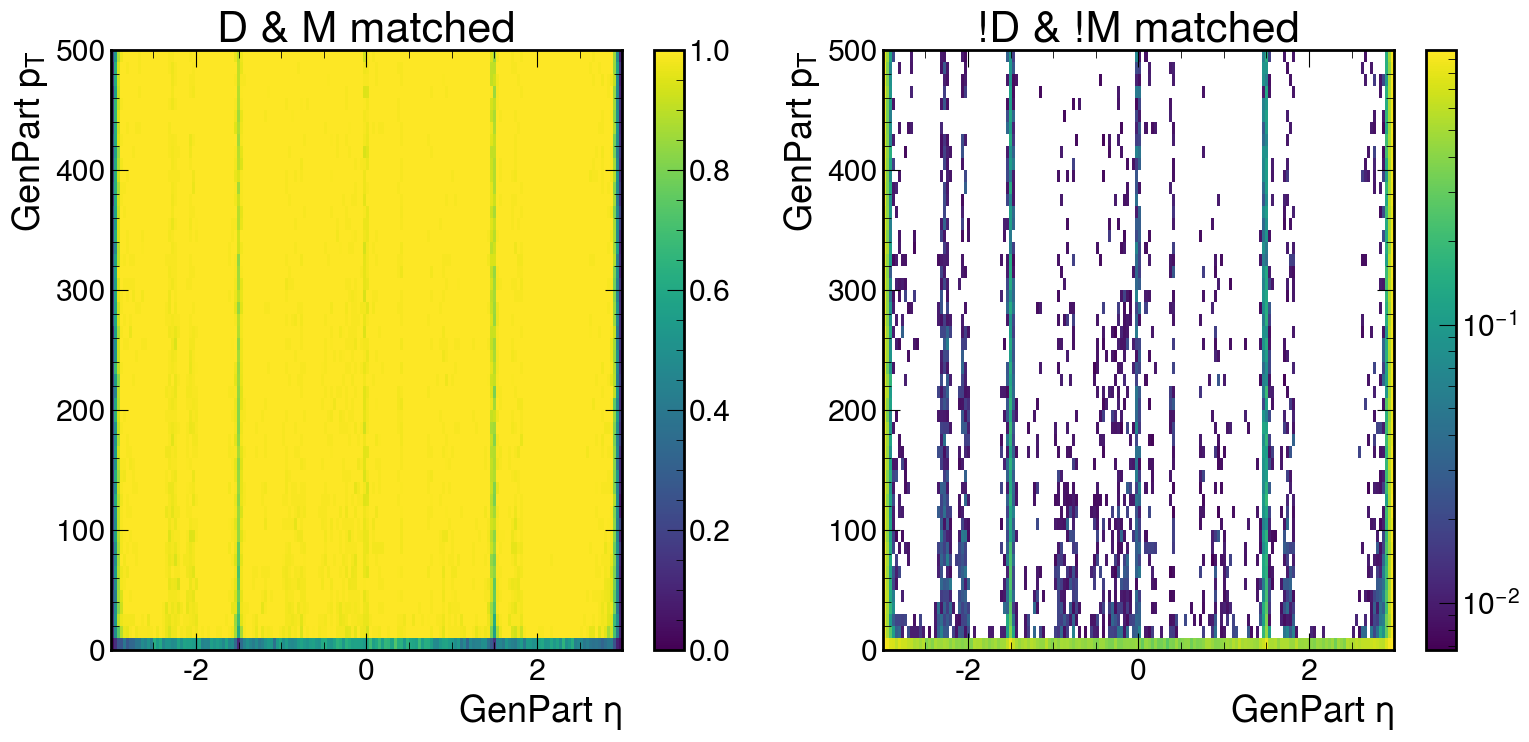

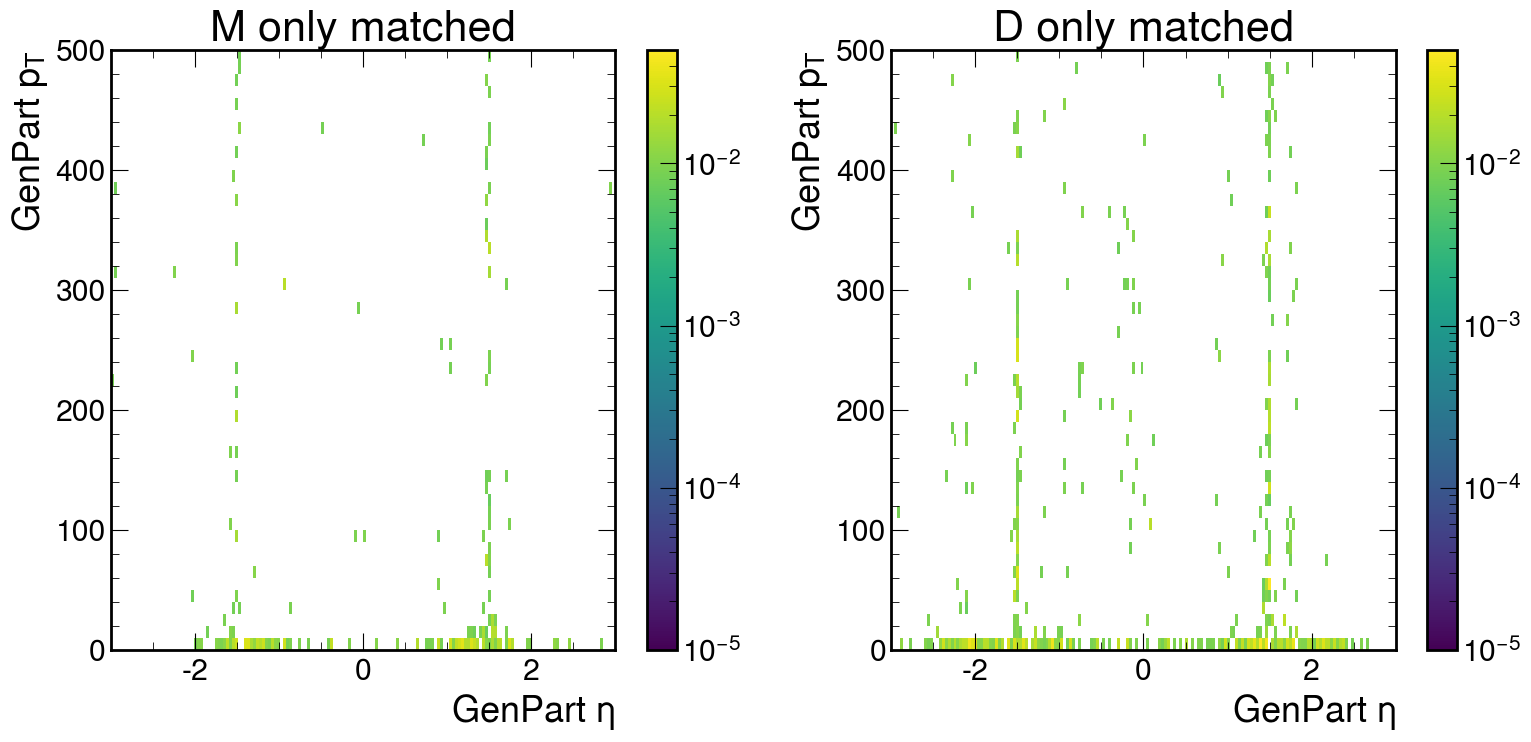

In [13]:
bins = (170, 50)
rrange = ((-3,3),(0,500))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)],
                                            dfj["genpart_pt_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)],
                                             dfj["genpart_pt_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)], 
                                            df_join["genpart_pt_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)], 
                                                  df_join["genpart_pt_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)], 
             bins=bins, range=rrange )

N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())

ax1.set_xlabel("GenPart $\eta$")
ax2.set_xlabel("GenPart $\eta$")
ax1.set_ylabel("GenPart $p_T$")
ax2.set_ylabel("GenPart $p_T$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_SC_etapt_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etapt_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_xlabel("GenPart $\eta$")
ax4.set_xlabel("GenPart $\eta$")

ax3.set_ylabel("GenPart $p_T$")
ax4.set_ylabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etapt_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etapt_2.pdf")

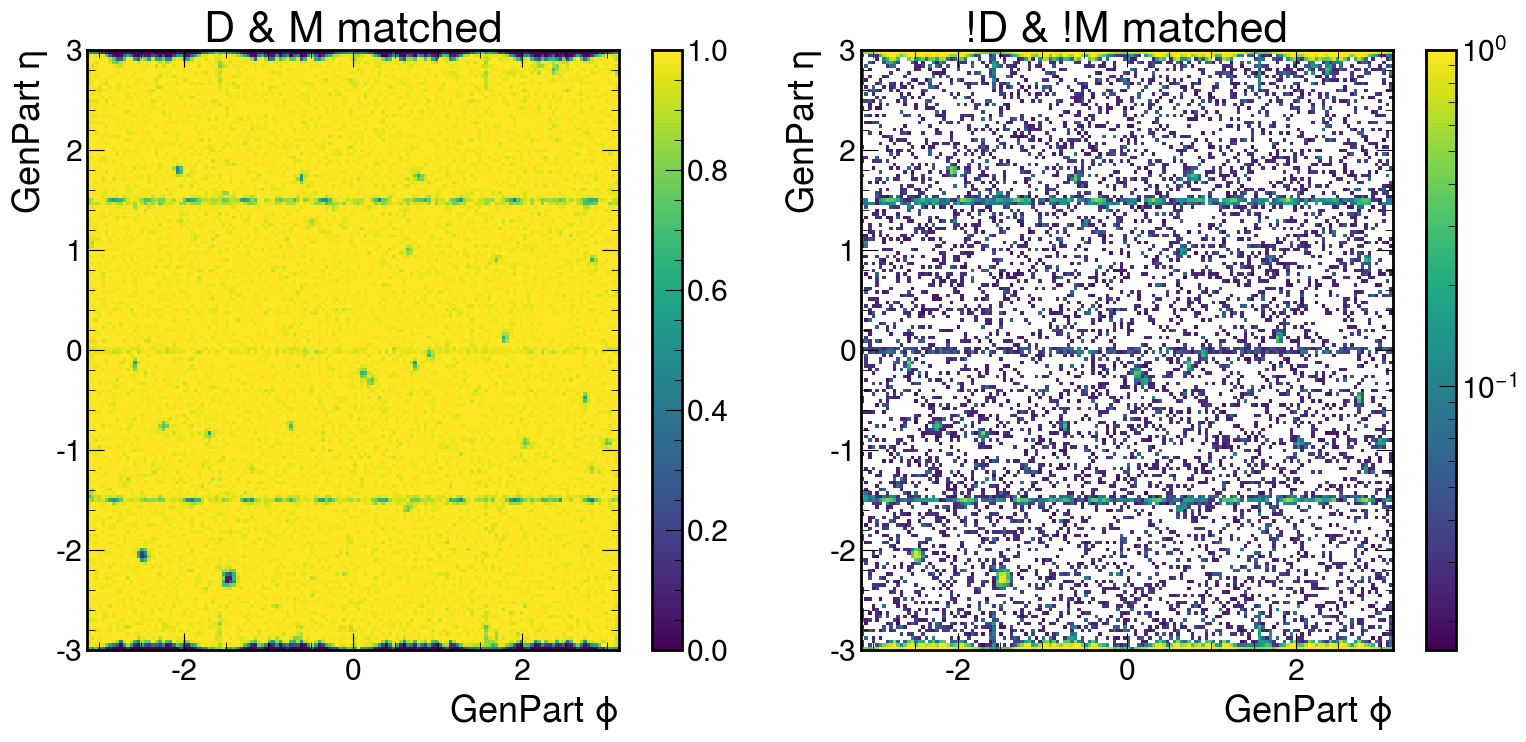

In [14]:
bins = (150, 170)
rrange = ((-np.pi, np.pi), (-3,3))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)],
                                            dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)],
                                             dfj["genpart_eta_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(df_join["genpart_phi_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)], 
                                            df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(df_join["genpart_phi_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)], 
                                                  df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)], 
             bins=bins, range=rrange )

N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_ylabel("GenPart $\eta$")
ax4.set_ylabel("GenPart $\eta$")
ax3.set_xlabel("GenPart $p_T$")
ax4.set_xlabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_2.pdf")

In [16]:
bins = (150, 170)
rrange = ((-np.pi, np.pi), (-3,3))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>10)],
                                            dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>10)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)&(dfj.genpart_et_D>10)],
                                             dfj["genpart_eta_D"][(df_join.sc_matched_D==1)&(df_join.sc_matched_M==0)&(dfj.genpart_et_D>10)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(df_join["genpart_phi_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)&(dfj.genpart_et_D>10)], 
                                            df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==1)&(dfj.genpart_et_D>10)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(df_join["genpart_phi_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)&(dfj.genpart_et_D>10)], 
                                                  df_join["genpart_eta_M"][(df_join.sc_matched_D==0)&(df_join.sc_matched_M==0)&(dfj.genpart_et_D>10)], 
             bins=bins, range=rrange )

N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartgt10_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartgt10_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_ylabel("GenPart $\eta$")
ax4.set_ylabel("GenPart $\eta$")
ax3.set_xlabel("GenPart $p_T$")
ax4.set_xlabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartgt10_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartgt10_2.pdf")

# Efficiency by bins of genpart et

/tmp/ipykernel_7187/3703987630.py:33: RuntimeWarning: invalid value encountered in divide
  c2 = ax.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())


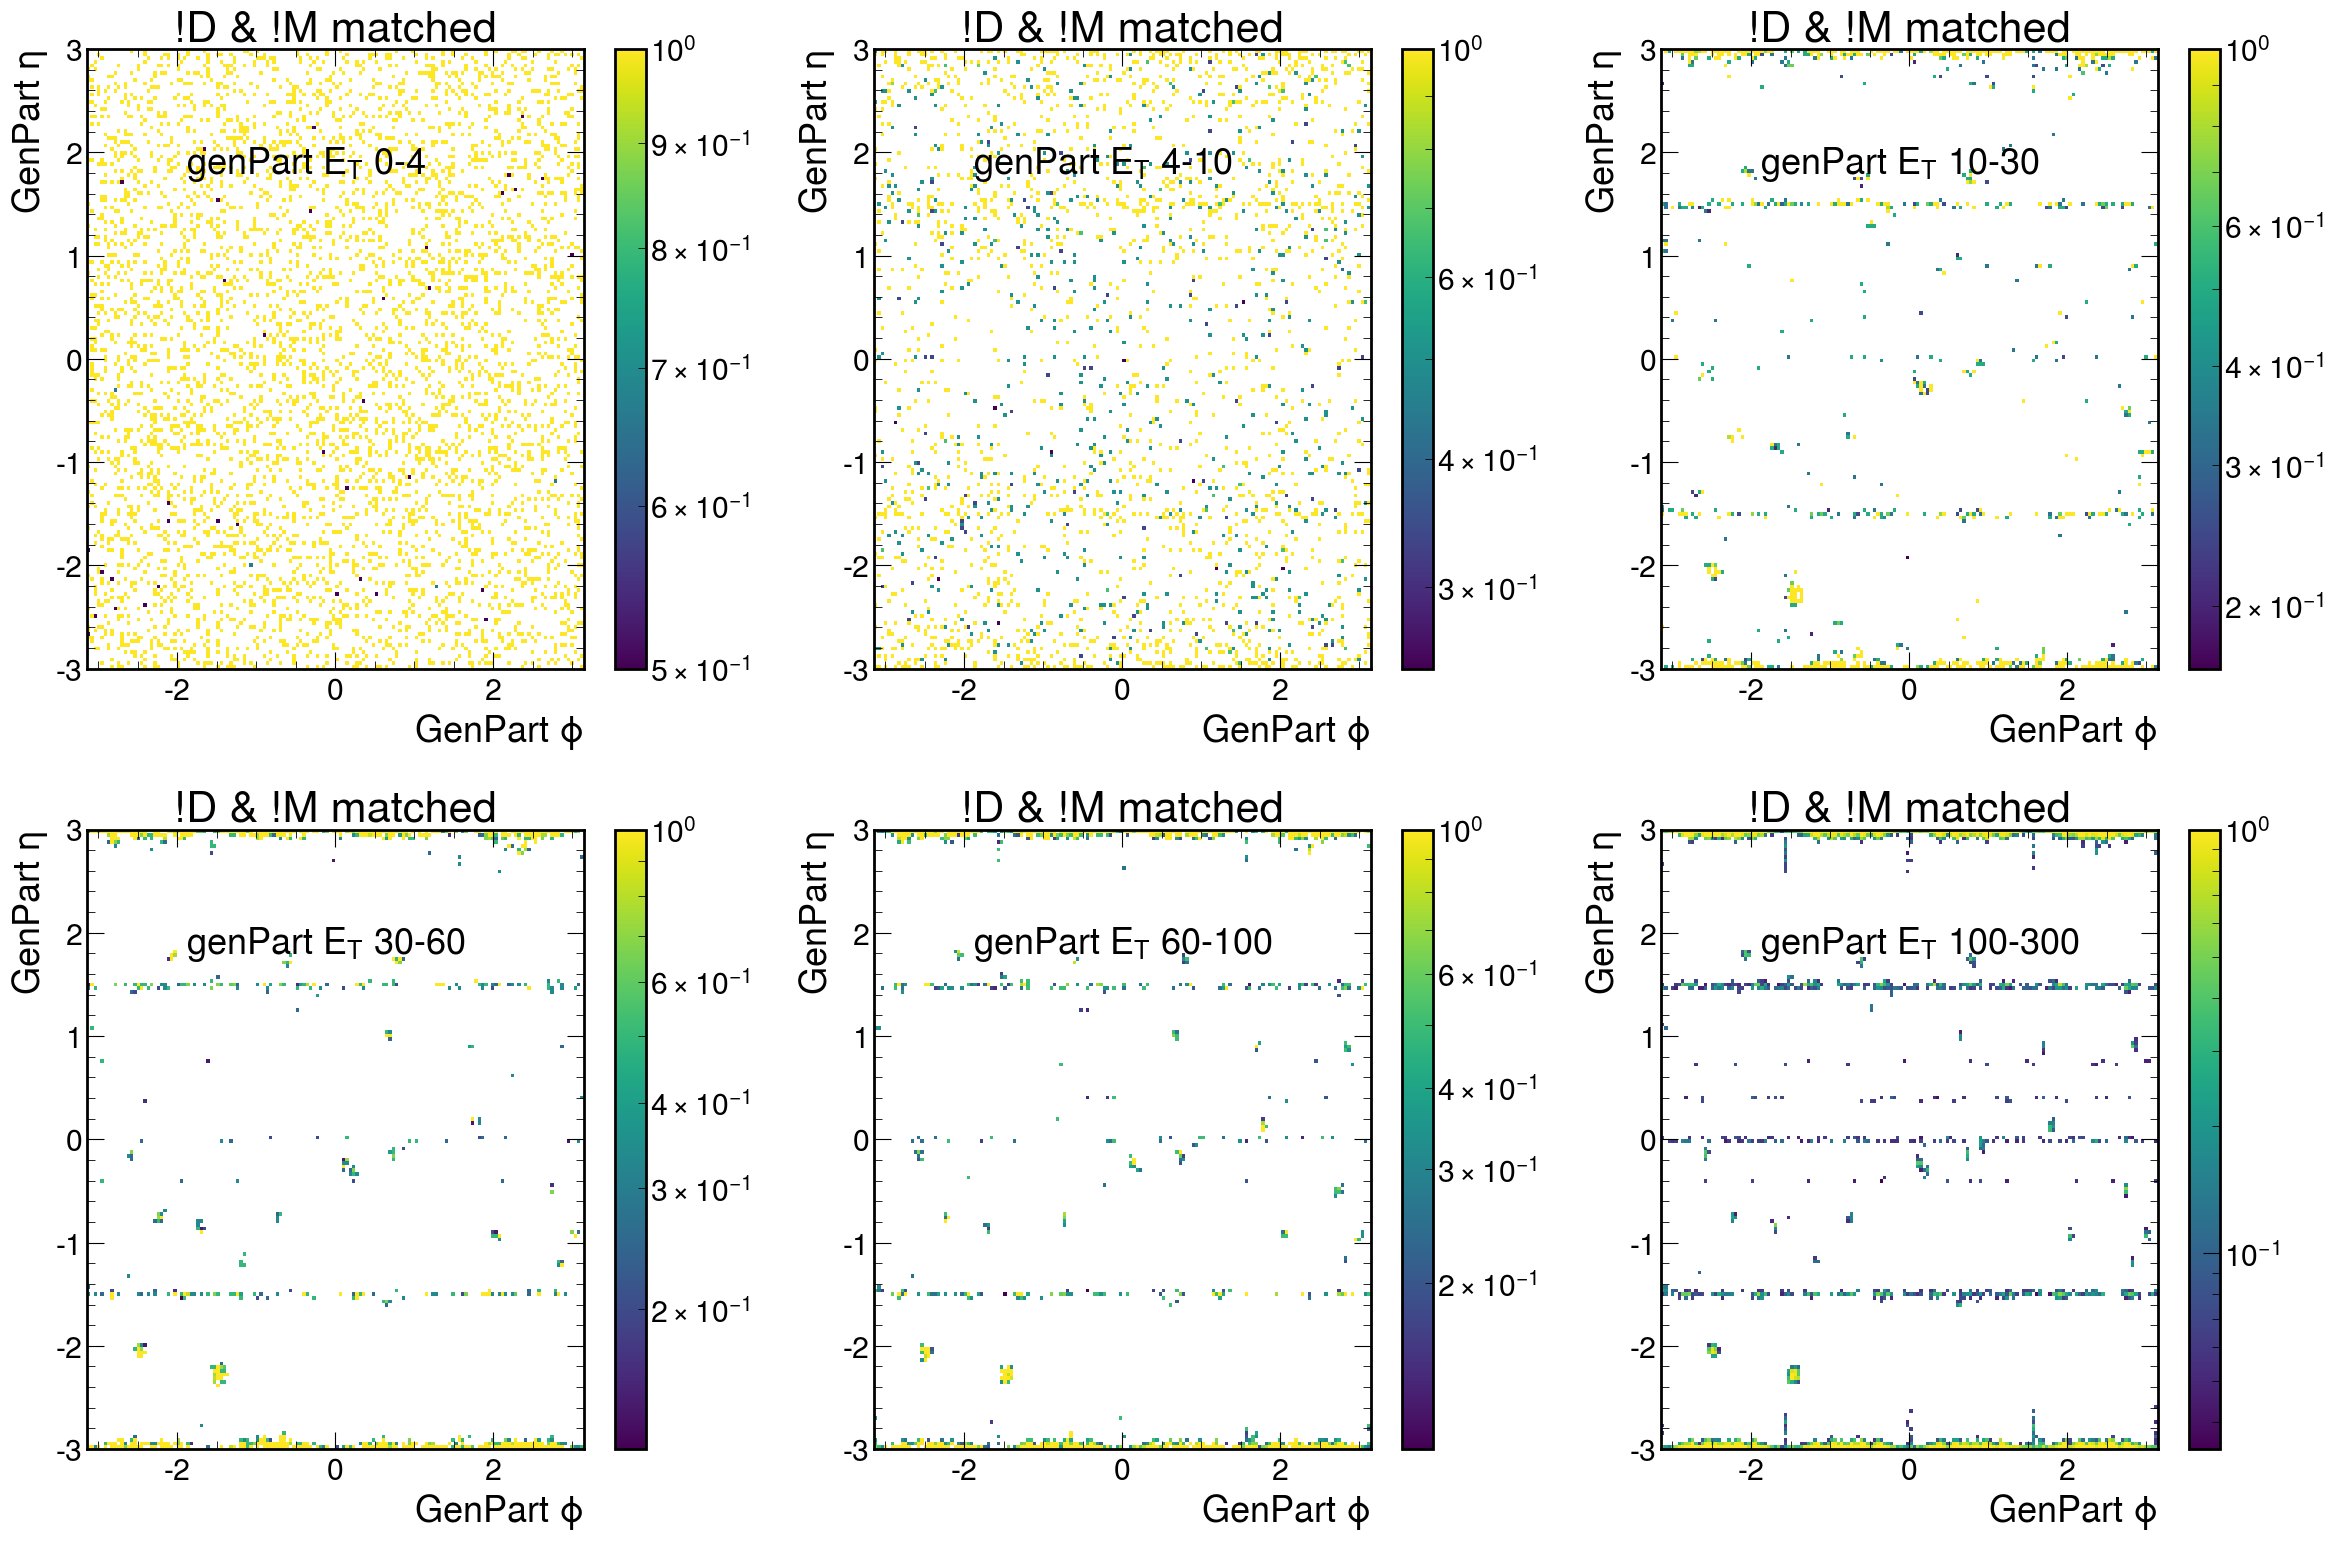

In [17]:
bins = (150, 170)
et_bins = [0, 4, 10, 30, 60, 100, 300]
rrange = ((-np.pi, np.pi), (-3,3))

  
fig, axs = plt.subplots(2,3, figsize=(24,16))
    

for ibin in range(len(et_bins)-1):
    N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])],
                                                dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])],
                   bins=bins, range=rrange )
    
    N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==0)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])],
                                                 dfj["genpart_eta_D"][(dfj.sc_matched_D==1)&(dfj.sc_matched_M==0)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])],
                bins=bins, range=rrange  )
    
    N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_phi_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])], 
                                                dfj["genpart_eta_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==1)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])], 
                bins=bins, range=rrange )
    
    N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_phi_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==0)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])], 
                                                      dfj["genpart_eta_M"][(dfj.sc_matched_D==0)&(dfj.sc_matched_M==0)&(dfj.genpart_et_D>=et_bins[ibin])&(dfj.genpart_et_D<et_bins[ibin+1])], 
                 bins=bins, range=rrange )
    
    N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

        
    X, Y = np.meshgrid(xbins, ybins)

    ax = axs[ibin//3, ibin%3]
  
    c2 = ax.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())
    
    ax.set_ylabel("GenPart $\eta$")
    ax.set_xlabel("GenPart $\phi$")
    ax.set_title(f"!D & !M matched")
    ax.text(0.2, 0.8, f"genPart $E_T$ {et_bins[ibin]}-{et_bins[ibin+1]}", transform=ax.transAxes)
    plt.colorbar(c2, ax=ax)
plt.tight_layout()
    
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartscan.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_etaphi_genpartscan.pdf")



## Energy and number of clusters comparison

/tmp/ipykernel_7187/1368916839.py:13: RuntimeWarning: invalid value encountered in divide
  a = A/s


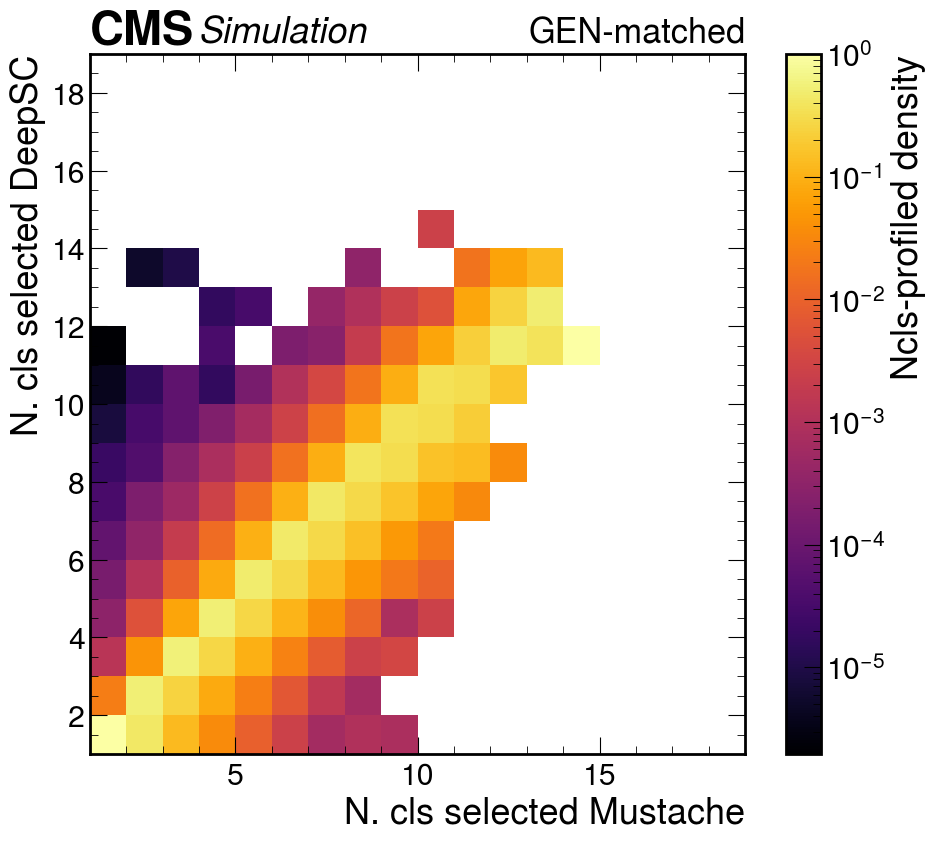

In [18]:
xbins = list(range(1, 20))
ybins =  list(range(1, 20))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(10,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.ncls_sel_D, bins=(xbins, ybins ))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_ylabel("N. cls selected DeepSC")
ax.set_xlabel("N. cls selected Mustache")

hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls.pdf")

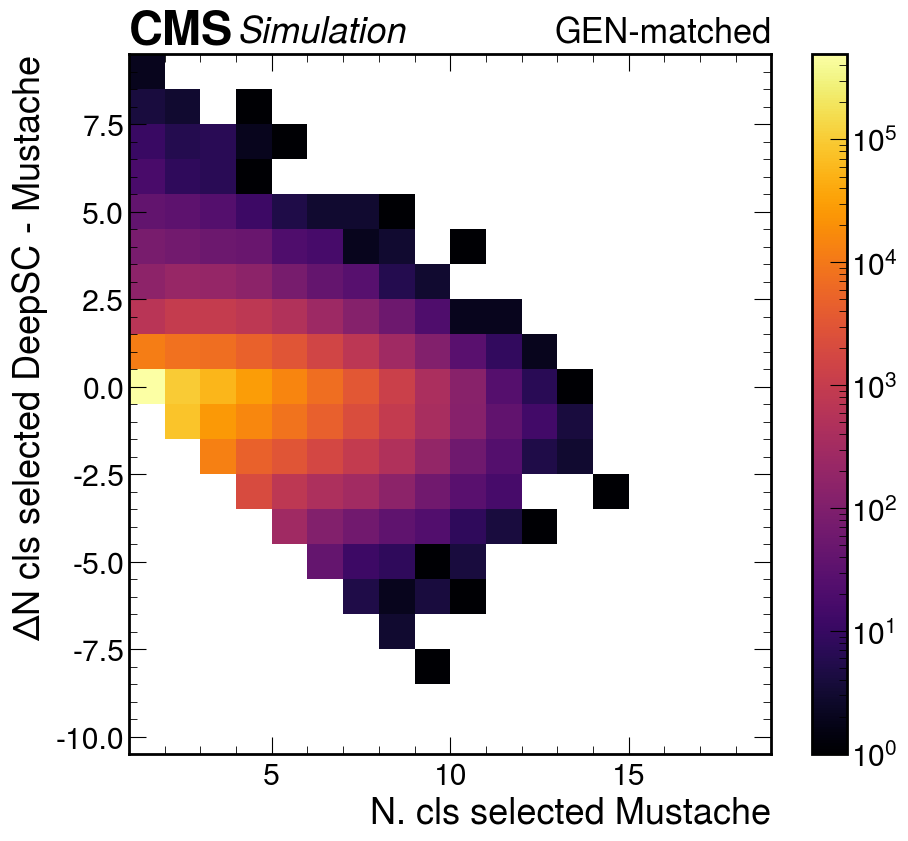

In [20]:
xbins = list(range(1, 20))
ybins =  [f+0.5 for f in range(-11, 10)]

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(10,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.ncls_sel_D-dfmatched_sc.ncls_sel_M, bins=(xbins, ybins ))

#s = np.expand_dims(np.sum(A, axis=-1), axis=1)
#a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, cmap="inferno",norm=LogNorm())

fig.colorbar(I, ax=ax)
ax.set_xlabel("N. cls selected Mustache")
ax.set_ylabel("$\Delta N$ cls selected DeepSC - Mustache")

hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls_diff.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls_diff.pdf")

/tmp/ipykernel_7187/306725357.py:13: RuntimeWarning: invalid value encountered in divide
  a = A/s


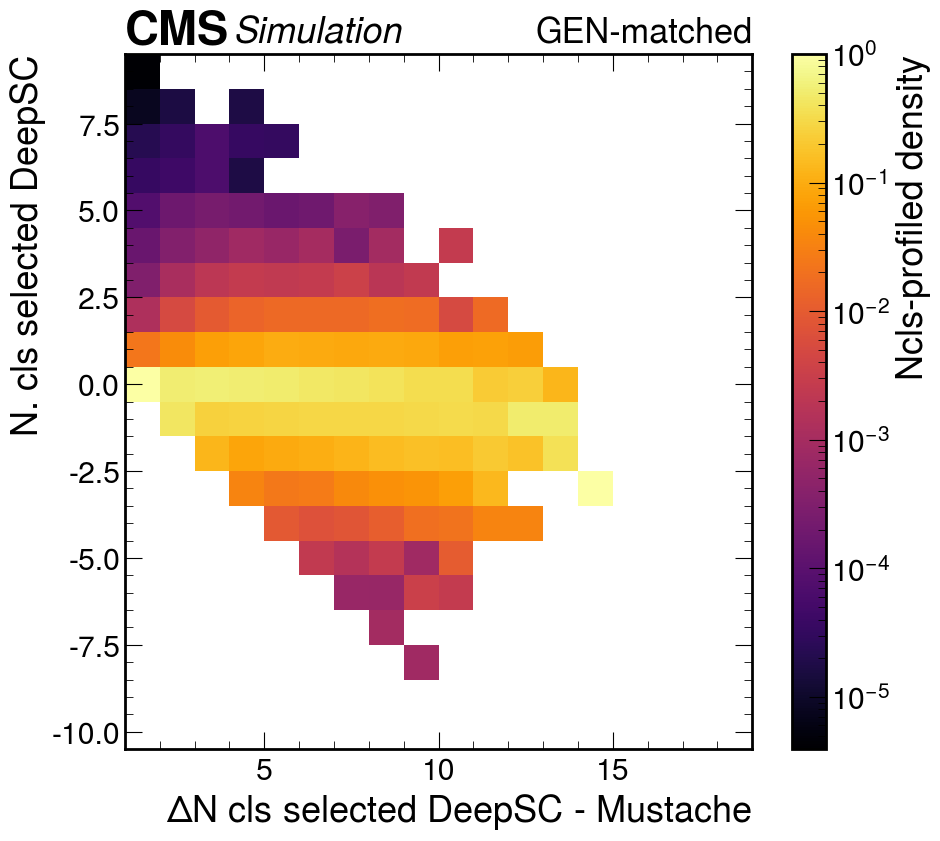

In [21]:
xbins = list(range(1, 20))
ybins =  [f+0.5 for f in range(-11, 10)]

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(10,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.ncls_sel_D-dfmatched_sc.ncls_sel_M, bins=(xbins, ybins ))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_ylabel("N. cls selected DeepSC")
ax.set_xlabel("$\Delta N$ cls selected DeepSC - Mustache")

hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls_diff_profiled.png")
plt.savefig(f"{output_folder}/Matched_genparticle_SC_ncls_diff_profiled.pdf")

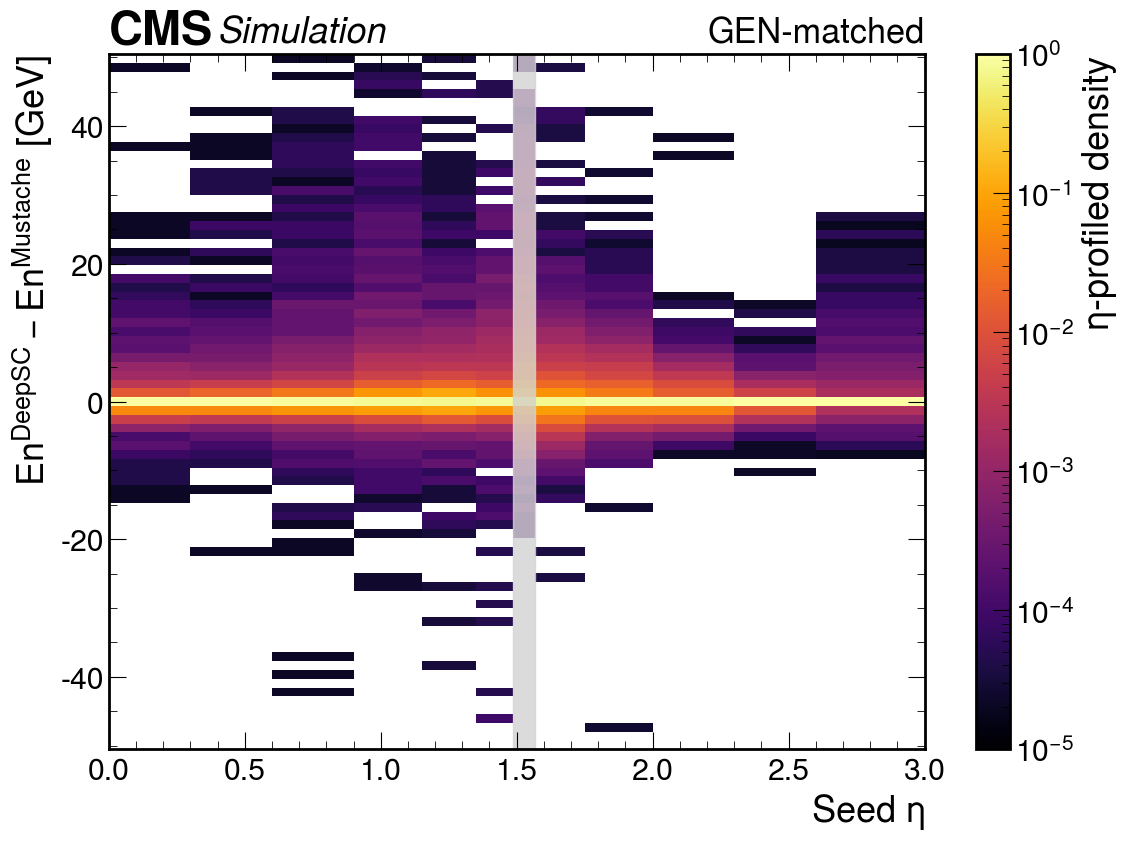

In [22]:
etas =  [0, 0.3,0.6, 0.9, 1.15, 1.35, 1.485, 1.566, 1.75,2.,2.3,2.6,3]
xbins = np.linspace(-50.5,50.5,80)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.seed_eta_M, 
                                  dfmatched_sc.et_sc_calib_D - dfmatched_sc.et_sc_calib_M,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

ax.fill_between([1.485, 1.566], [-50.5,-50.5],[50.5,50.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="$\eta$-profiled density")   
ax.set_ylabel("$En^{DeepSC} - En^{Mustache}$ [GeV]")
ax.set_xlabel("Seed $\eta$")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_etaM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_etaM.pdf")

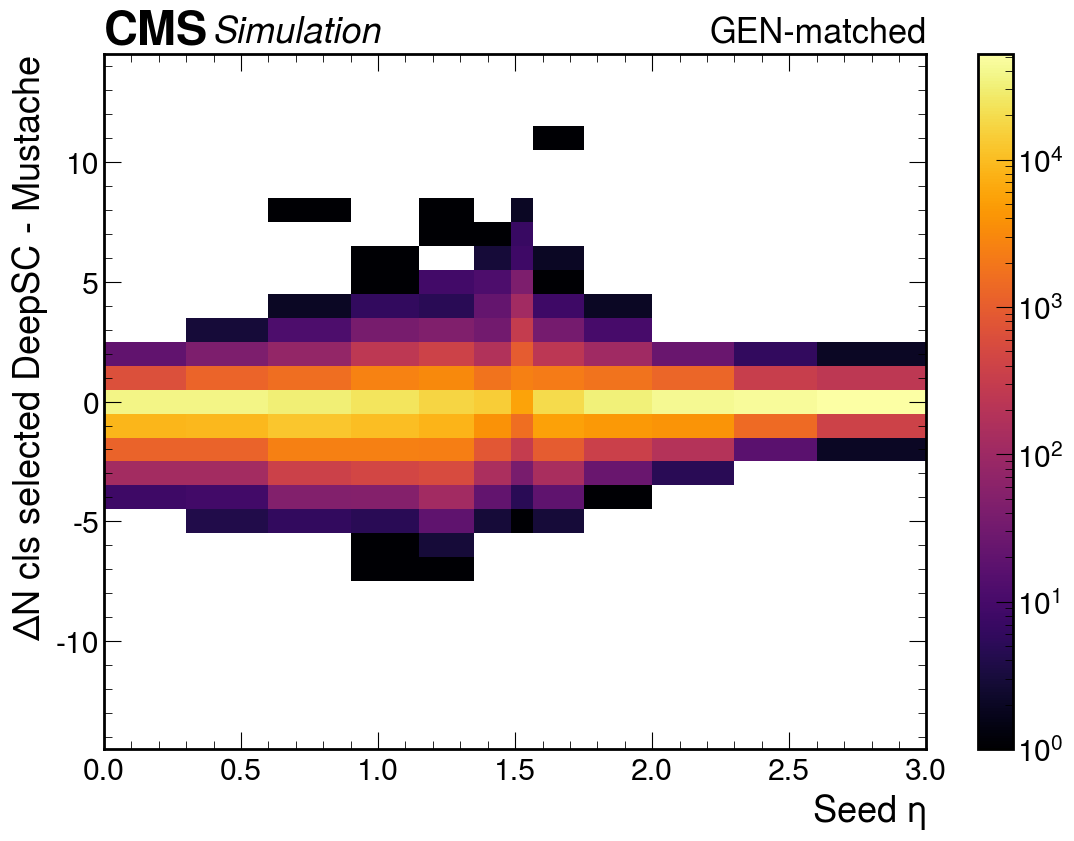

In [23]:
etas =  [0, 0.3,0.6, 0.9, 1.15, 1.35, 1.485, 1.566, 1.75,2.,2.3,2.6,3]
ybins = np.linspace(-14.5,14.5,30)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.seed_eta_M, 
                                  dfmatched_sc.ncls_sel_D - dfmatched_sc.ncls_sel_M,
                                  bins=(etas, ybins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-14.5,14.5],[-14.5,14.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, )   
ax.set_ylabel("$\Delta N$ cls selected DeepSC - Mustache")
ax.set_xlabel("Seed $\eta$")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_etaM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_etaM.pdf")

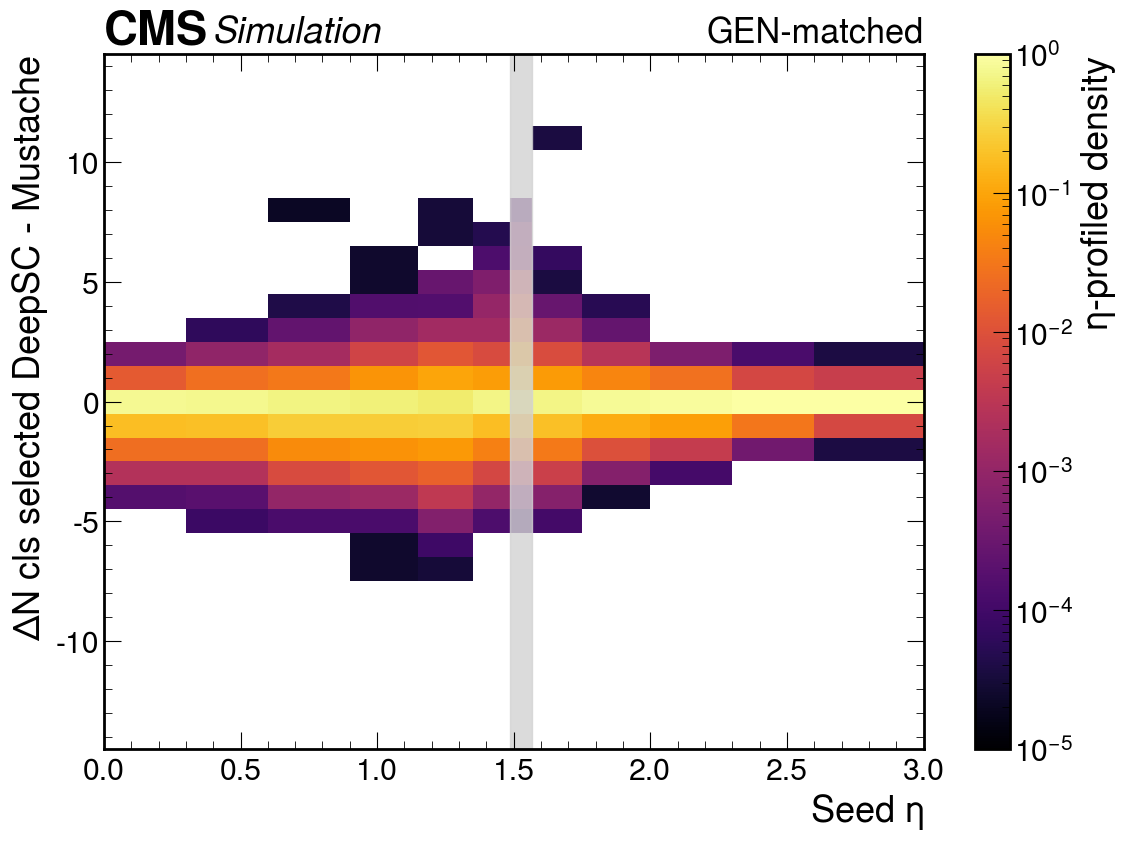

In [24]:
etas =  [0, 0.3,0.6, 0.9, 1.15, 1.35, 1.485, 1.566, 1.75,2.,2.3,2.6,3]
ybins = np.linspace(-14.5,14.5,30)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.seed_eta_M, 
                                  dfmatched_sc.ncls_sel_D - dfmatched_sc.ncls_sel_M,
                                  bins=(etas, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

ax.fill_between([1.485, 1.566], [-14.5,-14.5],[14.5,14.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="$\eta$-profiled density")   
ax.set_ylabel("$\Delta N$ cls selected DeepSC - Mustache")
ax.set_xlabel("Seed $\eta$")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_profiled_etaM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_profiled_etaM.pdf")

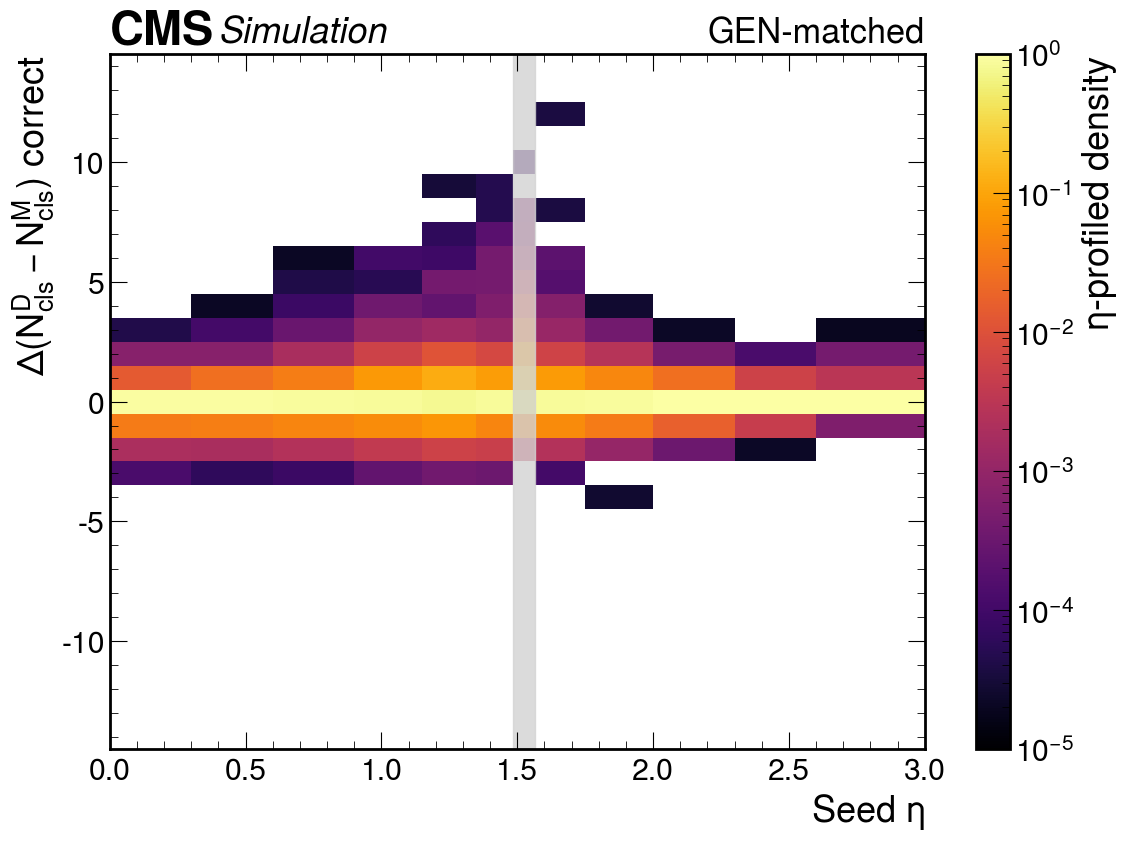

In [25]:
etas =  [0, 0.3,0.6, 0.9, 1.15, 1.35, 1.485, 1.566, 1.75,2.,2.3,2.6,3]
ybins = np.linspace(-14.5,14.5,30)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.seed_eta_M, 
                                  dfmatched_sc.ncls_sel_true_D - dfmatched_sc.ncls_sel_true_M,
                                  bins=(etas, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

ax.fill_between([1.485, 1.566], [-14.5,-14.5],[14.5,14.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="$\eta$-profiled density")   
ax.set_ylabel("$\Delta(N_{cls}^D - N_{cls}^M)$ correct")
ax.set_xlabel("Seed $\eta$")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_true_etaM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_true_etaM.pdf")

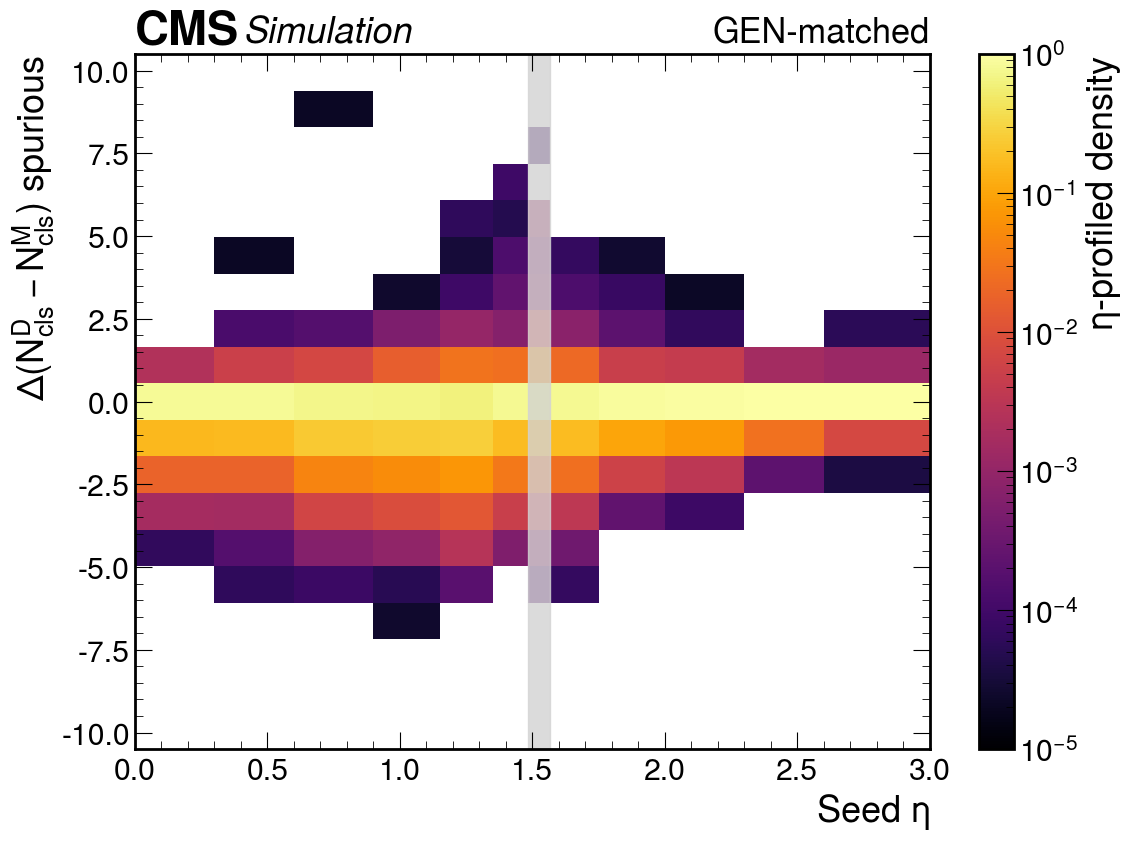

In [26]:
etas =  [0, 0.3,0.6, 0.9, 1.15, 1.35, 1.485, 1.566, 1.75,2.,2.3,2.6,3]
ybins = np.linspace(-10.5,10.5,20)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.seed_eta_M, 
                                  dfmatched_sc.ncls_sel_false_D - dfmatched_sc.ncls_sel_false_M,
                                  bins=(etas, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

ax.fill_between([1.485, 1.566], [-10.5,-10.5],[10.5,10.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="$\eta$-profiled density")   
ax.set_ylabel("$\Delta(N_{cls}^D - N_{cls}^M)$ spurious")
ax.set_xlabel("Seed $\eta$")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_false_etaM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dncls_false_etaM.pdf")

/tmp/ipykernel_7187/2836416979.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


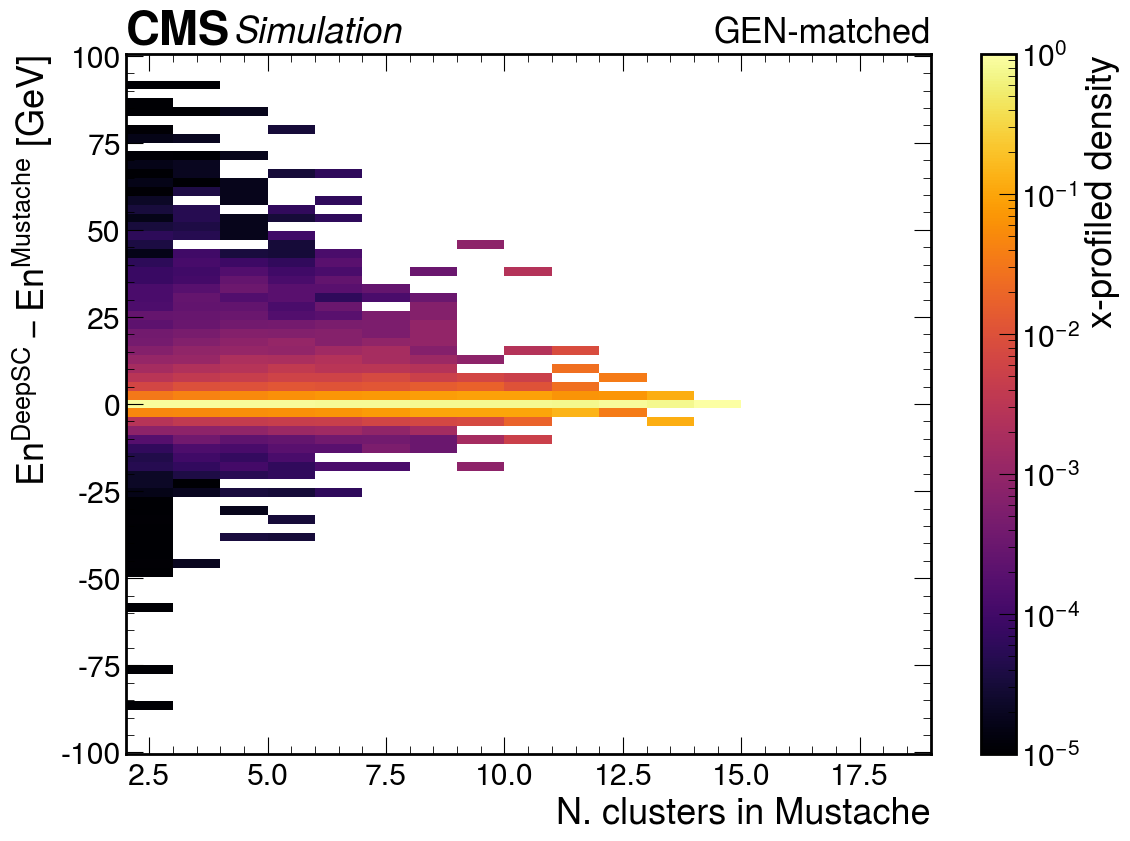

In [27]:
etas =  np.arange(2, 20)
xbins = np.linspace(-100.5,100.5,80)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.et_sc_calib_D - dfmatched_sc.et_sc_calib_M,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("$En^{DeepSC} - En^{Mustache}$ [GeV]")
ax.set_xlabel("N. clusters in Mustache")

hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_nclsM.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_nclsM.pdf")

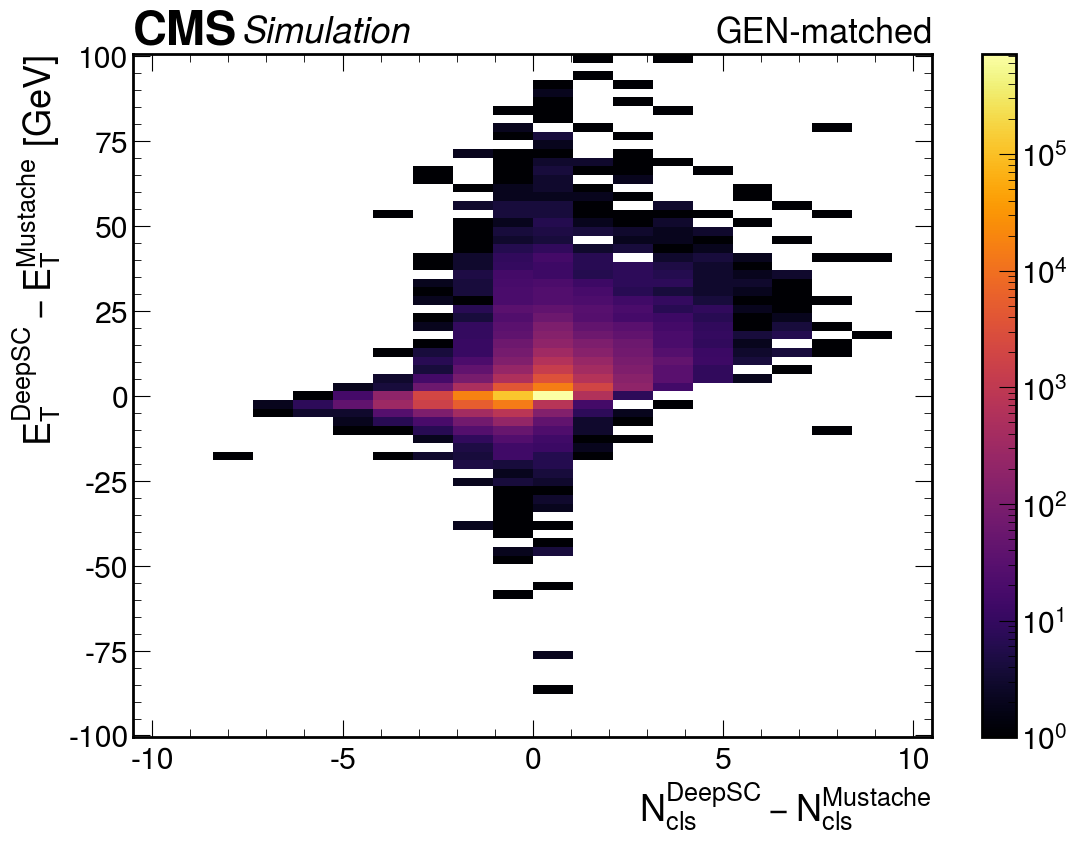

In [28]:
etas =  np.linspace(-10.5,10.5,21)
xbins = np.linspace(-100.5,100.5,80)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.et_sc_calib_D - dfmatched_sc.et_sc_calib_M,
                                  bins=(etas, xbins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax)   
ax.set_ylabel("$E_T^{DeepSC} - E_T^{Mustache}$ [GeV]")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_dncls_noprof.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_dncls_noprof.pdf")

/tmp/ipykernel_7187/3867943624.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


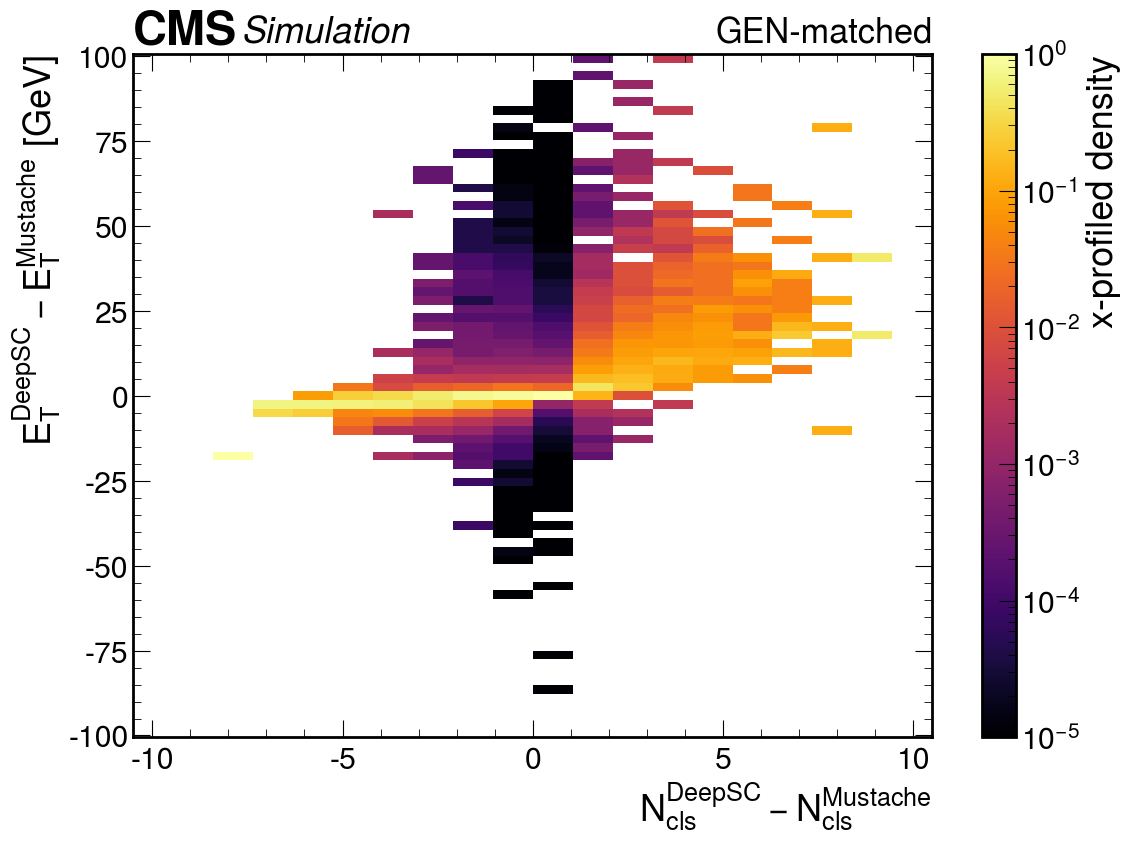

In [29]:
etas =  np.linspace(-10.5,10.5,21)
xbins = np.linspace(-100.5,100.5,80)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                  dfmatched_sc.et_sc_calib_D - dfmatched_sc.et_sc_calib_M,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("$E_T^{DeepSC} - E_T^{Mustache}$ [GeV]")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_dncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergy_dncls.pdf")

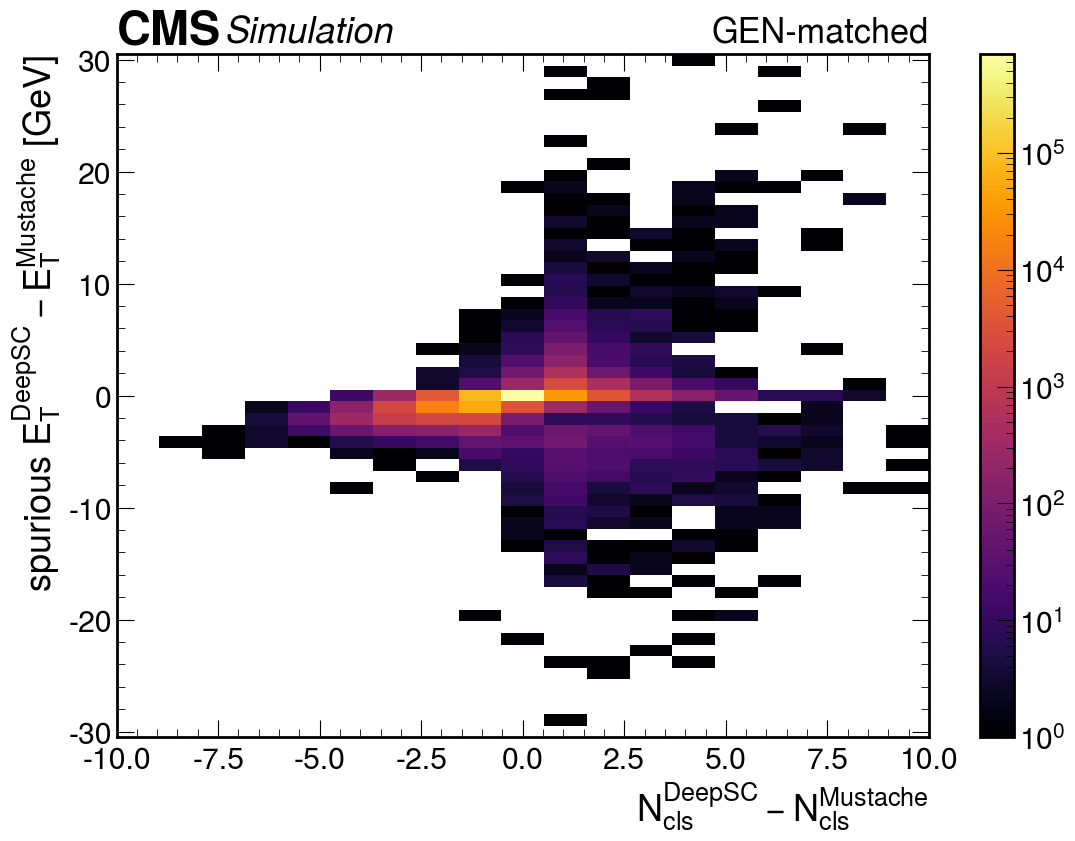

In [30]:
xbins =  np.linspace(-10,10,20)
ybins = np.linspace(-30.5,30.5,60)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                 dfmatched_sc.sel_false_energy_cls_D/np.cosh(dfmatched_sc.seed_eta_D) - dfmatched_sc.sel_false_energy_cls_M/np.cosh(dfmatched_sc.seed_eta_M),
                                  bins=(xbins, ybins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno", )

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax)   
ax.set_ylabel("spurious $E_T^{DeepSC} - E_T^{Mustache}$ [GeV]")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergySpurious_dncls_noprof.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergySpurious_dncls_noprof.pdf")

/tmp/ipykernel_7187/1601332520.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


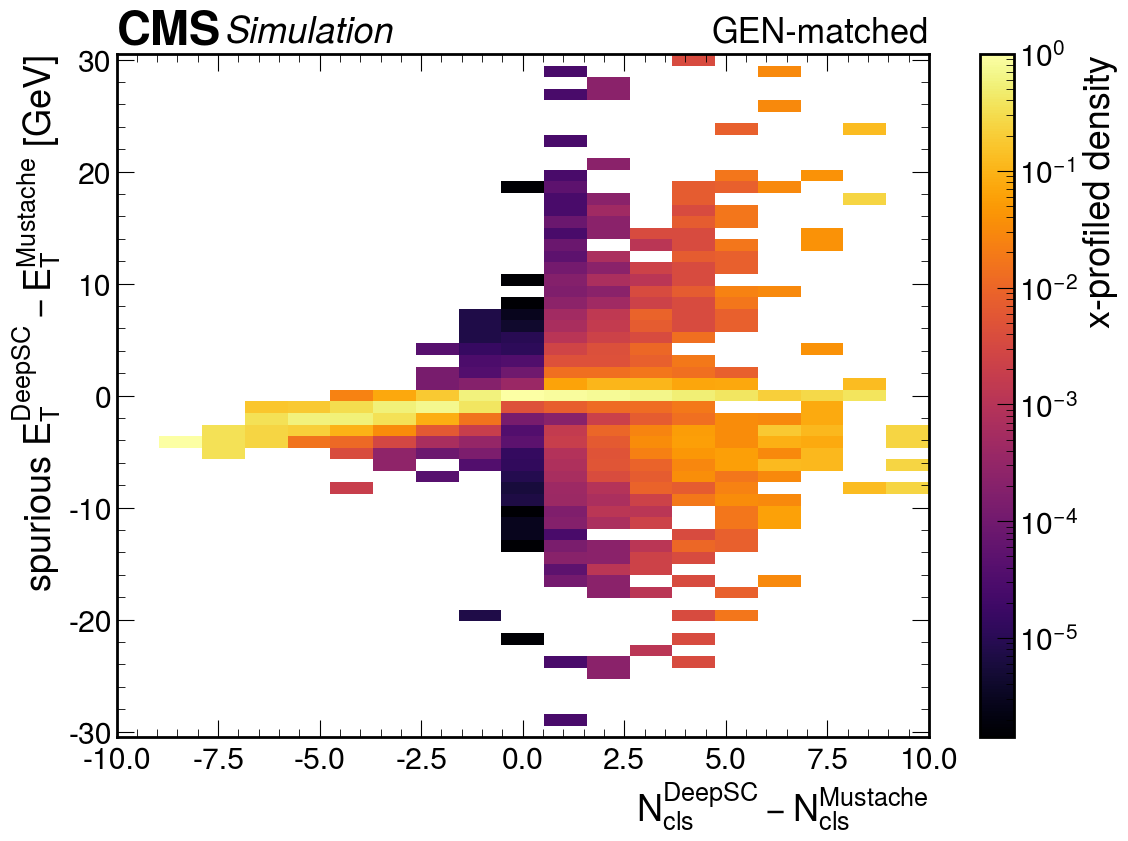

In [31]:
xbins =  np.linspace(-10,10,20)
ybins = np.linspace(-30.5,30.5,60)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                 dfmatched_sc.sel_false_energy_cls_D/np.cosh(dfmatched_sc.seed_eta_D) - dfmatched_sc.sel_false_energy_cls_M/np.cosh(dfmatched_sc.seed_eta_M),
                                  bins=(xbins, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X , Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno", )

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("spurious $E_T^{DeepSC} - E_T^{Mustache}$ [GeV]")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergySpurious_dncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergySpurious_dncls.pdf")

In [32]:
xbins =  np.linspace(-10,10,20)
ybins = np.linspace(-30.5,30.5,60)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                 dfmatched_sc.sel_false_energy_cls_D - dfmatched_sc.sel_false_energy_cls_M,
                                  bins=(xbins, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X , Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno", )

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("spurious $E^{DeepSC} - E^{Mustache}$ [GeV]")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnSpurious_dncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnSpurious_dncls.pdf")

/tmp/ipykernel_7187/3802198761.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


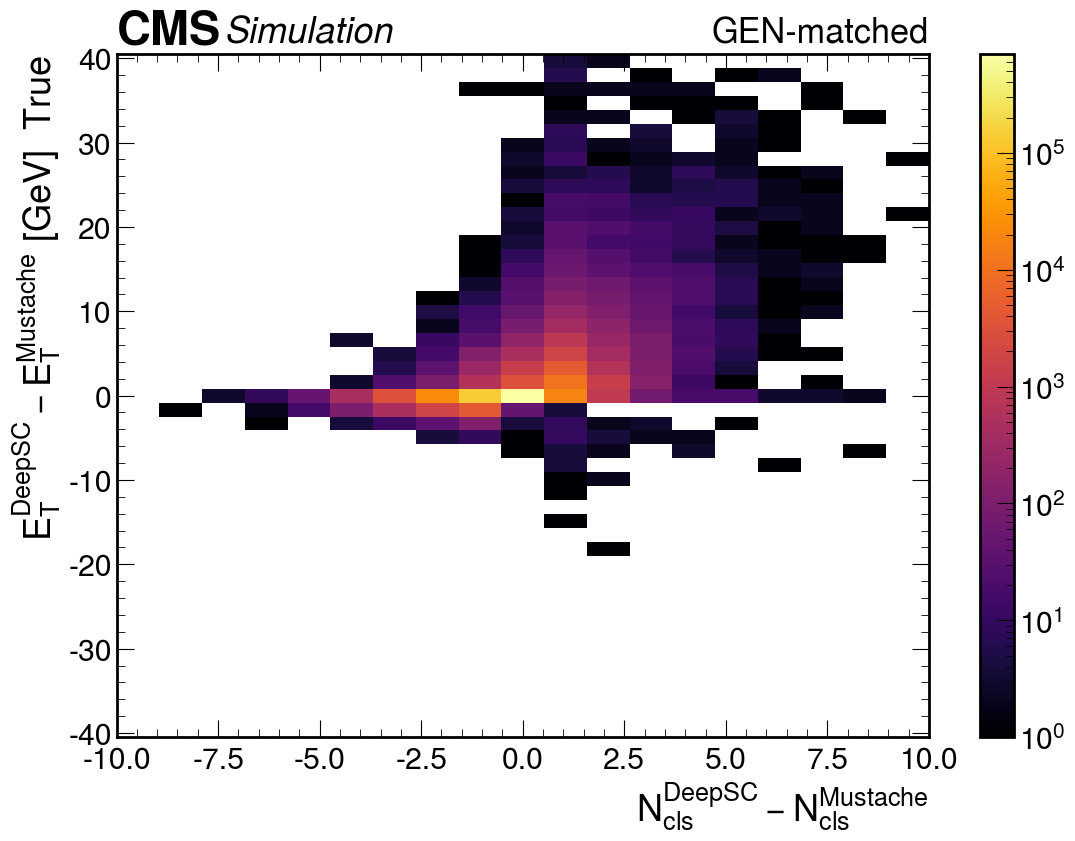

In [33]:
xbins =  np.linspace(-10,10,20)
ybins = np.linspace(-40.5,40.5,50)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                 dfmatched_sc.sel_true_energy_cls_D/np.cosh(dfmatched_sc.seed_eta_D) - dfmatched_sc.sel_true_energy_cls_M/np.cosh(dfmatched_sc.seed_eta_M),
                                  bins=(xbins, ybins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno", )

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax)   
ax.set_ylabel("$E_T^{DeepSC} - E_T^{Mustache}$ [GeV]  True")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergyCorrect_dncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergyCorrect_dncls.pdf")

In [34]:
xbins =  np.linspace(-10,10,20)
ybins = np.linspace(-40.5,40.5,50)

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_D- dfmatched_sc.ncls_sel_M, 
                                 dfmatched_sc.sel_true_energy_cls_D/np.cosh(dfmatched_sc.seed_eta_D) - dfmatched_sc.sel_true_energy_cls_M/np.cosh(dfmatched_sc.seed_eta_M),
                                  bins=(xbins, ybins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno", )

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("$E_T^{DeepSC} - E_T^{Mustache}$ [GeV]  True")
ax.set_xlabel("$N_{cls}^{DeepSC} -N_{cls}^{Mustache} $")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergyCorrect_dncls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_dEnergyCorrect_dncls.pdf")

/tmp/ipykernel_7187/421574592.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


In [35]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_false_M,
                                  dfmatched_sc.ncls_sel_false_D,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("False selected D")
ax.set_xlabel("False selected M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_false_cls_profiled.png")
plt.savefig(f"{output_folder}/Matched_genparticle_false_cls_profiled.pdf")

/tmp/ipykernel_7187/3248926243.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


In [36]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_false_M,
                                  dfmatched_sc.ncls_sel_false_D,
                                  bins=(etas, xbins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax,)   
ax.set_ylabel("False selected D")
ax.set_xlabel("False selected M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_false_cls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_false_cls.pdf")

In [37]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_missing_M,
                                  dfmatched_sc.ncls_missing_D,
                                  bins=(etas, xbins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, )   
ax.set_ylabel("Missing D")
ax.set_xlabel("Missing M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_missing_cls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_missing_cls.pdf")

/tmp/ipykernel_7187/1512506278.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


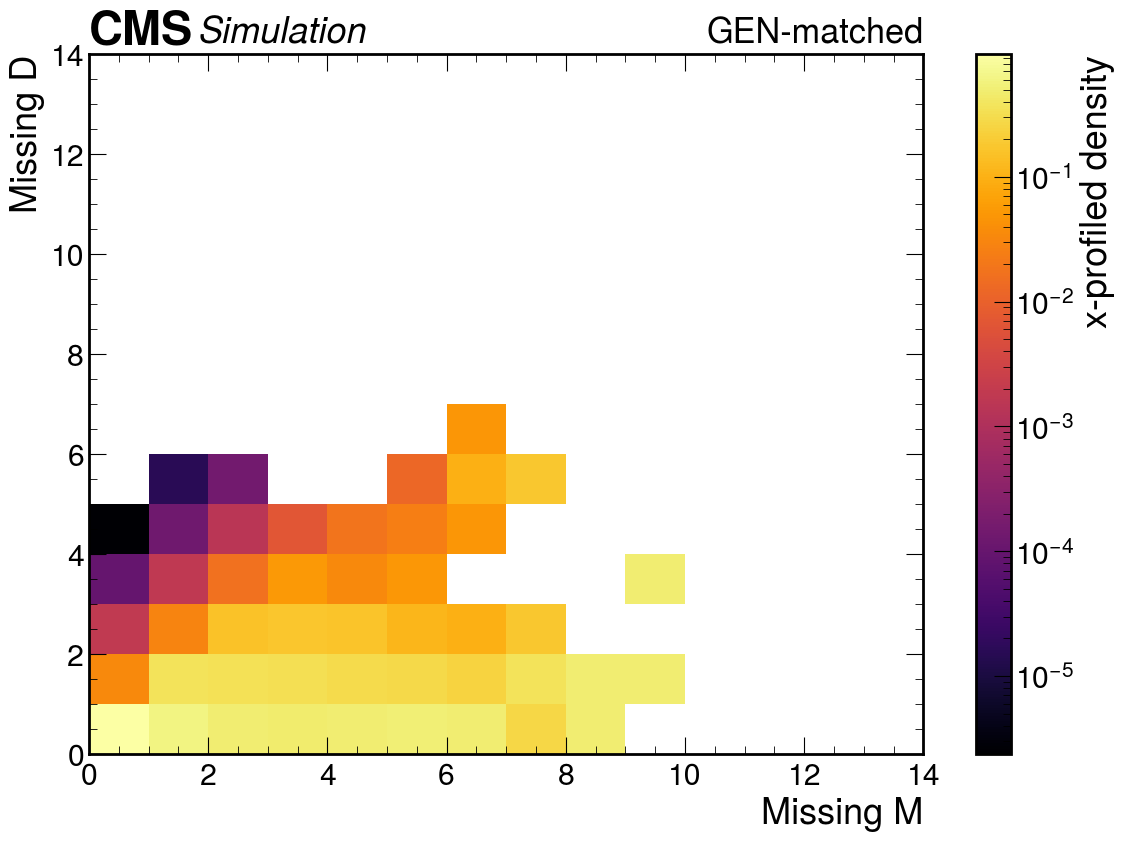

In [38]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_missing_M,
                                  dfmatched_sc.ncls_missing_D,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("Missing D")
ax.set_xlabel("Missing M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_missing_cls_profiled.png")
plt.savefig(f"{output_folder}/Matched_genparticle_missing_cls_profiled.pdf")

/tmp/ipykernel_7187/2782888111.py:12: RuntimeWarning: invalid value encountered in divide
  a = A/s


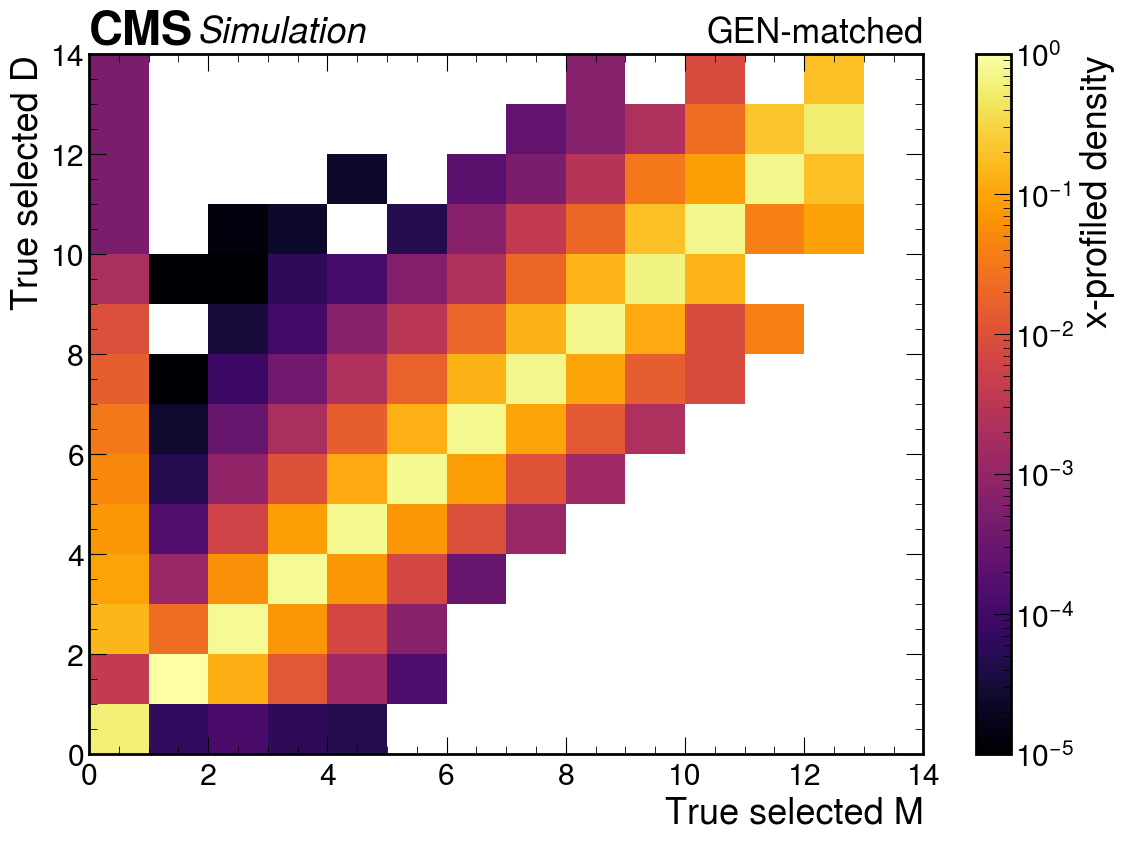

In [39]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_true_M,
                                  dfmatched_sc.ncls_sel_true_D,
                                  bins=(etas, xbins ))
s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(vmax=1, vmin=1e-5), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax, label="x-profiled density")   
ax.set_ylabel("True selected D")
ax.set_xlabel("True selected M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_true_cls_profiled.png")
plt.savefig(f"{output_folder}/Matched_genparticle_true_cls_profiled.pdf")

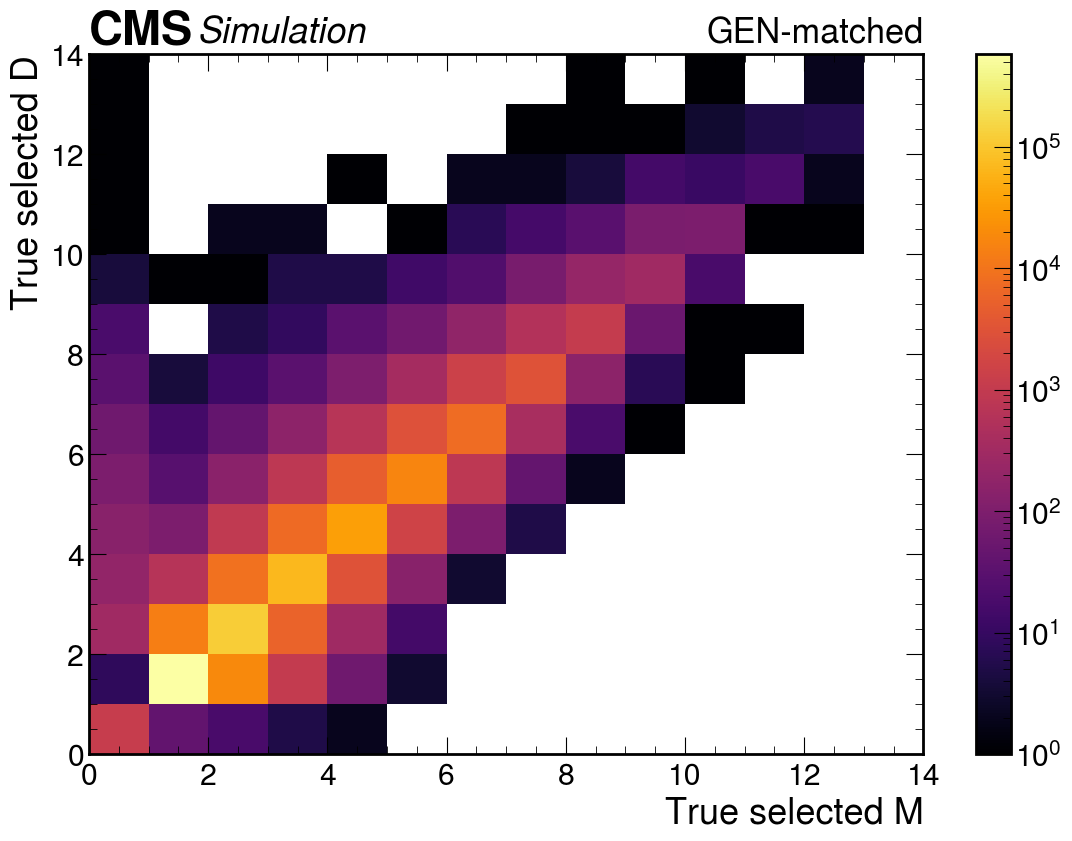

In [40]:
etas =  list(range(15))
xbins =  list(range(15))

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
fig, ax = plt.subplots(1,1, figsize=(12,9),dpi=100)

A,xedges,yedges  = np.histogram2d(dfmatched_sc.ncls_sel_true_M,
                                  dfmatched_sc.ncls_sel_true_D,
                                  bins=(etas, xbins ))
# s = np.expand_dims(np.sum(A, axis=-1), axis=1)
# a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, A.T, norm=LogNorm(), cmap="inferno")

#ax.fill_between([1.485, 1.566], [-40.5,-40.5],[40.5,40.5], color="lightgray", alpha=0.8)

fig.colorbar(I, ax=ax)   
ax.set_ylabel("True selected D")
ax.set_xlabel("True selected M")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_true_cls.png")
plt.savefig(f"{output_folder}/Matched_genparticle_true_cls.pdf")

## Recall and purity plots

In [41]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.566, 1.75,2.,2.3,2.6,3]
ncls = [1,2,3,5,10,12,15,17,20,25,30]
nvtx = [20,30,35,40,45,50,55,60,65,70,75,80,90,100,130]

is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]

dfmatched_sc["eta_bin_D"] = pd.cut(abs(dfmatched_sc.genpart_eta_D), etas, labels=list(range(len(etas)-1)))
dfmatched_sc["et_bin_D"] = pd.cut(dfmatched_sc.genpart_pt_D, ets, labels=list(range(len(ets)-1)))
dfmatched_sc["ncls_bin_D"] = pd.cut(dfmatched_sc.ncls_tot_D, ncls, labels=list(range(len(ncls)-1)))
dfmatched_sc["eta_bin_M"] = pd.cut(abs(dfmatched_sc.genpart_eta_D), etas, labels=list(range(len(etas)-1)))
dfmatched_sc["et_bin_M"] = pd.cut(dfmatched_sc.genpart_pt_M, ets, labels=list(range(len(ets)-1)))
dfmatched_sc["ncls_bin_M"] = pd.cut(dfmatched_sc.ncls_tot_M, ncls, labels=list(range(len(ncls)-1)))


/tmp/ipykernel_7187/95728982.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatched_sc["eta_bin_D"] = pd.cut(abs(dfmatched_sc.genpart_eta_D), etas, labels=list(range(len(etas)-1)))
/tmp/ipykernel_7187/95728982.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatched_sc["et_bin_D"] = pd.cut(dfmatched_sc.genpart_pt_D, ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_7187/95728982.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

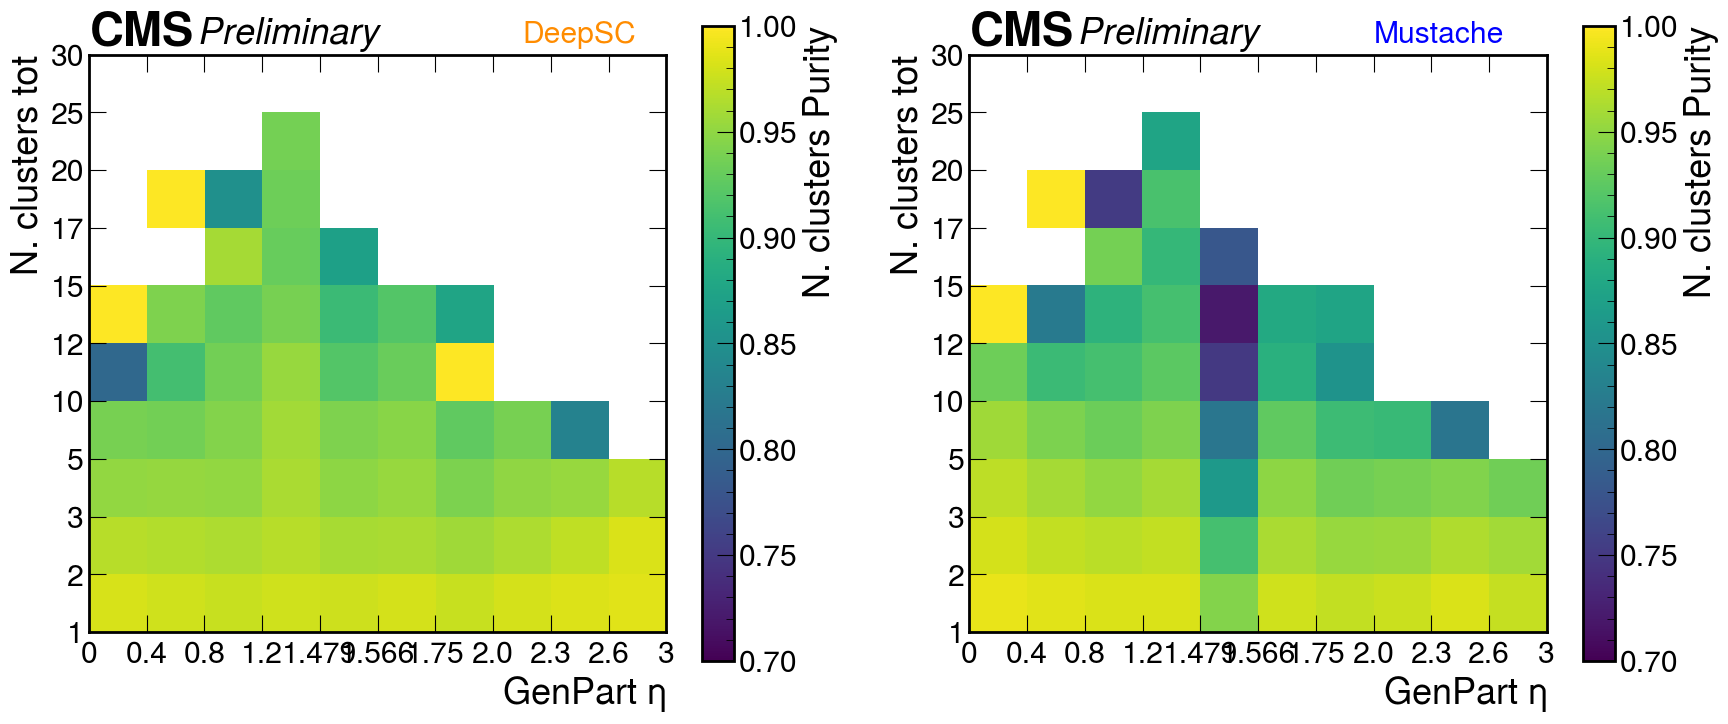

In [42]:
res_dsc =  dfmatched_sc.groupby(["eta_bin_D", "ncls_bin_D"])\
                 .apply( lambda gr:  (gr.ncls_sel_true_D / gr.ncls_true_D).mean())

new_index = pd.MultiIndex.from_product(res_dsc.index.levels)
res_dsc = res_dsc.reindex(new_index)
res_dsc.fillna(0).astype(float)

res_mst =  dfmatched_sc.groupby(["eta_bin_M", "ncls_bin_M"])\
                 .apply( lambda gr:  (gr.ncls_sel_true_M / gr.ncls_true_M).mean())

new_index = pd.MultiIndex.from_product(res_mst.index.levels)
res_mst = res_mst.reindex(new_index)
res_mst.fillna(0).astype(float)

vmin=0.7

fig, (ax, ab) = plt.subplots(1,2, figsize=(18,8),dpi=100)
plt.subplots_adjust( wspace=0.3)

a1 = res_dsc.values.reshape((len(etas)-1,len(ncls)-1))
a1[a1==0] = np.nan
a2 = res_mst.values.reshape((len(etas)-1,len(ncls)-1))
a2[a2==0] = np.nan

A = ax.imshow(a1.T, vmin=vmin, vmax=1)
ax.set_xlabel("GenPart $\eta$")
ax.set_ylabel("N. clusters tot")
fig.colorbar(A , label="N. clusters Purity", ax=ax, shrink=0.9)

ax.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ax.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ax.set_yticklabels(ncls)
ax.set_xticklabels(etas)

B = ab.imshow(a2.T, vmin=vmin, vmax=1)
ab.set_xlabel("GenPart $\eta$")
ab.set_ylabel("N. clusters tot")
fig.colorbar(B , label="N. clusters Purity", ax=ab, shrink=0.9)


ab.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ab.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ab.set_yticklabels(ncls)
ab.set_xticklabels(etas)

ax.text(0.75, 1.02, "DeepSC", transform=ax.transAxes, color='darkorange', fontsize="small", fontweight='roman')
ab.text(0.7, 1.02, "Mustache", transform=ab.transAxes, color='blue', fontsize="small", fontweight='roman')
# ax.text(0.7, 0.9,  flavour, transform=ax.transAxes, fontsize="small", )
# ab.text(0.7, 0.9, flavour, transform=ab.transAxes, fontsize="small")

ax.minorticks_off()
ab.minorticks_off()

hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ab)


plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_ncls_recall.png")
plt.savefig(f"{output_folder}/Matched_ncls_recall.pdf")

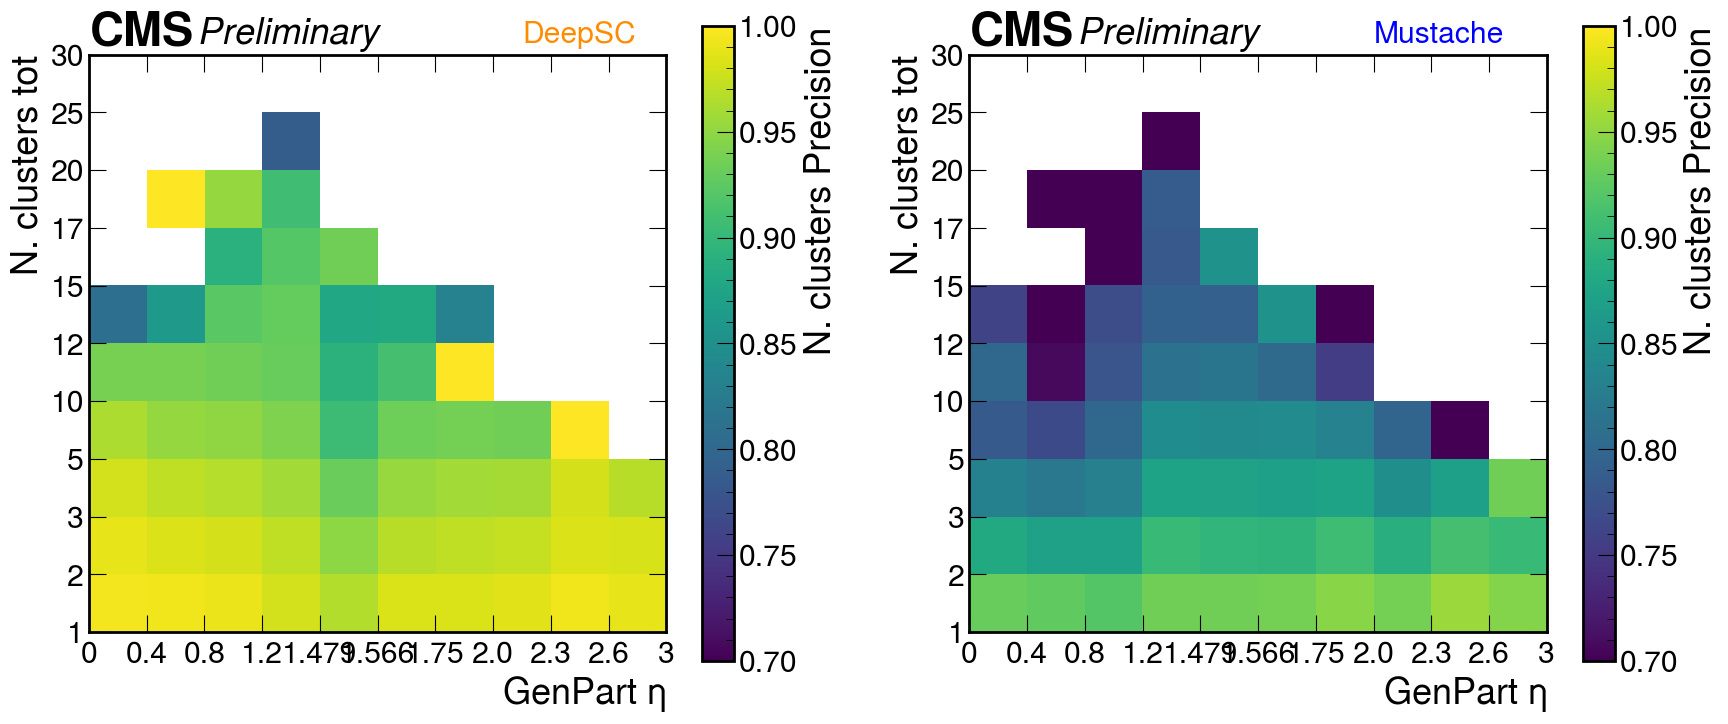

In [43]:
res_dsc =  dfmatched_sc.groupby(["eta_bin_D", "ncls_bin_D"])\
                 .apply( lambda gr:  (gr.ncls_sel_true_D / gr.ncls_sel_D).mean())

new_index = pd.MultiIndex.from_product(res_dsc.index.levels)
res_dsc = res_dsc.reindex(new_index)
res_dsc.fillna(0).astype(float)

res_mst =  dfmatched_sc.groupby(["eta_bin_M", "ncls_bin_M"])\
                 .apply( lambda gr:  (gr.ncls_sel_true_M / gr.ncls_sel_M).mean())

new_index = pd.MultiIndex.from_product(res_mst.index.levels)
res_mst = res_mst.reindex(new_index)
res_mst.fillna(0).astype(float)

vmin=0.7

fig, (ax, ab) = plt.subplots(1,2, figsize=(18,8),dpi=100)
plt.subplots_adjust( wspace=0.3)

a1 = res_dsc.values.reshape((len(etas)-1,len(ncls)-1))
a1[a1==0] = np.nan
a2 = res_mst.values.reshape((len(etas)-1,len(ncls)-1))
a2[a2==0] = np.nan

A = ax.imshow(a1.T, vmin=vmin, vmax=1)
ax.set_xlabel("GenPart $\eta$")
ax.set_ylabel("N. clusters tot")
fig.colorbar(A , label="N. clusters Precision", ax=ax, shrink=0.9)

ax.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ax.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ax.set_yticklabels(ncls)
ax.set_xticklabels(etas)

B = ab.imshow(a2.T, vmin=vmin, vmax=1)
ab.set_xlabel("GenPart $\eta$")
ab.set_ylabel("N. clusters tot")
fig.colorbar(B , label="N. clusters Precision", ax=ab, shrink=0.9)


ab.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ab.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ab.set_yticklabels(ncls)
ab.set_xticklabels(etas)

ax.text(0.75, 1.02, "DeepSC", transform=ax.transAxes, color='darkorange', fontsize="small", fontweight='roman')
ab.text(0.7, 1.02, "Mustache", transform=ab.transAxes, color='blue', fontsize="small", fontweight='roman')
# ax.text(0.7, 0.9,  flavour, transform=ax.transAxes, fontsize="small", )
# ab.text(0.7, 0.9, flavour, transform=ab.transAxes, fontsize="small")

ax.minorticks_off()
ab.minorticks_off()

hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ab)


plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_ncls_purity.png")
plt.savefig(f"{output_folder}/Matched_ncls_purity.pdf")

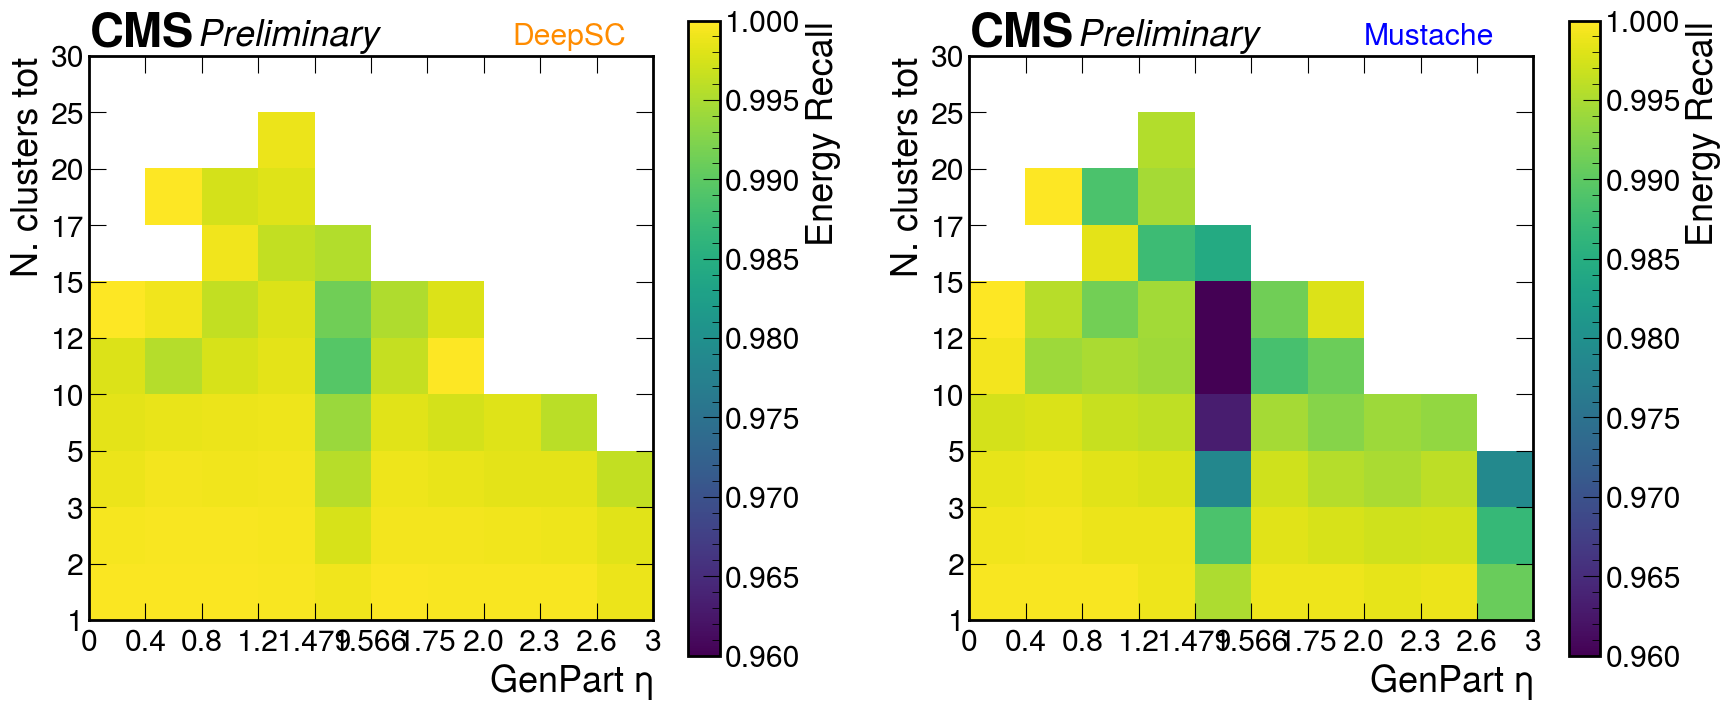

In [44]:
res_dsc =  dfmatched_sc.groupby(["eta_bin_D", "ncls_bin_D"])\
                 .apply( lambda gr:  (gr.sel_true_energy_cls_D / gr.true_energy_cls_D).mean())

new_index = pd.MultiIndex.from_product(res_dsc.index.levels)
res_dsc = res_dsc.reindex(new_index)
res_dsc.fillna(0).astype(float)

res_mst =  dfmatched_sc.groupby(["eta_bin_M", "ncls_bin_M"])\
                 .apply( lambda gr:  (gr.sel_true_energy_cls_M/ gr.true_energy_cls_M).mean())

new_index = pd.MultiIndex.from_product(res_mst.index.levels)
res_mst = res_mst.reindex(new_index)
res_mst.fillna(0).astype(float)

vmin=0.96

fig, (ax, ab) = plt.subplots(1,2, figsize=(18,8),dpi=100)
plt.subplots_adjust( wspace=0.3)

a1 = res_dsc.values.reshape((len(etas)-1,len(ncls)-1))
a1[a1==0] = np.nan
a2 = res_mst.values.reshape((len(etas)-1,len(ncls)-1))
a2[a2==0] = np.nan

A = ax.imshow(a1.T, vmin=vmin, vmax=1)
ax.set_xlabel("GenPart $\eta$")
ax.set_ylabel("N. clusters tot")
fig.colorbar(A , label="Energy Recall", ax=ax, shrink=0.9)

ax.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ax.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ax.set_yticklabels(ncls)
ax.set_xticklabels(etas)

B = ab.imshow(a2.T, vmin=vmin, vmax=1)
ab.set_xlabel("GenPart $\eta$")
ab.set_ylabel("N. clusters tot")
fig.colorbar(B , label="Energy Recall", ax=ab, shrink=0.9)


ab.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ab.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ab.set_yticklabels(ncls)
ab.set_xticklabels(etas)

ax.text(0.75, 1.02, "DeepSC", transform=ax.transAxes, color='darkorange', fontsize="small", fontweight='roman')
ab.text(0.7, 1.02, "Mustache", transform=ab.transAxes, color='blue', fontsize="small", fontweight='roman')
# ax.text(0.7, 0.9,  flavour, transform=ax.transAxes, fontsize="small", )
# ab.text(0.7, 0.9, flavour, transform=ab.transAxes, fontsize="small")

ax.minorticks_off()
ab.minorticks_off()

hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ab)


plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_energy_recall.png")
plt.savefig(f"{output_folder}/Matched_energy_recall.pdf")

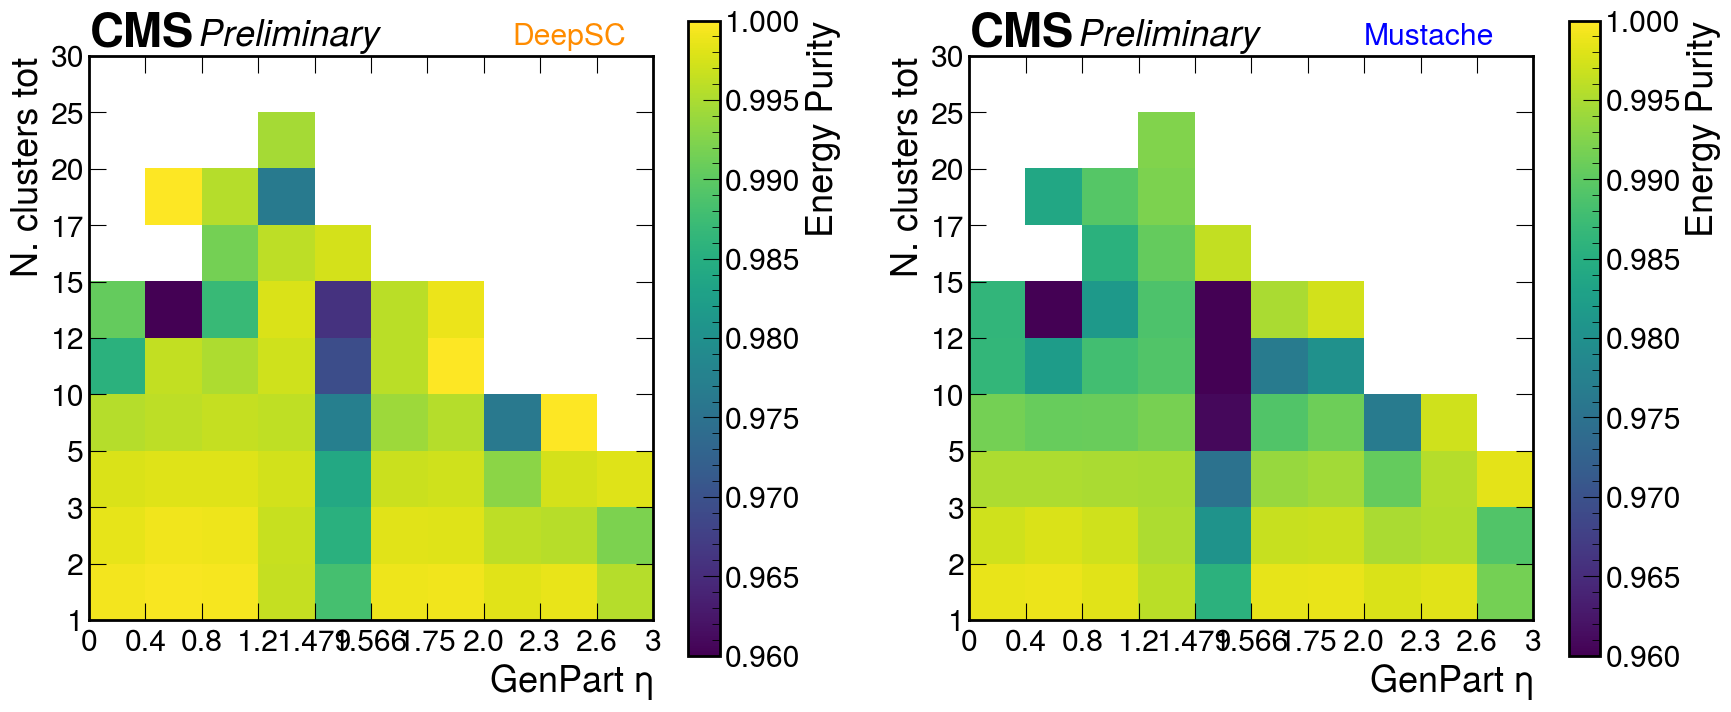

In [45]:
res_dsc =  dfmatched_sc.groupby(["eta_bin_D", "ncls_bin_D"])\
                 .apply( lambda gr:  (gr.sel_true_energy_cls_D / gr.selected_energy_cls_D).mean())

new_index = pd.MultiIndex.from_product(res_dsc.index.levels)
res_dsc = res_dsc.reindex(new_index)
res_dsc.fillna(0).astype(float)

res_mst =  dfmatched_sc.groupby(["eta_bin_M", "ncls_bin_M"])\
                 .apply( lambda gr:  (gr.sel_true_energy_cls_M/ gr.selected_energy_cls_M).mean())

new_index = pd.MultiIndex.from_product(res_mst.index.levels)
res_mst = res_mst.reindex(new_index)
res_mst.fillna(0).astype(float)

vmin=0.96

fig, (ax, ab) = plt.subplots(1,2, figsize=(18,8),dpi=100)
plt.subplots_adjust( wspace=0.3)

a1 = res_dsc.values.reshape((len(etas)-1,len(ncls)-1))
a1[a1==0] = np.nan
a2 = res_mst.values.reshape((len(etas)-1,len(ncls)-1))
a2[a2==0] = np.nan

A = ax.imshow(a1.T, vmin=vmin, vmax=1)
ax.set_xlabel("GenPart $\eta$")
ax.set_ylabel("N. clusters tot")
fig.colorbar(A , label="Energy Purity", ax=ax, shrink=0.9)

ax.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ax.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ax.set_yticklabels(ncls)
ax.set_xticklabels(etas)

B = ab.imshow(a2.T, vmin=vmin, vmax=1)
ab.set_xlabel("GenPart $\eta$")
ab.set_ylabel("N. clusters tot")
fig.colorbar(B , label="Energy Purity", ax=ab, shrink=0.9)


ab.set_yticks(np.arange(len(ncls)) - 0.5, minor=False)
ab.set_xticks(np.arange(len(etas))- 0.5, minor=False)
ab.set_yticklabels(ncls)
ab.set_xticklabels(etas)

ax.text(0.75, 1.02, "DeepSC", transform=ax.transAxes, color='darkorange', fontsize="small", fontweight='roman')
ab.text(0.7, 1.02, "Mustache", transform=ab.transAxes, color='blue', fontsize="small", fontweight='roman')
# ax.text(0.7, 0.9,  flavour, transform=ax.transAxes, fontsize="small", )
# ab.text(0.7, 0.9, flavour, transform=ab.transAxes, fontsize="small")

ax.minorticks_off()
ab.minorticks_off()

hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ab)


plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_energy_purity.png")
plt.savefig(f"{output_folder}/Matched_energy_purity.pdf")

## Kinematics checks|

B: 912091.0
A. 912096.0


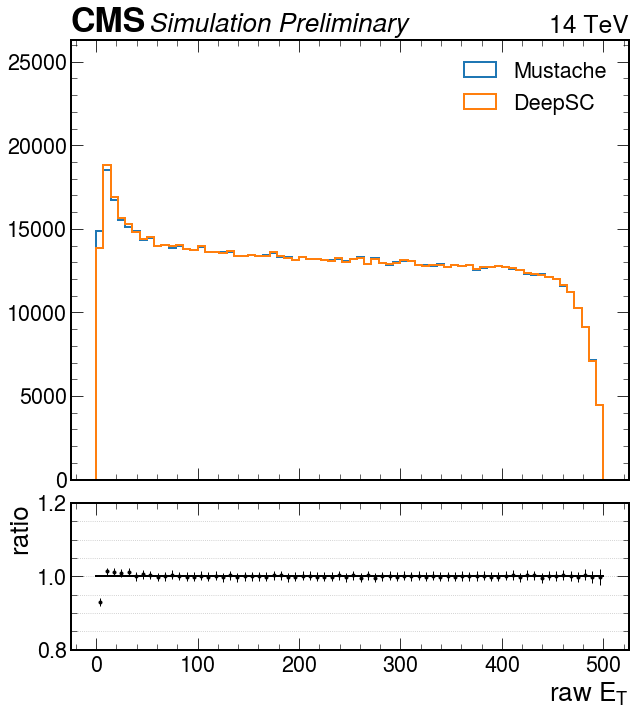

In [46]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.et_sc_raw_M, dfmatched_sc.et_sc_raw_D,
                var=f"SC_rawEt", label="raw $E_T$",
                output_folder=output_folder,
                bins=70, xrange=(0,500), ratio_lim=(0.8,1.2))

B: 907965.0
A. 907980.0


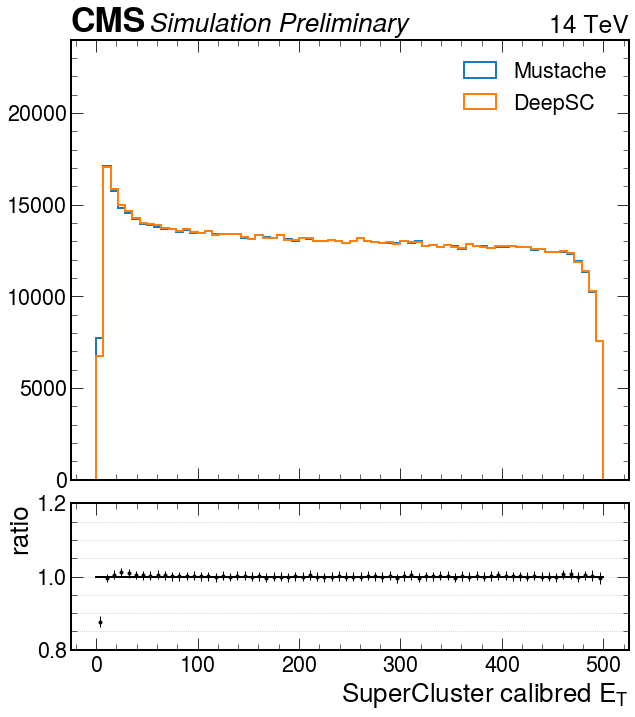

In [47]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.et_sc_calib_M, dfmatched_sc.et_sc_calib_D,
                var=f"SC_rawEt", label="SuperCluster calibred $E_T$",
                output_folder=output_folder,
                bins=70, xrange=(0,500), ratio_lim=(0.8,1.2))

B: 405867.0
A. 324587.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_compari

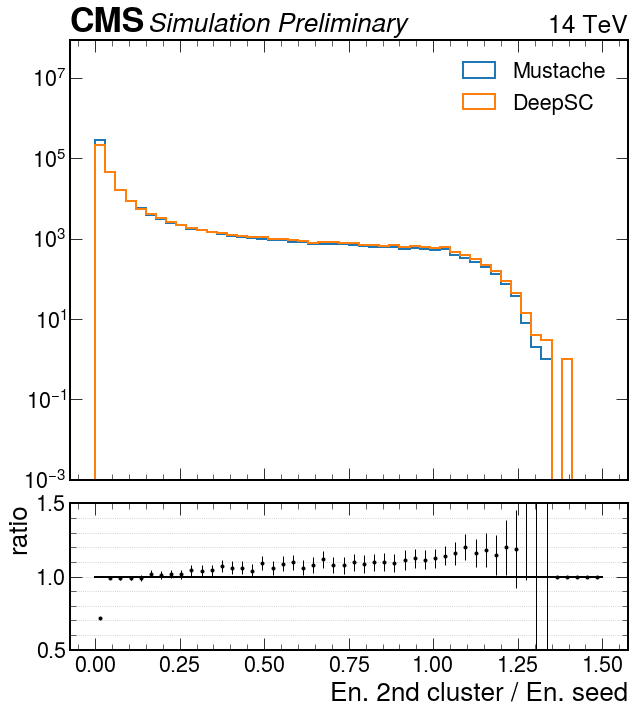

In [48]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.cl2_en_M/dfmatched_sc.en_seed_M, dfmatched_sc.cl2_en_D/dfmatched_sc.en_seed_D,
                var=f"SC_cl2_energy", label="En. 2nd cluster / En. seed",
                output_folder=output_folder, ylog=True,
                bins=50, xrange=(0,1.5), ratio_lim=(0.5,1.5))

B: 219968.0
A. 183948.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_compari

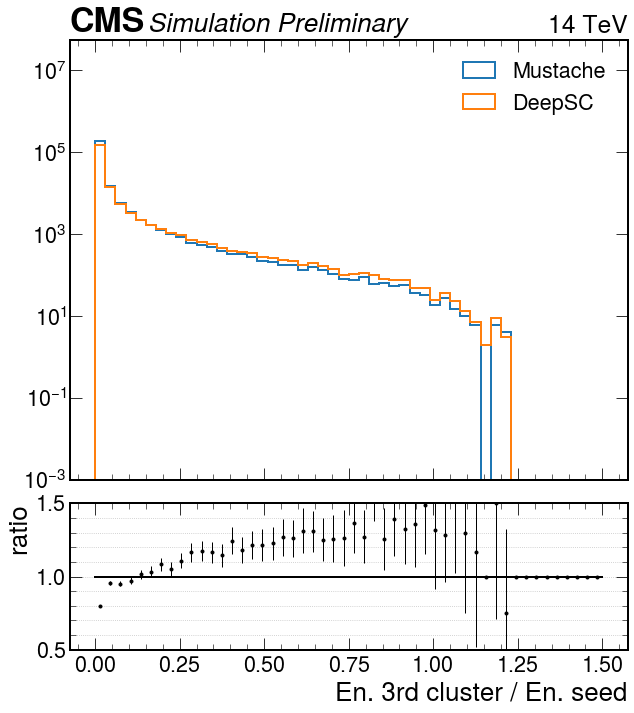

In [49]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.cl3_en_M/dfmatched_sc.en_seed_M, dfmatched_sc.cl3_en_D/dfmatched_sc.en_seed_D,
                var=f"SC_cl2_energy", label="En. 3rd cluster / En. seed",
                output_folder=output_folder, ylog=True,
                bins=50, xrange=(0,1.5), ratio_lim=(0.5,1.5))

B: 907841.0
A. 907298.0


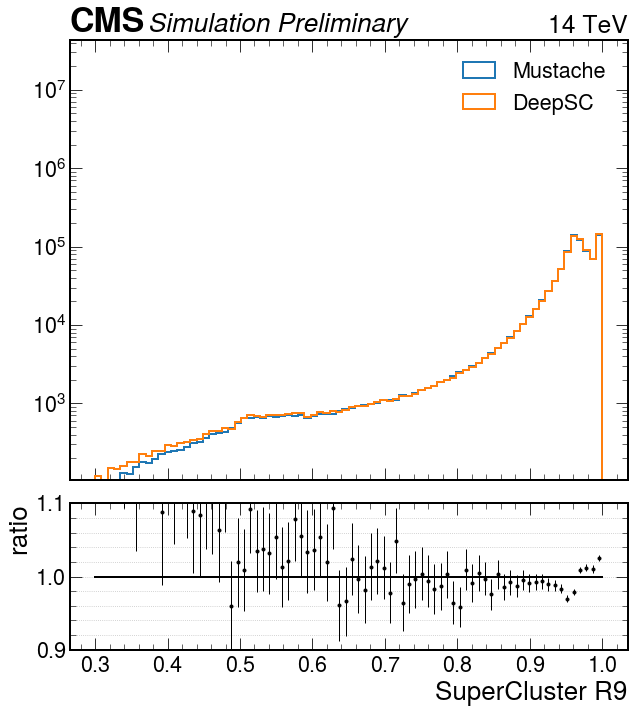

In [50]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_r9_M, dfmatched_sc.sc_r9_D,
                var=f"SC_R9", label="SuperCluster R9",
                output_folder=output_folder, ylog=True,
                bins=80, xrange=(0.3,1), ratio_lim=(0.9,1.1))

B: 779817.0
A. 778386.0


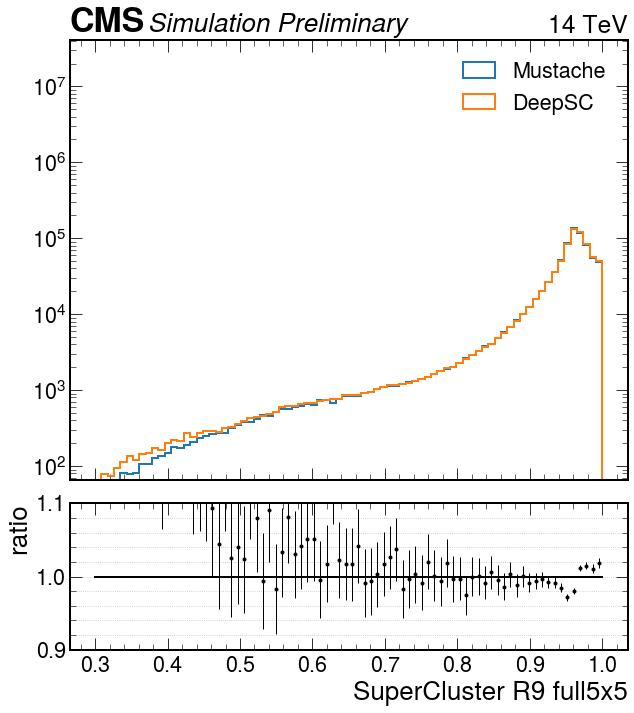

In [51]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_r9_f5x5_M, dfmatched_sc.sc_r9_f5x5_D,
                var=f"SC_R9_f5x5", label="SuperCluster R9 full5x5",
                output_folder=output_folder, ylog=True,
                bins=80, xrange=(0.3,1), ratio_lim=(0.9,1.1))

B: 815579.0
A. 815863.0


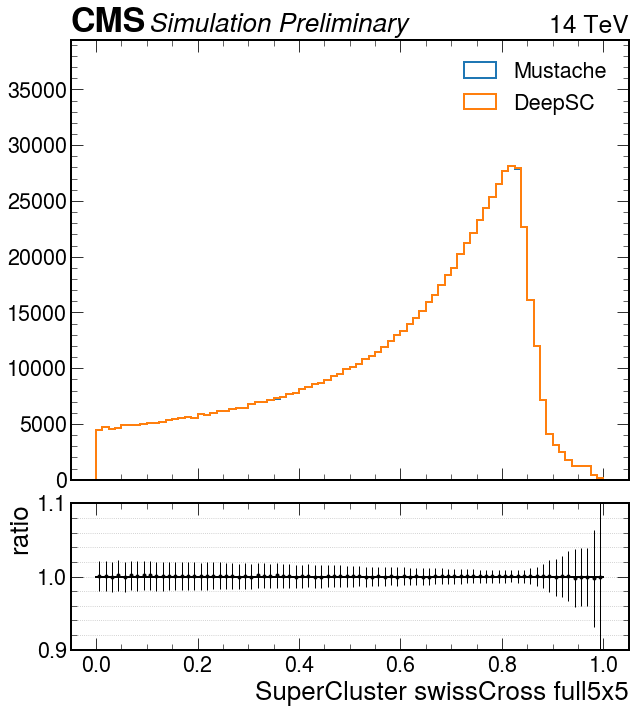

In [52]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_swissCross_f5x5_M, dfmatched_sc.sc_swissCross_f5x5_D,
                var=f"SC_R9_full5x5", label="SuperCluster swissCross full5x5",
                output_folder=output_folder, ylog=False,
                bins=80, xrange=(0,1), ratio_lim=(0.9,1.1))

B: 819839.0
A. 819940.0


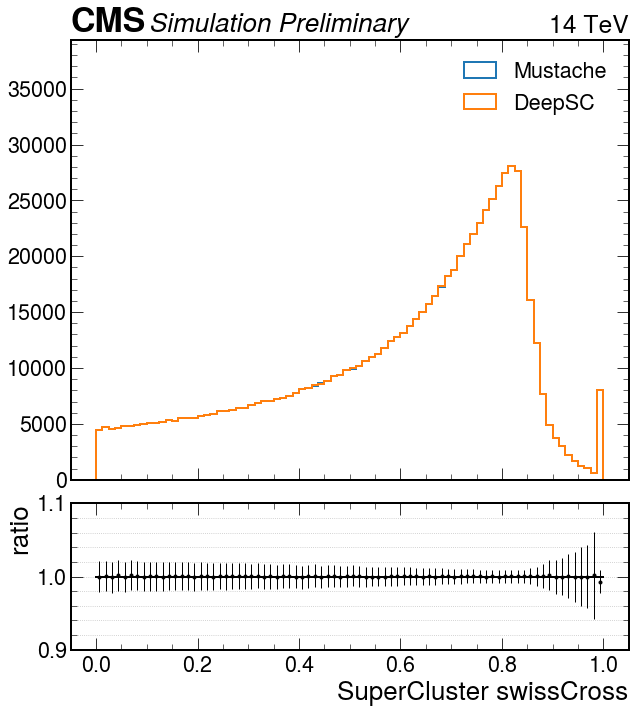

In [53]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_swissCross_M, dfmatched_sc.sc_swissCross_D,
                var=f"SC_R9", label="SuperCluster swissCross",
                output_folder=output_folder, ylog=False,
                bins=80, xrange=(0,1), ratio_lim=(0.9,1.1))

B: 490699.0
A. 490698.0


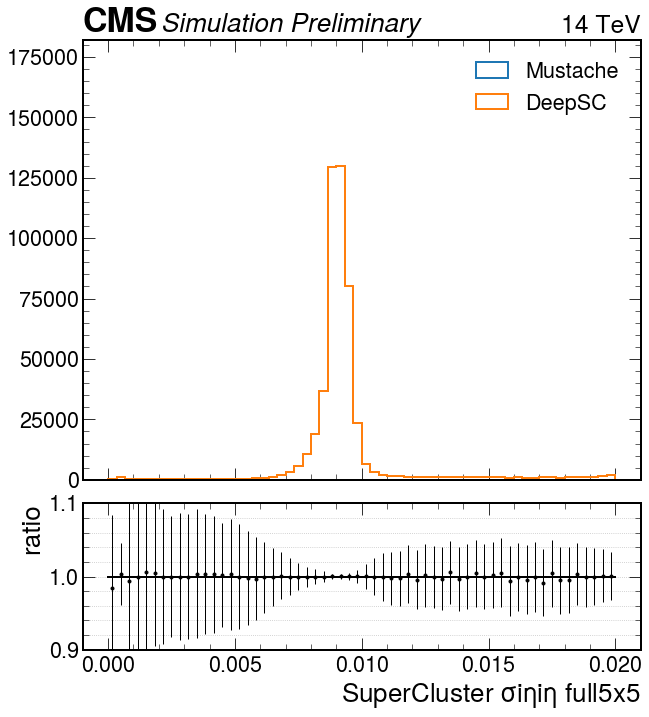

In [54]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_sigmaIetaIeta_f5x5_M, dfmatched_sc.sc_sigmaIetaIeta_f5x5_D,
                var=f"sc_sigmaIetaIeta_f5x5_M", label="SuperCluster $\sigma i \eta i \eta$ full5x5",
                output_folder=output_folder, ylog=False,
                bins=60, xrange=(0.0,0.02), ratio_lim=(0.9,1.1))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_compari

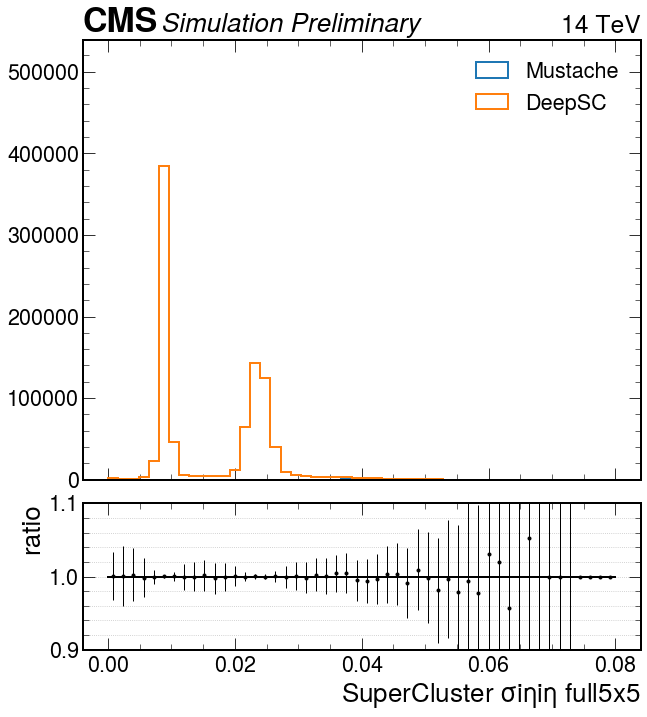

In [55]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_sigmaIetaIeta_f5x5_M, dfmatched_sc.sc_sigmaIetaIeta_f5x5_D,
                var=f"sc_sigmaIetaIeta_f5x5_M", label="SuperCluster $\sigma i \eta i \eta$ full5x5",
                output_folder=output_folder, ylog=False,
                bins=50, xrange=(0.0,0.08), ratio_lim=(0.9,1.1))

B: 459495.0
A. 459545.0


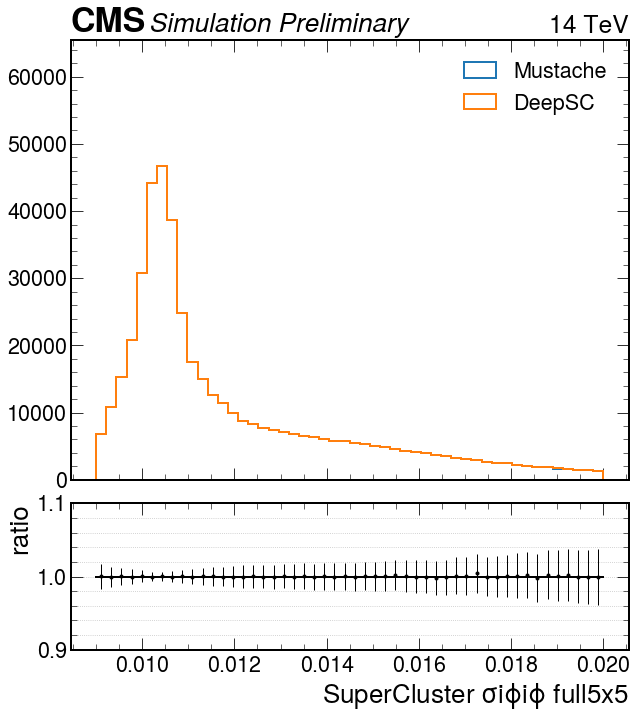

In [56]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_sigmaIphiIphi_f5x5_M, dfmatched_sc.sc_sigmaIphiIphi_f5x5_D,
                var=f"sc_sigmaIphiIphi_f5x5_M", label="SuperCluster $\sigma i \phi i \phi$ full5x5",
                output_folder=output_folder, ylog=False,
                bins=50, xrange=(0.009,0.02), ratio_lim=(0.9,1.1))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: invalid value encountered in divide
  A/B,


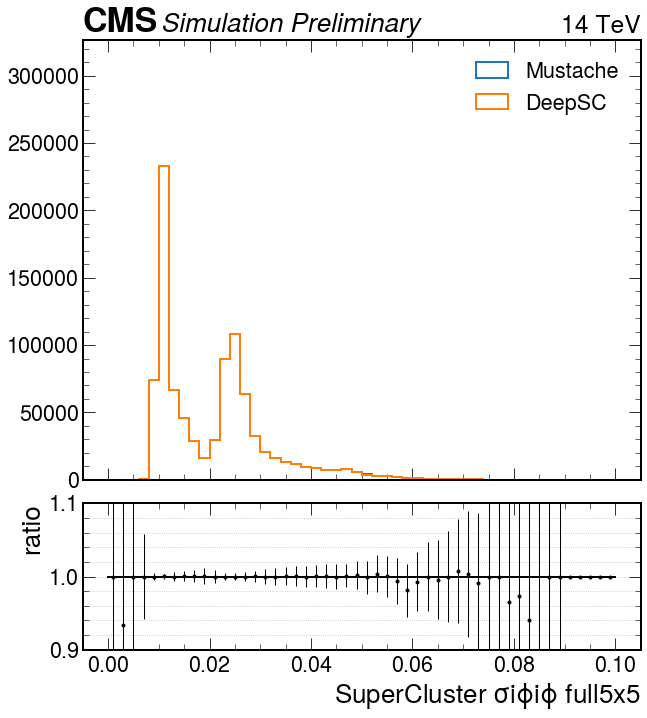

In [57]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_sigmaIphiIphi_f5x5_M, dfmatched_sc.sc_sigmaIphiIphi_f5x5_D,
                var=f"sc_sigmaIphiIphi_f5x5_M", label="SuperCluster $\sigma i \phi i \phi$ full5x5",
                output_folder=output_folder, ylog=False,
                bins=50, xrange=(0.0,0.1), ratio_lim=(0.9,1.1))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: invalid value encountered in divide
  A/B,


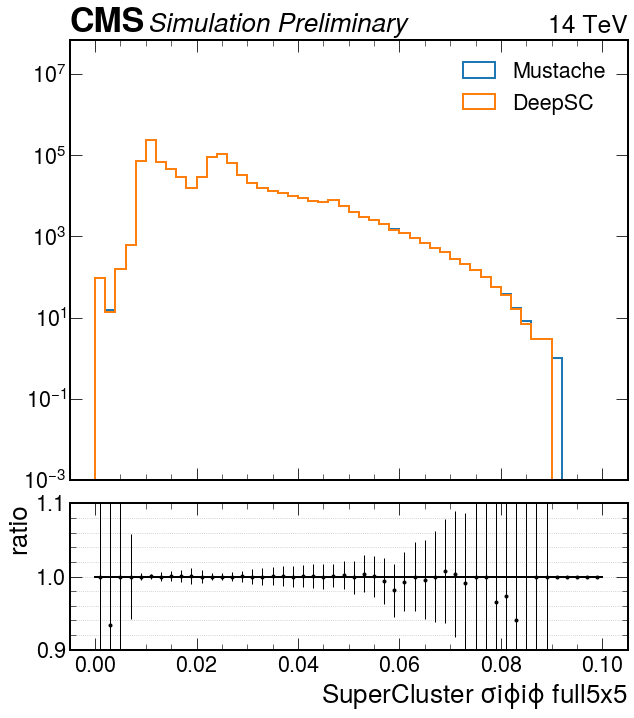

In [58]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_sigmaIphiIphi_f5x5_M, dfmatched_sc.sc_sigmaIphiIphi_f5x5_D,
                var=f"sc_sigmaIphiIphi_f5x5_M", label="SuperCluster $\sigma i \phi i \phi$ full5x5",
                output_folder=output_folder, ylog=True,
                bins=50, xrange=(0.0,0.1), ratio_lim=(0.9,1.1))

B: 785438.0
A. 786527.0


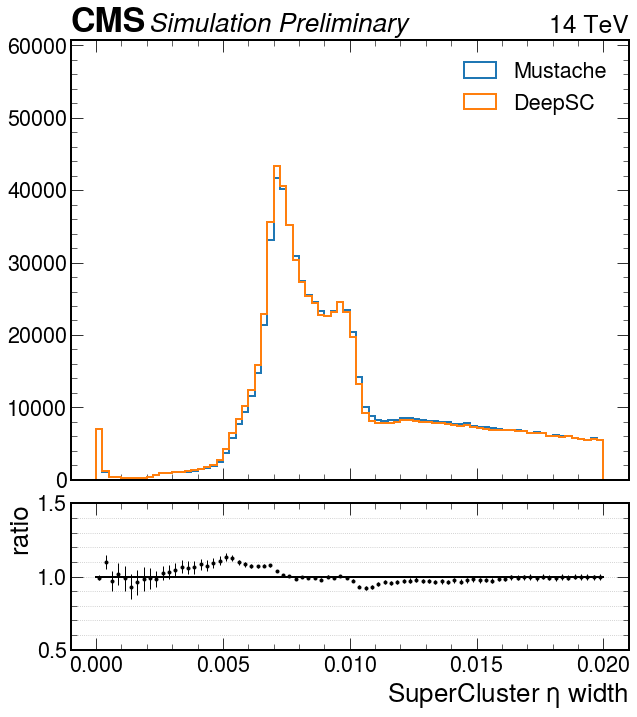

In [59]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_etaWidth_M, dfmatched_sc.sc_etaWidth_D,
                var=f"SC_eta_width", label="SuperCluster $\eta$ width",
                output_folder=output_folder, ylog=False,
                bins=80, xrange=(0,0.02), ratio_lim=(0.5,1.5))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,


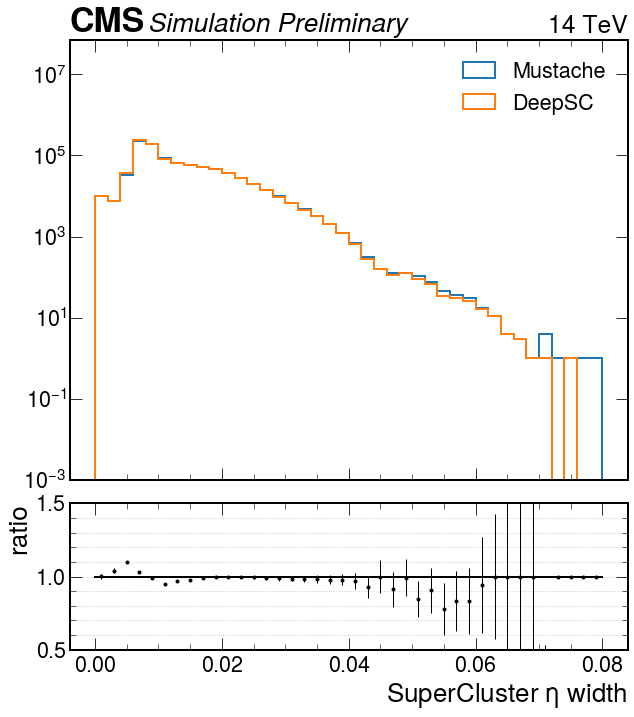

In [60]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_etaWidth_M, dfmatched_sc.sc_etaWidth_D,
                var=f"SC_eta_width", label="SuperCluster $\eta$ width",
                output_folder=output_folder, ylog=True,
                bins=40, xrange=(0,0.08), ratio_lim=(0.5,1.5))

B: 914610.0
A. 914615.0


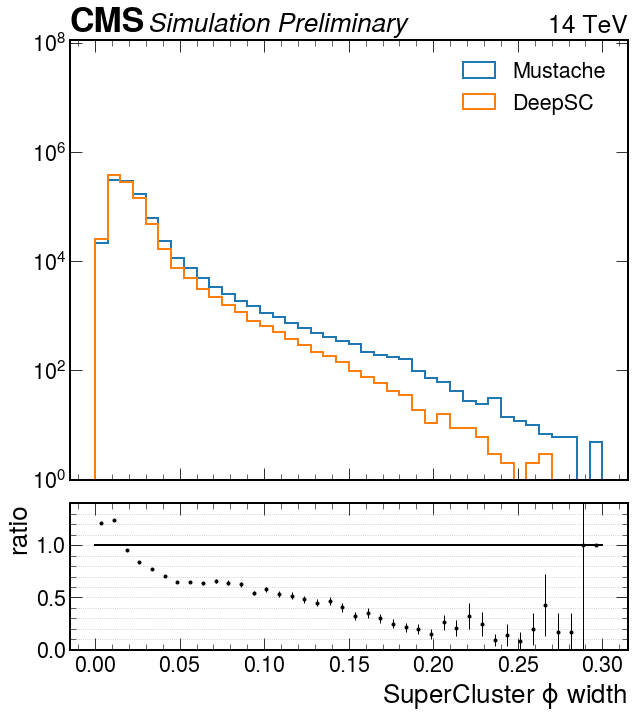

In [61]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.sc_phiWidth_M, dfmatched_sc.sc_phiWidth_D,
                var=f"SC_phi_width", label="SuperCluster $\phi$ width",
                output_folder=output_folder, ylog=True,
                bins=40, xrange=(0,0.3), ratio_lim=(0.,1.4))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: invalid value encountered in divide
  A/B,


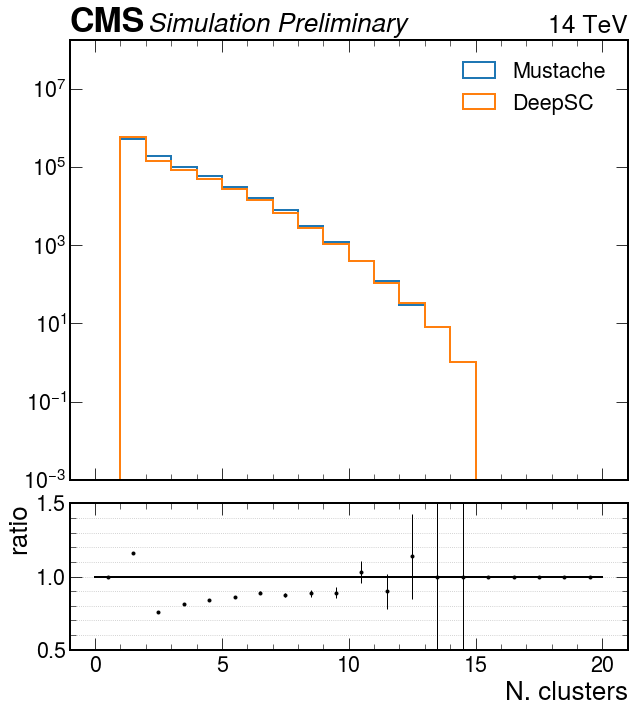

In [62]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.ncls_sel_M, dfmatched_sc.ncls_sel_D,
                var=f"SC_ncls_matched", label="N. clusters",
                output_folder=output_folder, ylog=True,
                bins=20, xrange=(0,20), ratio_lim=(0.5,1.5))

B: 914616.0
A. 914616.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_compari

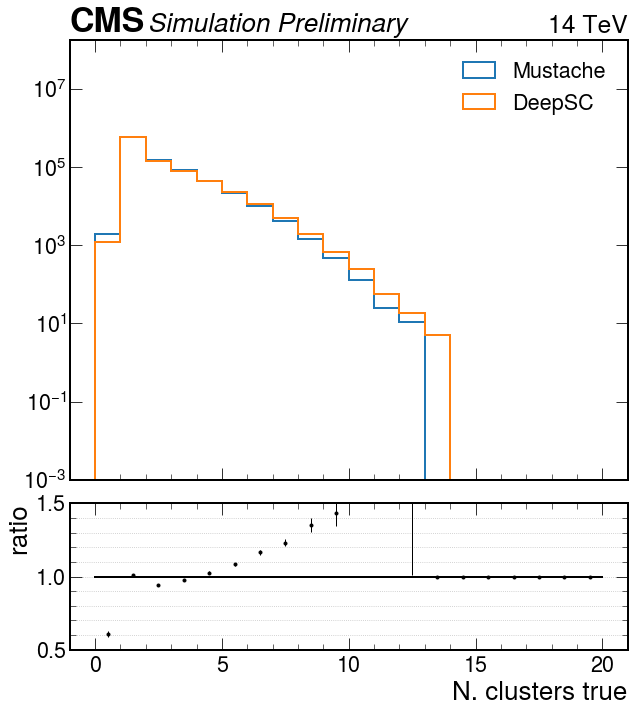

In [63]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.ncls_sel_true_M, dfmatched_sc.ncls_sel_true_D,
                var=f"SC_ncls_true_matched", label="N. clusters true",
                output_folder=output_folder, ylog=True,
                bins=20, xrange=(0,20), ratio_lim=(0.5,1.5))

B: 405867.0
A. 324580.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: divide by zero encountered in divide
  A/B,
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_compari

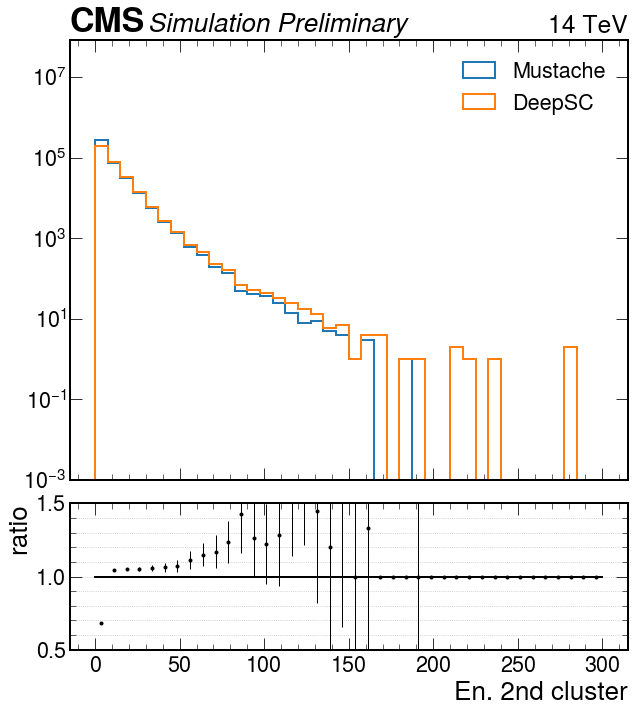

In [64]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.cl2_en_M, dfmatched_sc.cl2_en_D,
                var=f"SC_cl2_energy", label="En. 2nd cluster",
                output_folder=output_folder, ylog=True,
                bins=40, xrange=(0,300), ratio_lim=(0.5,1.5))

B: 219968.0
A. 183948.0


/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:100: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/work/dvalsecc/Clustering/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/notebooks/GenMatchingAnalysis/plotting_utils.py:103: RuntimeWarning: invalid value encountered in divide
  A/B,


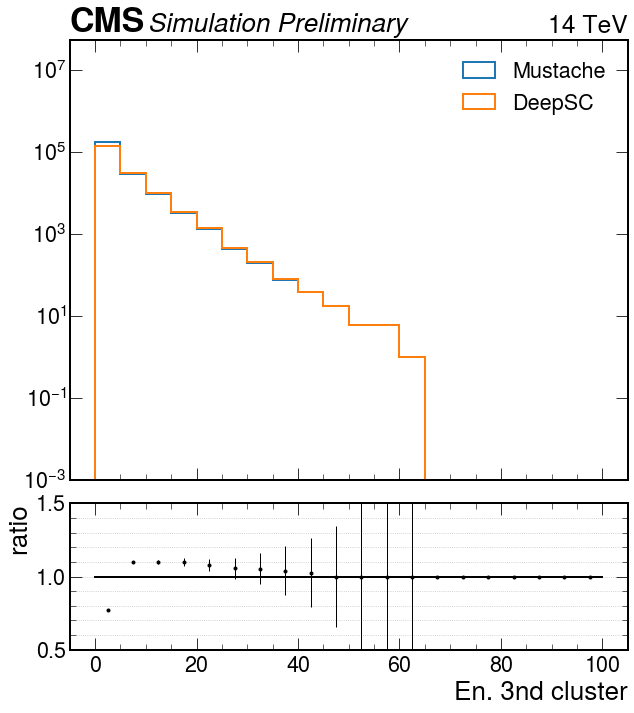

In [65]:
is_matched = (dfj.sc_matched_D==1)&(dfj.sc_matched_M==1)
dfmatched_sc = dfj[is_matched]
plot_comparison(dfmatched_sc.cl3_en_M, dfmatched_sc.cl3_en_D,
                var=f"SC_cl3_energy", label="En. 3nd cluster",
                output_folder=output_folder, ylog=True,
                bins=20, xrange=(0,100), ratio_lim=(0.5,1.5))

# patElectron matching

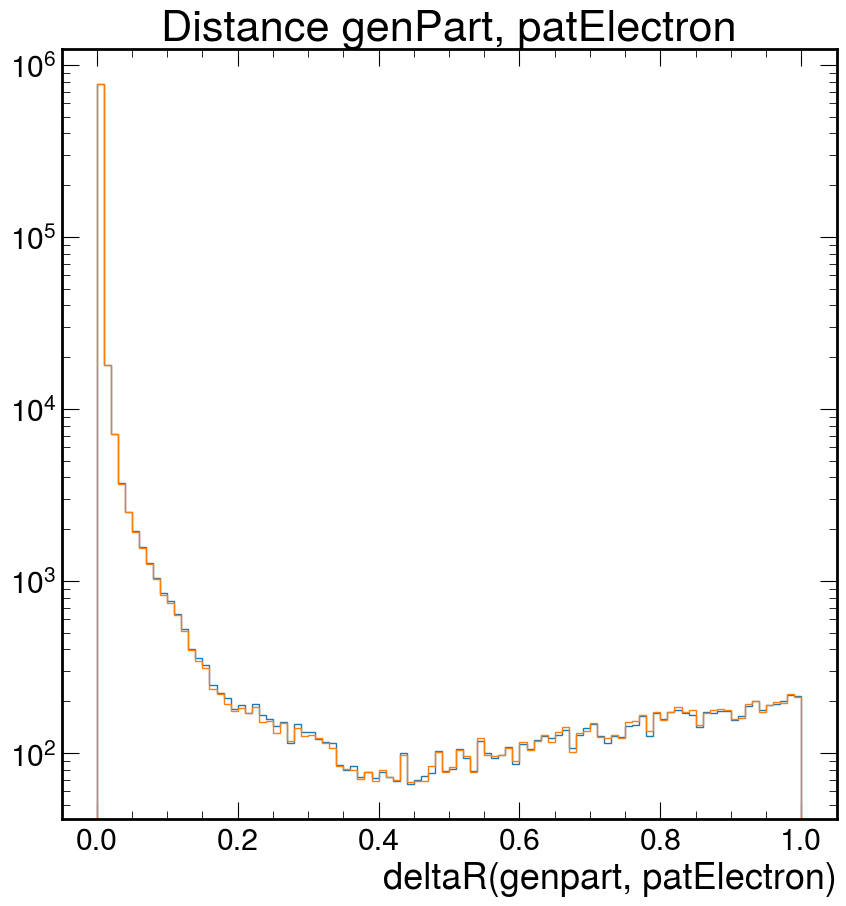

In [66]:
plt.hist(dfj.deltaR_genPart_ele_M, bins=100, range=(0,1), label="Mustache", histtype="step")
plt.hist(dfj.deltaR_genPart_ele_D, bins=100, range=(0,1), label="DeepSC", histtype="step")
plt.xlabel("deltaR(genpart, patElectron)");
plt.title("Distance genPart, patElectron")
plt.yscale("log")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart.png")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart.pdf")

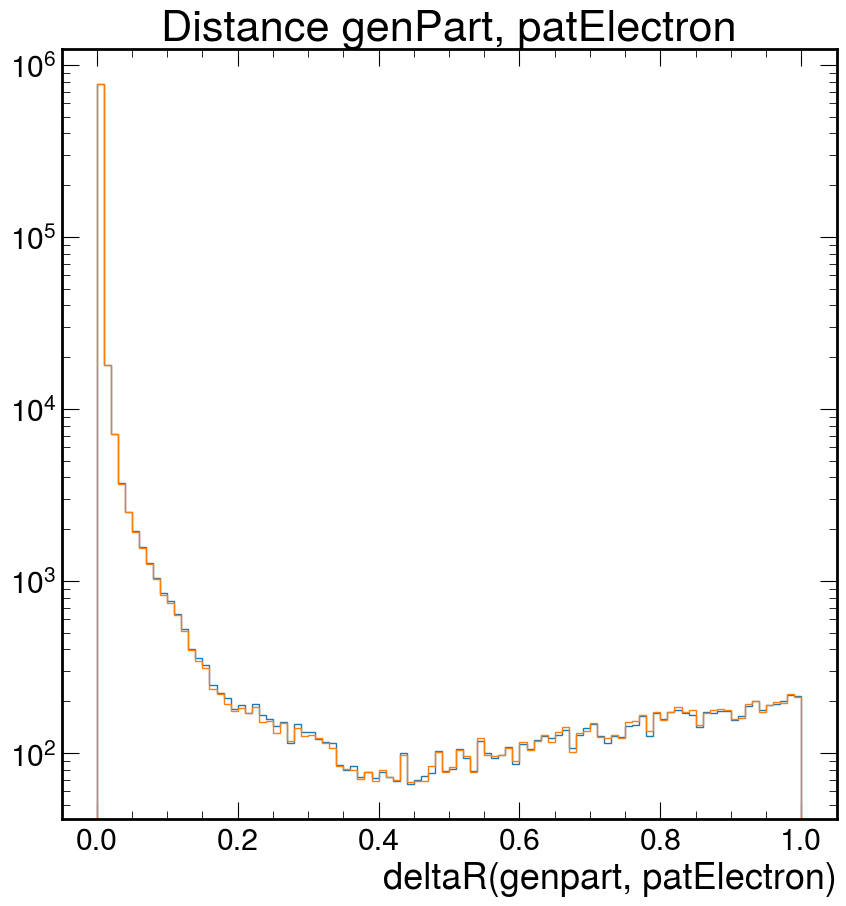

In [67]:
plt.hist(dfj.deltaR_genPart_ele_M, bins=100, range=(0,1), label="Mustache", histtype="step")
plt.hist(dfj.deltaR_genPart_ele_D, bins=100, range=(0,1), label="DeepSC", histtype="step")
plt.xlabel("deltaR(genpart, patElectron)");
plt.title("Distance genPart, patElectron")
plt.yscale("log")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart.png")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart.pdf")

Redefining the patElectron matching by using deltaR

In [68]:
dfj.elematched_M = dfj.deltaR_genPart_ele_M<0.2
dfj.elematched_D = dfj.deltaR_genPart_ele_D<0.2

dfj.phomatched_M = dfj.deltaR_genPart_pho_M<0.2
dfj.phomatched_D = dfj.deltaR_genPart_pho_D<0.2

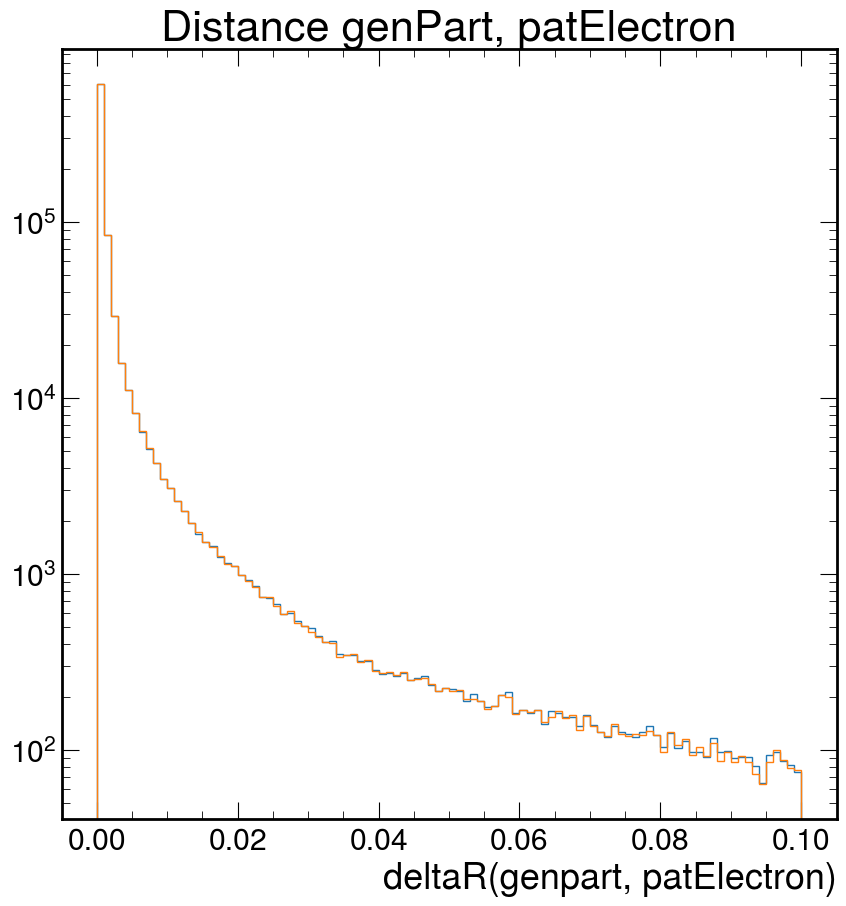

In [69]:
plt.hist(dfj.deltaR_genPart_ele_M[dfj.elematched_M], bins=100, range=(0,0.1), label="Mustache", histtype="step")
plt.hist(dfj.deltaR_genPart_ele_D[dfj.elematched_D], bins=100, range=(0,0.1), label="DeepSC", histtype="step")
plt.xlabel("deltaR(genpart, patElectron)");
plt.title("Distance genPart, patElectron")
plt.yscale("log")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart_matched.png")
plt.savefig(f"{output_folder}/Matched_genparticle_patEle_deltaRgenpart_matched.pdf")

## Cross matching efficiency

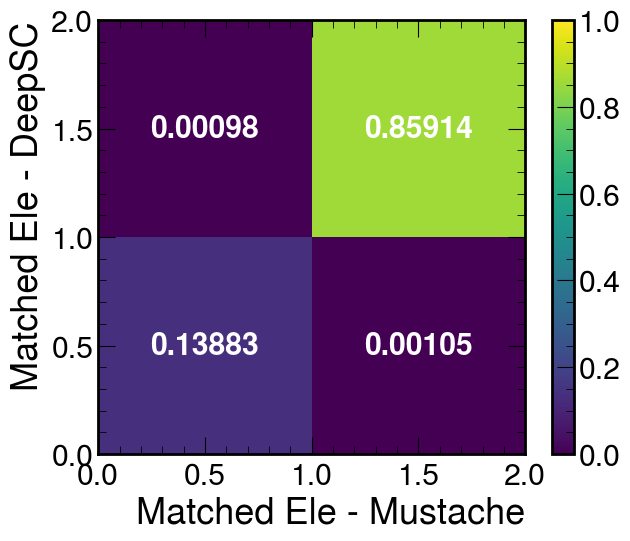

In [70]:
fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d( dfj.elematched_D, dfj.elematched_M,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched Ele - Mustache")
ax.set_ylabel("Matched Ele - DeepSC")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_inclusive.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_inclusive.pdf")

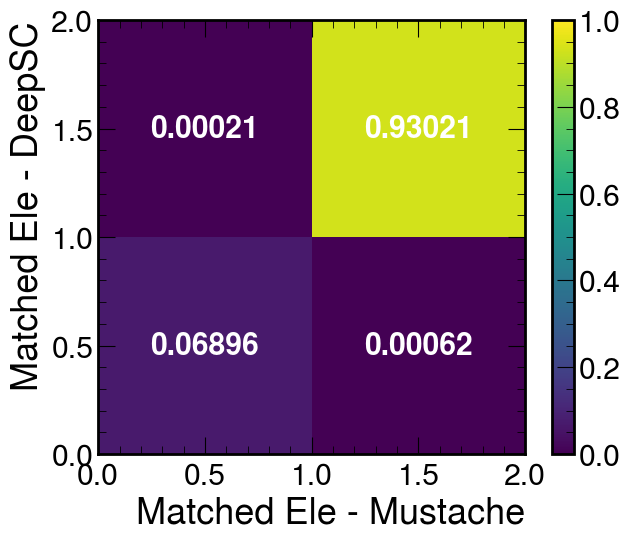

In [71]:
fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d( dfj.phomatched_D, dfj.phomatched_M,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched Ele - Mustache")
ax.set_ylabel("Matched Ele - DeepSC")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_pho_inclusive.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_inclusive.pdf")

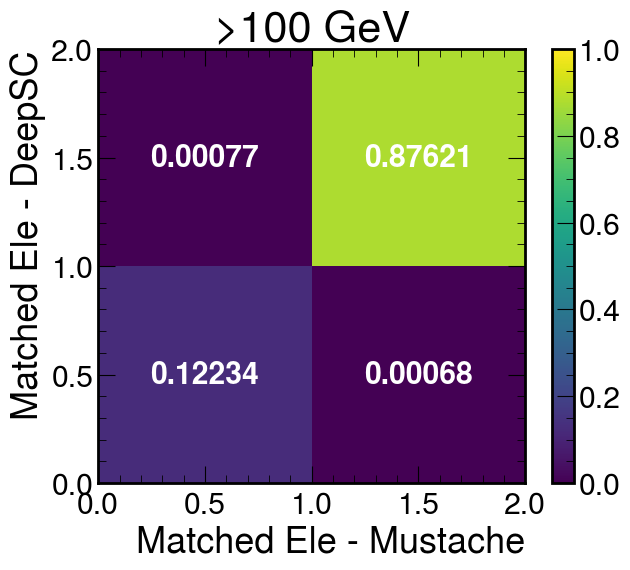

In [73]:
fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d( dfj.elematched_D[dfj.genpart_et_M>100], dfj.elematched_M[dfj.genpart_et_M>100],
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched Ele - Mustache")
ax.set_ylabel("Matched Ele - DeepSC")
plt.tight_layout()
plt.title(">100 GeV")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_inclusive_gt100Gev.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_inclusive_gt100Gev.pdf")

## Ecal driven and tracker driven

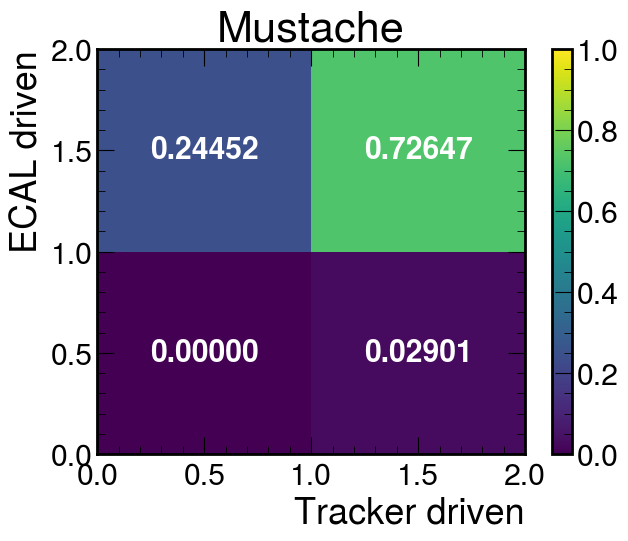

In [74]:
fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d( dfj.ele_isTrackerDriven_M[dfj.elematched_M==1], dfj.ele_isEcalDriven_M[dfj.elematched_M==1],
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Tracker driven")
ax.set_ylabel("ECAL driven")
ax.set_title("Mustache")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_source.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_source.pdf")

/tmp/ipykernel_7187/3827671695.py:30: RuntimeWarning: invalid value encountered in divide
  c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
/tmp/ipykernel_7187/3827671695.py:31: RuntimeWarning: invalid value encountered in divide
  c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
/tmp/ipykernel_7187/3827671695.py:32: RuntimeWarning: invalid value encountered in divide
  c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)
/tmp/ipykernel_7187/3827671695.py:33: RuntimeWarning: invalid value encountered in divide
  c4 = ax4.pcolormesh(X,Y, (noecal_notracker/N_tot).T,vmax=1, vmin=0)


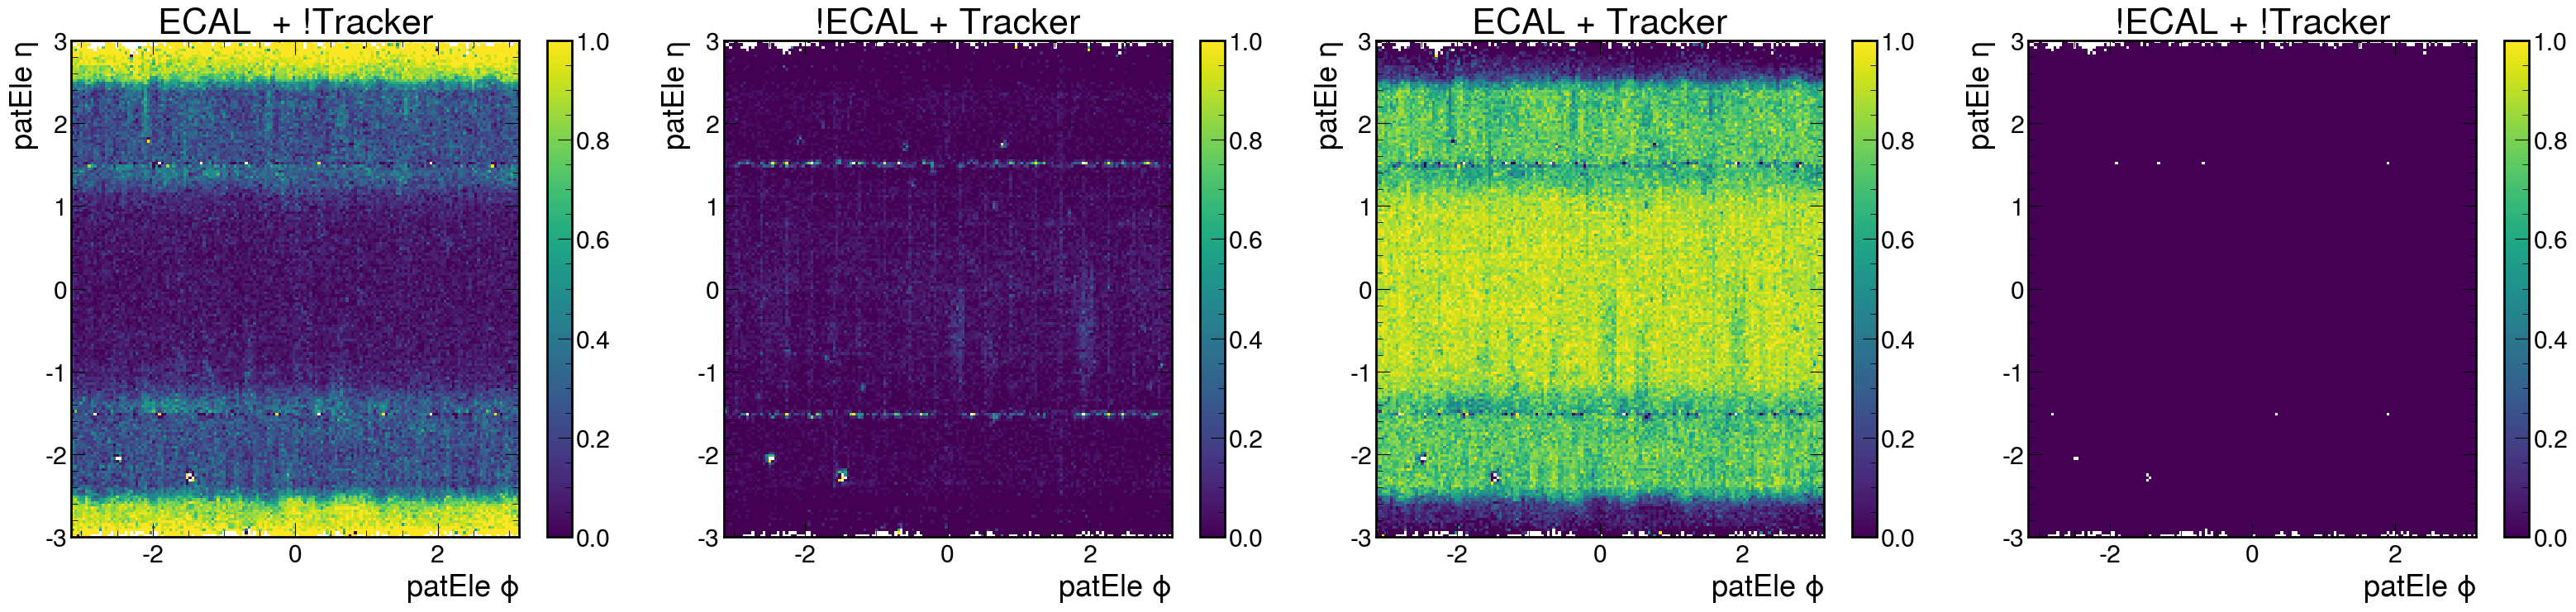

In [75]:
bins = (160, 180)
rrange = ((-np.pi, np.pi),(-3,3))

df = dfj[dfj.elematched_M]
ecal_notracker, _, _ = np.histogram2d(df["ele_phi_M"][(df.ele_isEcalDriven_M==1)&(df.ele_isTrackerDriven_M==0)],
                                      df["ele_eta_M"][(df.ele_isEcalDriven_M==1)&(df.ele_isTrackerDriven_M==0)],
               bins=bins, range=rrange )

noecal_tracker, _, _ = np.histogram2d(df["ele_phi_M"][(df.ele_isEcalDriven_M==0)&(df.ele_isTrackerDriven_M==1)],
                                      df["ele_eta_M"][(df.ele_isEcalDriven_M==0)&(df.ele_isTrackerDriven_M==1)],
               bins=bins, range=rrange )

ecal_tracker, _, _ = np.histogram2d(df["ele_phi_M"][(df.ele_isEcalDriven_M==1)&(df.ele_isTrackerDriven_M==1)],
                                    df["ele_eta_M"][(df.ele_isEcalDriven_M==1)&(df.ele_isTrackerDriven_M==1)],
               bins=bins, range=rrange )

noecal_notracker, _, _ = np.histogram2d(df["ele_phi_M"][(df.ele_isEcalDriven_M==0)&(df.ele_isTrackerDriven_M==0)],
                                    df["ele_eta_M"][(df.ele_isEcalDriven_M==0)&(df.ele_isTrackerDriven_M==0)],
               bins=bins, range=rrange )

N_tot, xbins, ybins = np.histogram2d(df["ele_phi_M"],
                                    df["ele_eta_M"],
               bins=bins, range=rrange )


X, Y = np.meshgrid(xbins, ybins)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(32,8))

c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)
c4 = ax4.pcolormesh(X,Y, (noecal_notracker/N_tot).T,vmax=1, vmin=0)

ax1.set_ylabel("patEle $\eta$")
ax2.set_ylabel("patEle $\eta$")
ax3.set_ylabel("patEle $\eta$")
ax4.set_ylabel("patEle $\eta$")

ax1.set_xlabel("patEle $\phi$")
ax2.set_xlabel("patEle $\phi$")
ax3.set_xlabel("patEle $\phi$")
ax4.set_xlabel("patEle $\phi$")

ax1.set_title("ECAL  + !Tracker")
ax2.set_title("!ECAL + Tracker")
ax3.set_title("ECAL + Tracker")
ax4.set_title("!ECAL + !Tracker")


plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()


/tmp/ipykernel_7187/1830422821.py:30: RuntimeWarning: invalid value encountered in divide
  c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
/tmp/ipykernel_7187/1830422821.py:31: RuntimeWarning: invalid value encountered in divide
  c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
/tmp/ipykernel_7187/1830422821.py:32: RuntimeWarning: invalid value encountered in divide
  c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)
/tmp/ipykernel_7187/1830422821.py:33: RuntimeWarning: invalid value encountered in divide
  c4 = ax4.pcolormesh(X,Y, (noecal_notracker/N_tot).T,vmax=1, vmin=0)


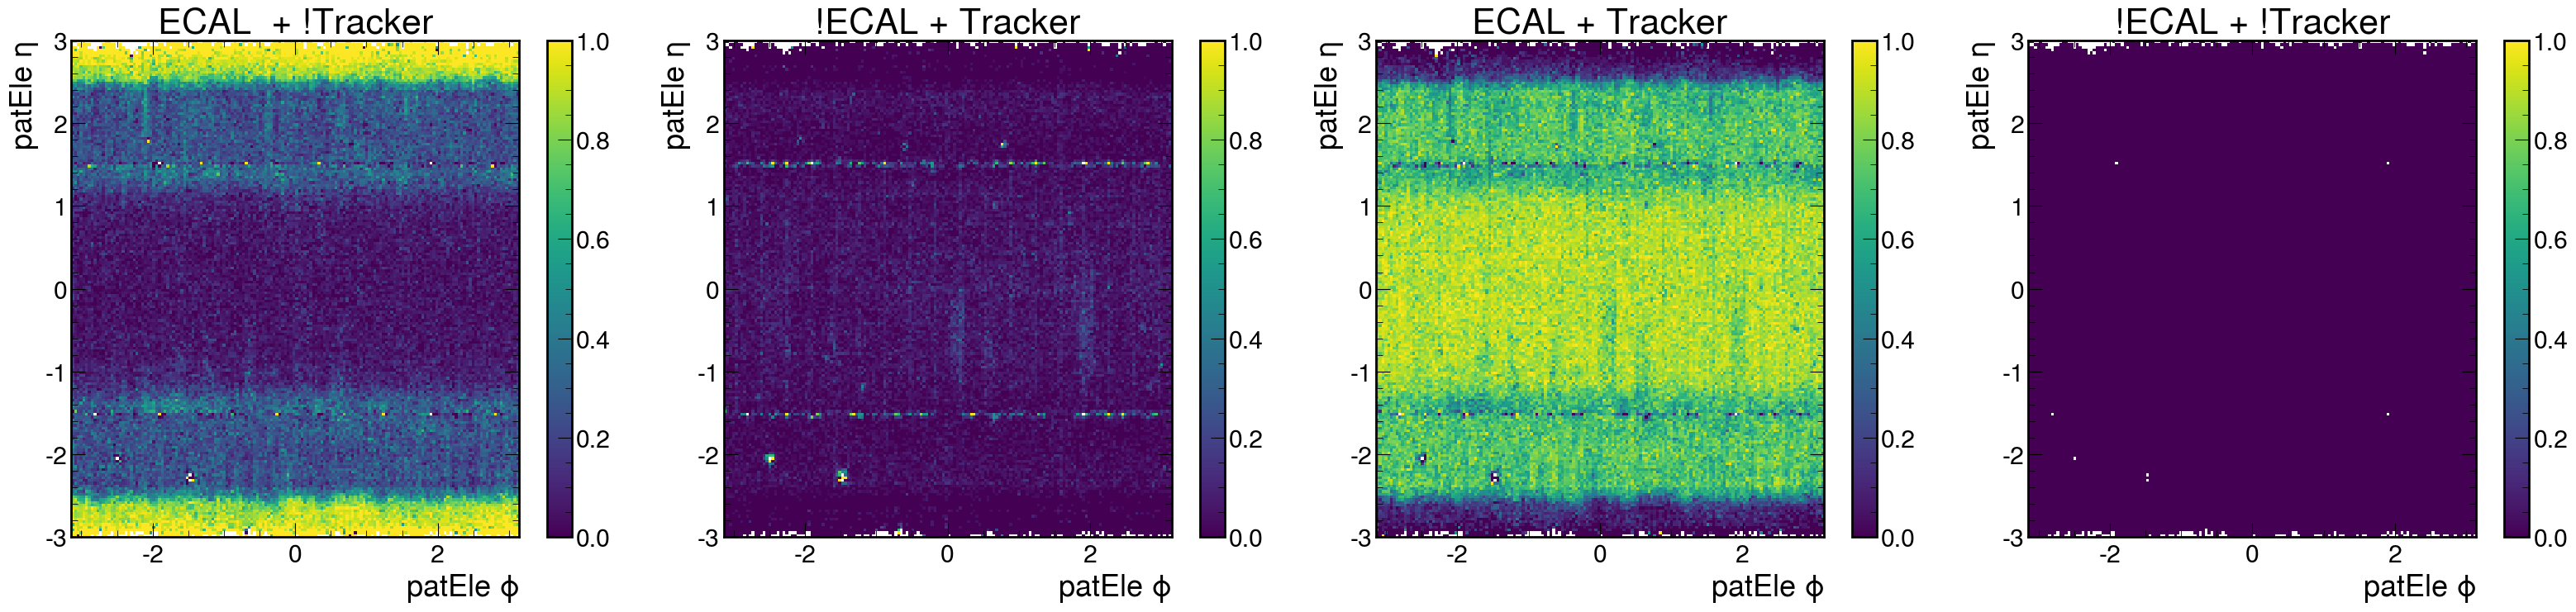

In [76]:
bins = (160, 180)
rrange = ((-np.pi, np.pi),(-3,3))

df = df_2
ecal_notracker, _, _ = np.histogram2d(df["ele_phi"][(df.ele_isEcalDriven==1)&(df.ele_isTrackerDriven==0)],
                                      df["ele_eta"][(df.ele_isEcalDriven==1)&(df.ele_isTrackerDriven==0)],
               bins=bins, range=rrange )

noecal_tracker, _, _ = np.histogram2d(df["ele_phi"][(df.ele_isEcalDriven==0)&(df.ele_isTrackerDriven==1)],
                                      df["ele_eta"][(df.ele_isEcalDriven==0)&(df.ele_isTrackerDriven==1)],
               bins=bins, range=rrange )

ecal_tracker, _, _ = np.histogram2d(df["ele_phi"][(df.ele_isEcalDriven==1)&(df.ele_isTrackerDriven==1)],
                                    df["ele_eta"][(df.ele_isEcalDriven==1)&(df.ele_isTrackerDriven==1)],
               bins=bins, range=rrange )

noecal_notracker, _, _ = np.histogram2d(df["ele_phi"][(df.ele_isEcalDriven==0)&(df.ele_isTrackerDriven==0)],
                                    df["ele_eta"][(df.ele_isEcalDriven==0)&(df.ele_isTrackerDriven==0)],
               bins=bins, range=rrange )

N_tot, xbins, ybins = np.histogram2d(df["ele_phi"],
                                    df["ele_eta"],
               bins=bins, range=rrange )


X, Y = np.meshgrid(xbins, ybins)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(32,8))

c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)
c4 = ax4.pcolormesh(X,Y, (noecal_notracker/N_tot).T,vmax=1, vmin=0)

ax1.set_ylabel("patEle $\eta$")
ax2.set_ylabel("patEle $\eta$")
ax3.set_ylabel("patEle $\eta$")
ax4.set_ylabel("patEle $\eta$")

ax1.set_xlabel("patEle $\phi$")
ax2.set_xlabel("patEle $\phi$")
ax3.set_xlabel("patEle $\phi$")
ax4.set_xlabel("patEle $\phi$")

ax1.set_title("ECAL  + !Tracker")
ax2.set_title("!ECAL + Tracker")
ax3.set_title("ECAL + Tracker")
ax4.set_title("!ECAL + !Tracker")


plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()


In [217]:
noecal_notracker

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/tmp/ipykernel_7187/1986403537.py:25: RuntimeWarning: invalid value encountered in divide
  c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
/tmp/ipykernel_7187/1986403537.py:26: RuntimeWarning: invalid value encountered in divide
  c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
/tmp/ipykernel_7187/1986403537.py:27: RuntimeWarning: invalid value encountered in divide
  c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)


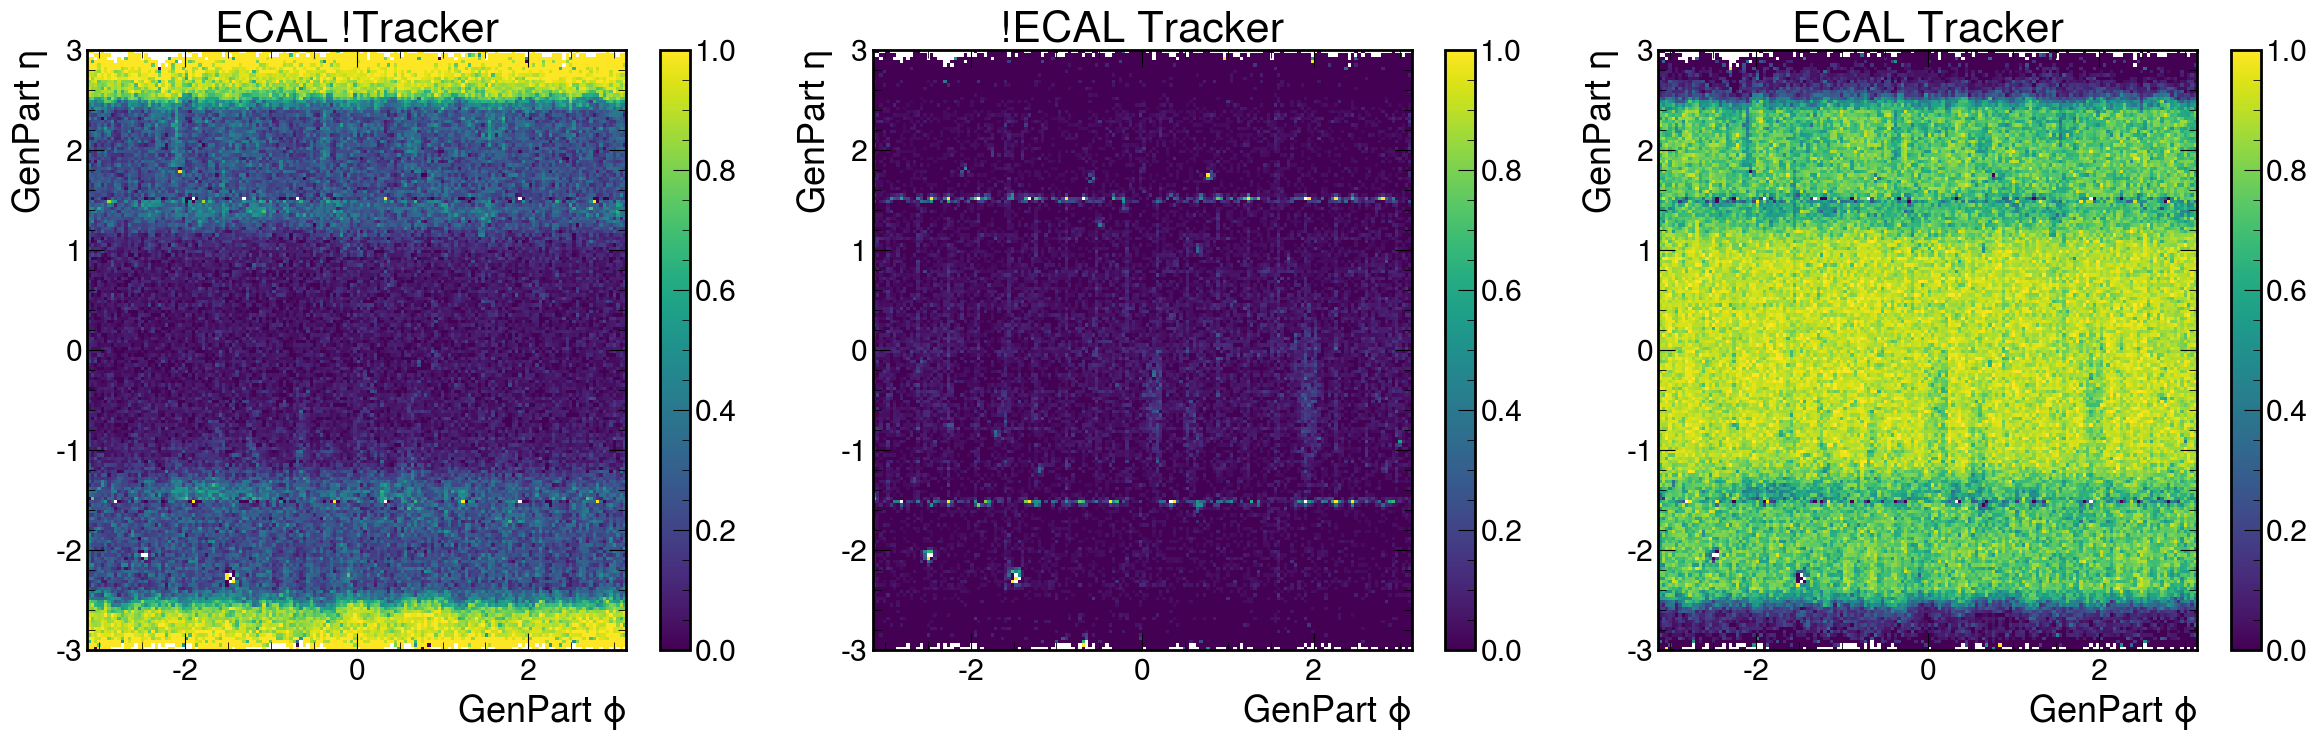

In [77]:
bins = (160, 180)
rrange = ((-np.pi, np.pi),(-3,3))
df_join = dfj
ecal_notracker, _, _ = np.histogram2d(dfj["ele_phi_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isTrackerDriven_M==0)],
                                      dfj["ele_eta_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isTrackerDriven_M==0)],
               bins=bins, range=rrange )

noecal_tracker, _, _ = np.histogram2d(dfj["ele_phi_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)&(dfj.ele_isTrackerDriven_M==1)],
                                      dfj["ele_eta_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)&(dfj.ele_isTrackerDriven_M==1)],
               bins=bins, range=rrange )

ecal_tracker, _, _ = np.histogram2d(dfj["ele_phi_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isTrackerDriven_M==1)],
                                    dfj["ele_eta_M"][(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isTrackerDriven_M==1)],
               bins=bins, range=rrange )

N_tot, xbins, ybins = np.histogram2d(dfj["ele_phi_M"][(dfj.elematched_M==1)],
                                    dfj["ele_eta_M"][(dfj.elematched_M==1)],
               bins=bins, range=rrange )


X, Y = np.meshgrid(xbins, ybins)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))

c1 = ax1.pcolormesh(X,Y, (ecal_notracker/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (noecal_tracker/N_tot).T,vmax=1, vmin=0)
c3 = ax3.pcolormesh(X,Y, (ecal_tracker/N_tot).T,vmax=1, vmin=0)

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax3.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax3.set_xlabel("GenPart $\phi$")

ax1.set_title("ECAL !Tracker")
ax2.set_title("!ECAL Tracker")
ax3.set_title("ECAL Tracker")


plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.colorbar(c3, ax=ax3)
plt.tight_layout()


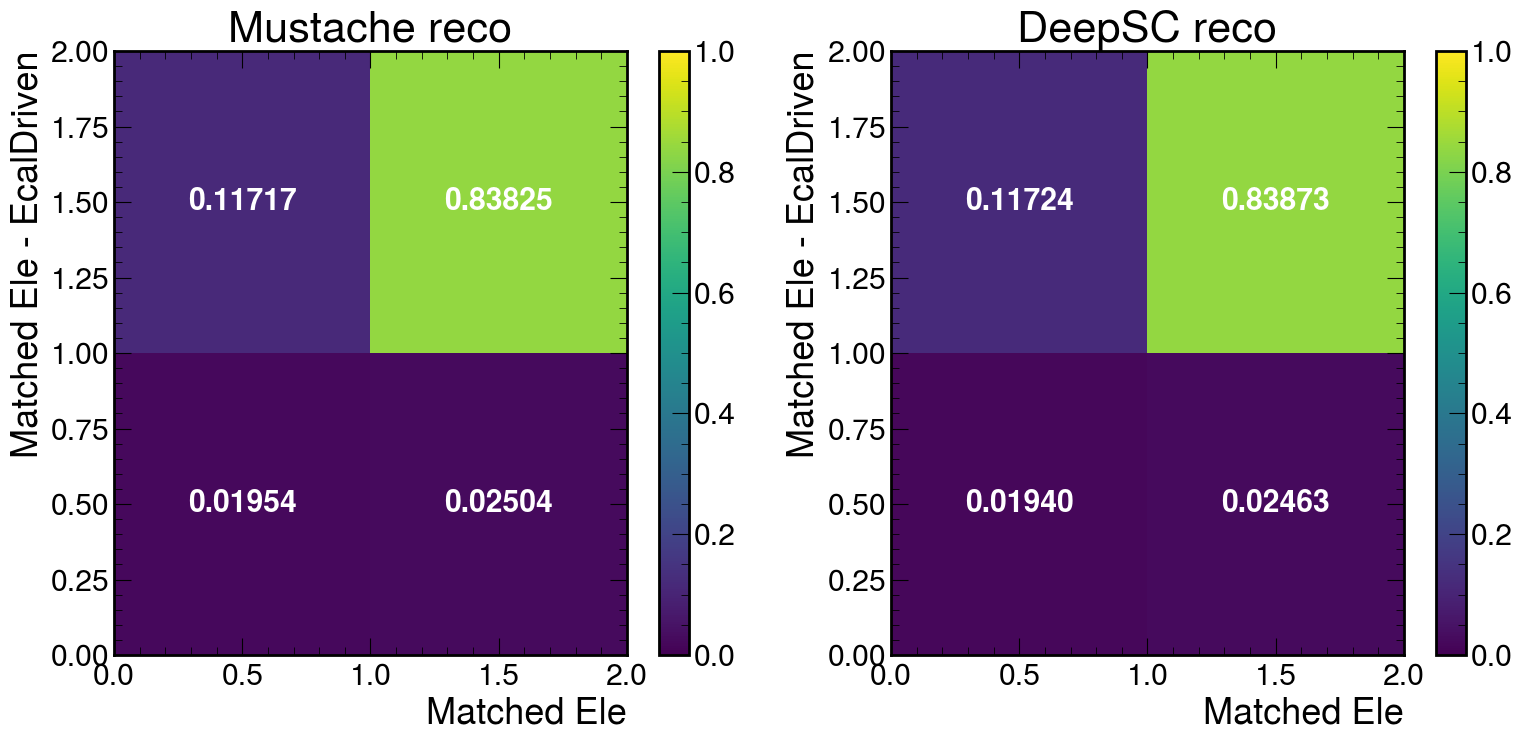

In [78]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(16,8))


hist, xbins, ybins = np.histogram2d( dfj.elematched_M, dfj.ele_isEcalDriven_M,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)
hist2, xbins, ybins = np.histogram2d( dfj.elematched_D, dfj.ele_isEcalDriven_D,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)
C2 = ax2.pcolormesh(X,Y, hist2.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")
        ax2.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist2.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

plt.colorbar(C,ax=ax)
plt.colorbar(C2,ax=ax2)

ax.set_xlabel("Matched Ele")
ax.set_ylabel("Matched Ele - EcalDriven")
ax2.set_xlabel("Matched Ele")
ax2.set_ylabel("Matched Ele - EcalDriven")
ax.set_title("Mustache reco")
ax2.set_title("DeepSC reco")

plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_ecaldriven.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_ecaldriven.pdf")

In [79]:
N_matched_D = np.sum(dfj.elematched_D)
N_matched_M = np.sum(dfj.elematched_M)
ele_driven_D = np.sum(dfj.elematched_D[dfj.ele_isEcalDriven_D==1])
ele_driven_M = np.sum(dfj.elematched_M[dfj.ele_isEcalDriven_M==1])
print(f"% ele matched to DeepSC - ecalDriven {100*ele_driven_D/Ntot:.5f}%")
print(f"% ele matched to Mustache - ecalDriven {100*ele_driven_M/Ntot:.5f}%")

NameError: name 'Ntot' is not defined

## Matching efficiency by eta,pt,phi

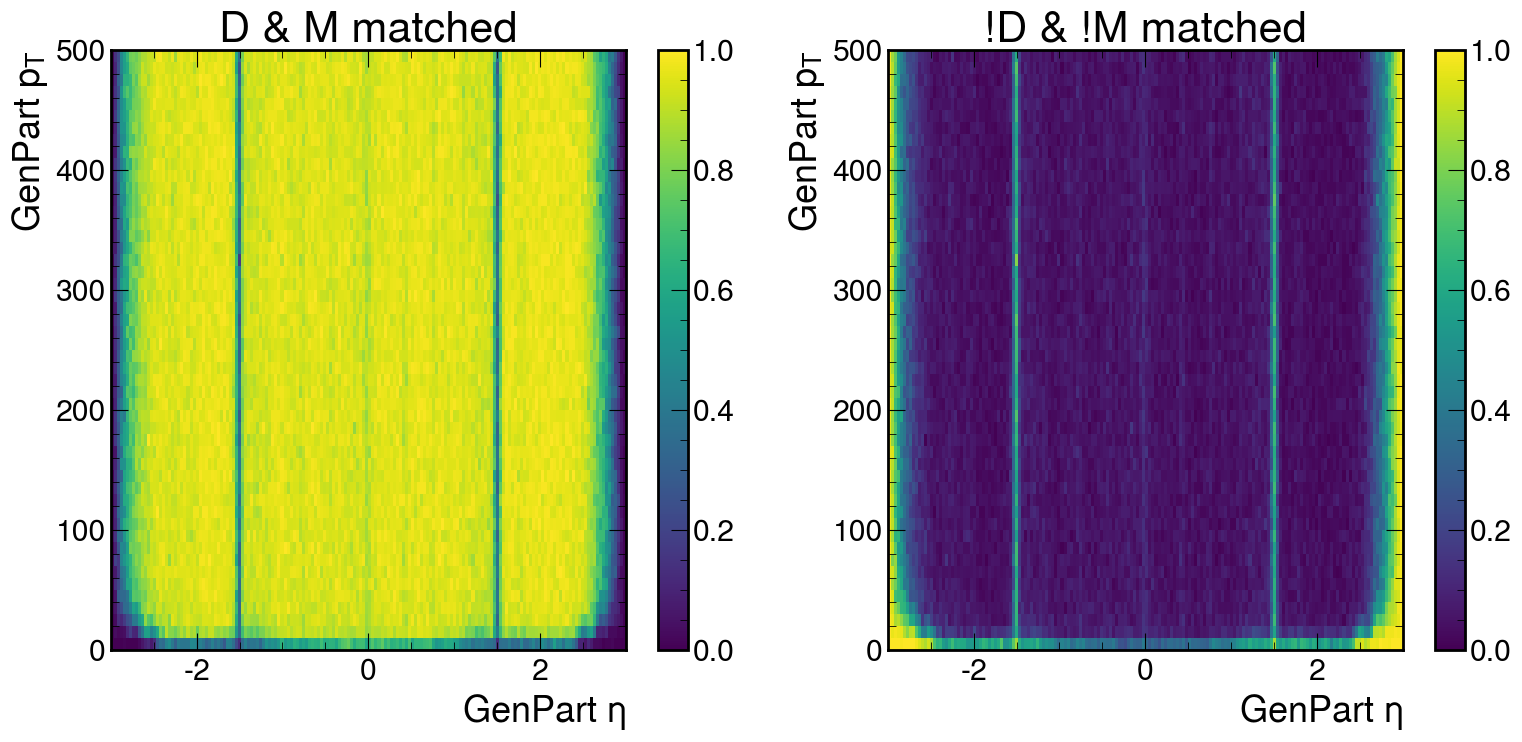

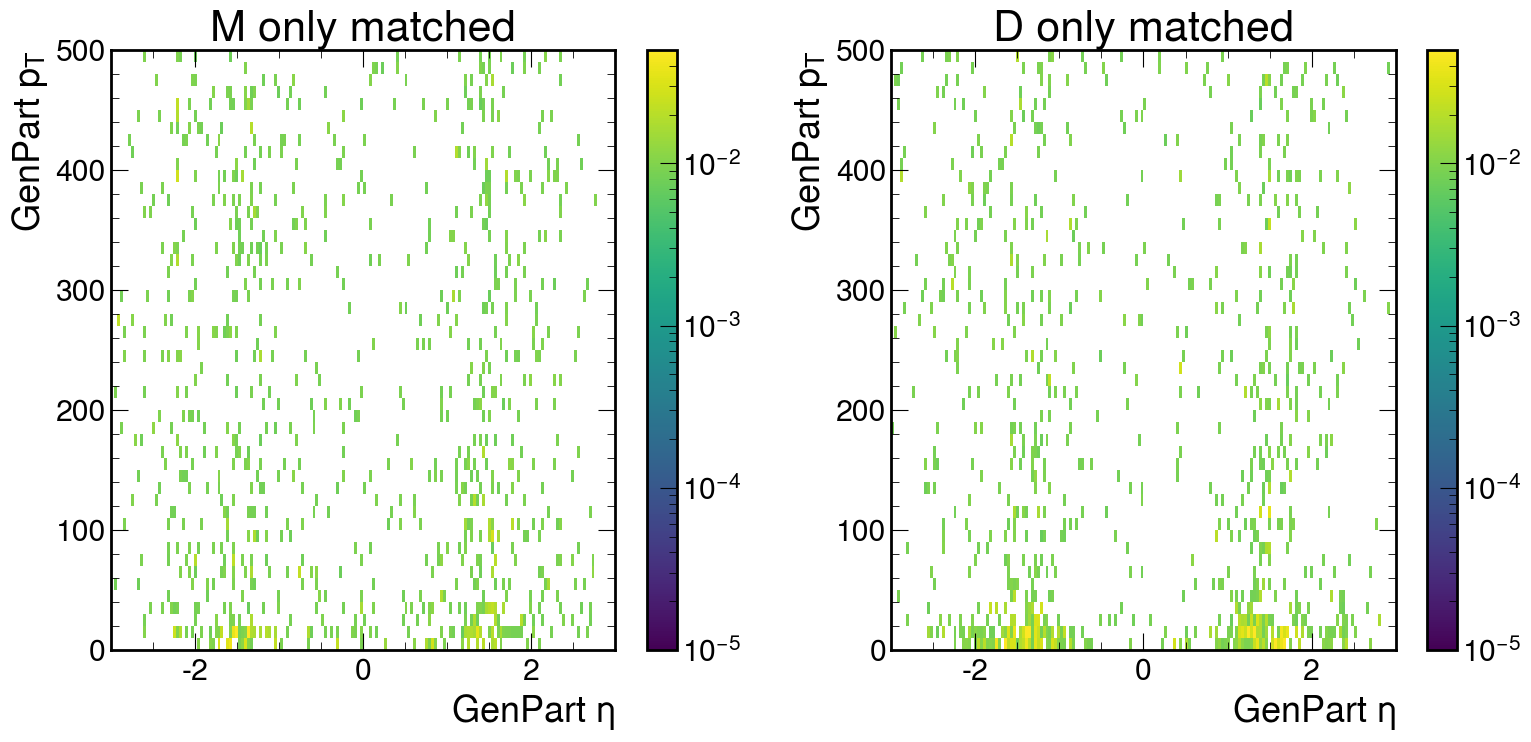

In [80]:
bins = (170, 50)
rrange = ((-3,3),(0,500))
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)],
                                            dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)],
                                             dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)], 
                                            dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
                                                  dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
             bins=bins, range=rrange )



N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,)

ax1.set_xlabel("GenPart $\eta$")
ax2.set_xlabel("GenPart $\eta$")
ax1.set_ylabel("GenPart $p_T$")
ax2.set_ylabel("GenPart $p_T$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_xlabel("GenPart $\eta$")
ax4.set_xlabel("GenPart $\eta$")

ax3.set_ylabel("GenPart $p_T$")
ax4.set_ylabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_2.pdf")

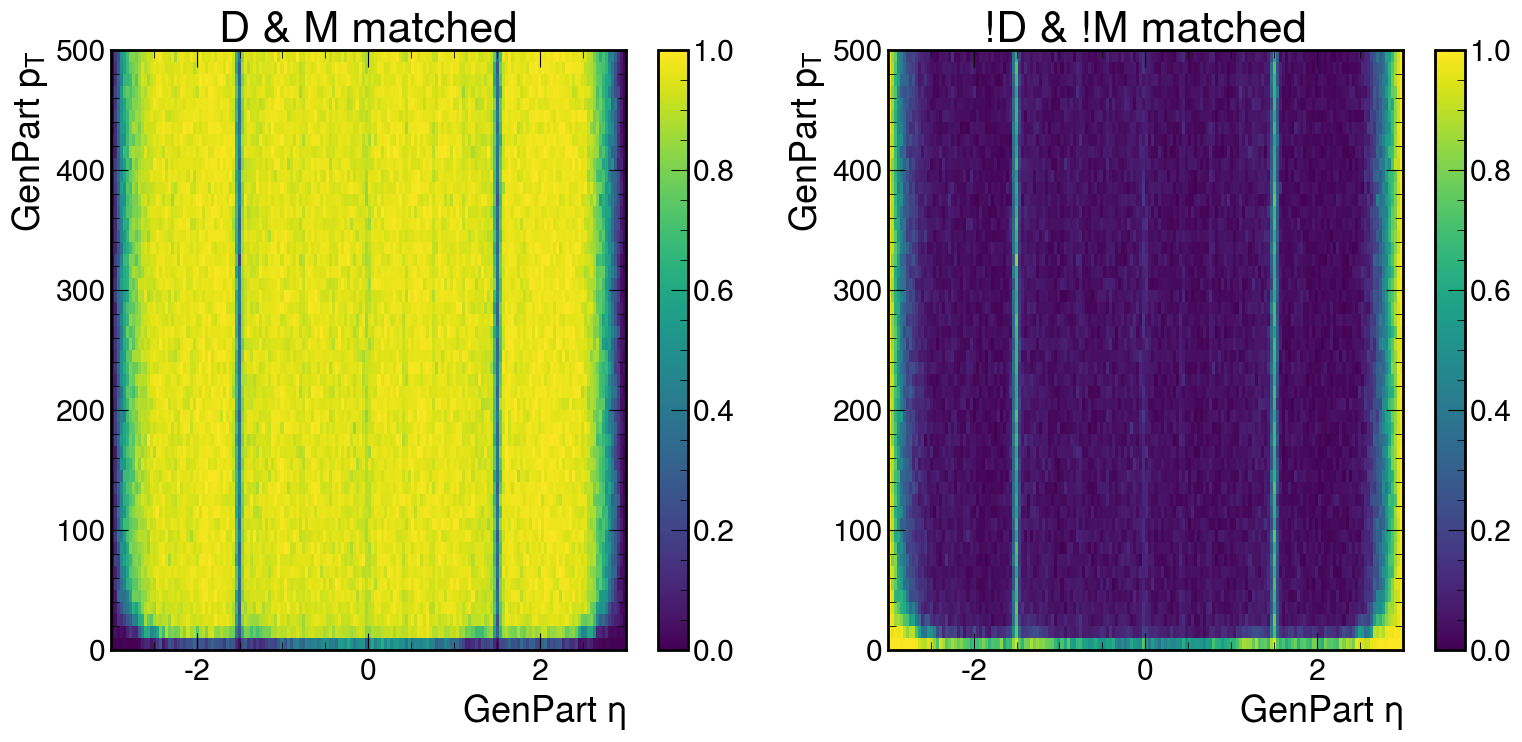

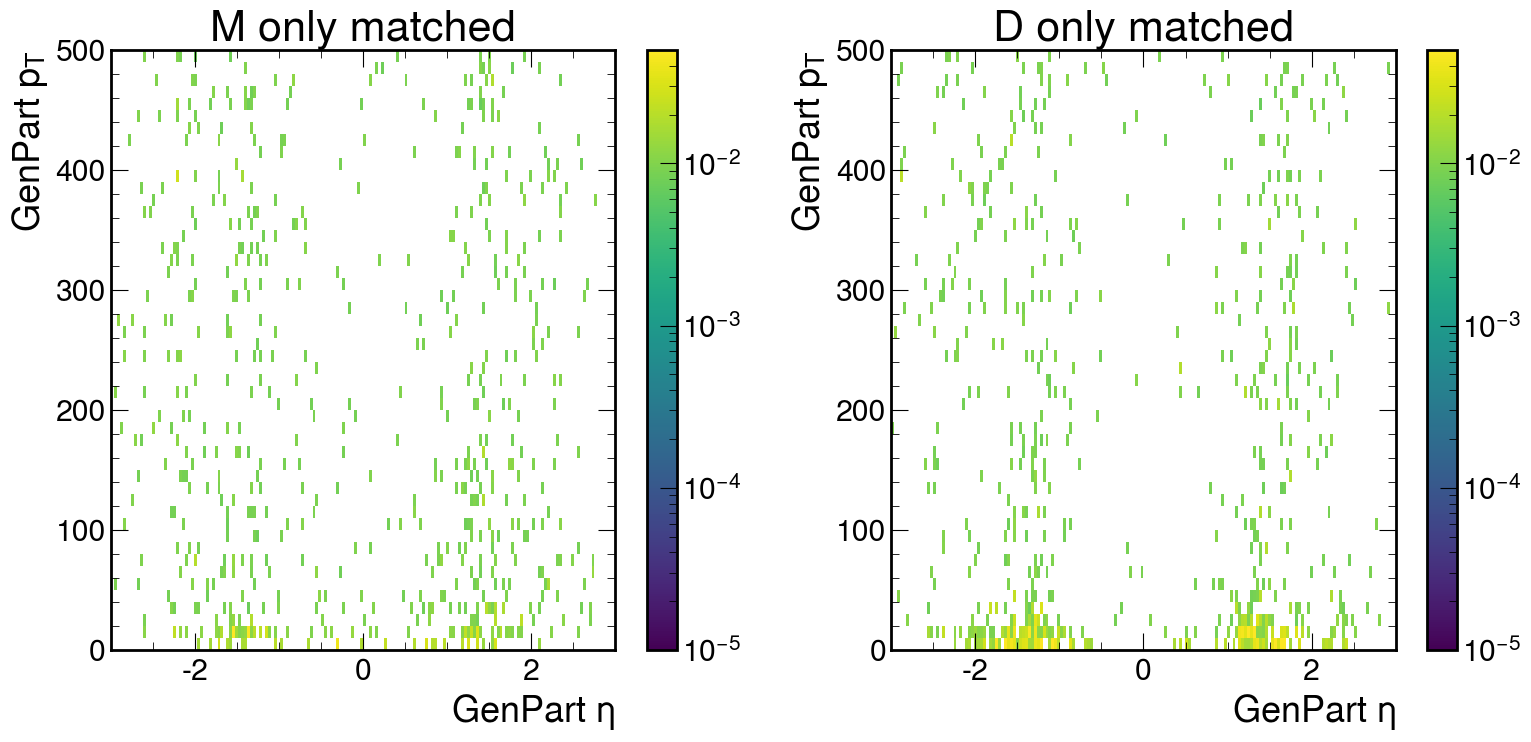

In [81]:
bins = (170, 50)
rrange = ((-3,3),(0,500))
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
                                            dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
                                             dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)], 
                                            dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)], 
                                                  dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)], 
             bins=bins, range=rrange )



N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,)

ax1.set_xlabel("GenPart $\eta$")
ax2.set_xlabel("GenPart $\eta$")
ax1.set_ylabel("GenPart $p_T$")
ax2.set_ylabel("GenPart $p_T$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_onlyEcalDriven_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_onlyEcalDriven_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_xlabel("GenPart $\eta$")
ax4.set_xlabel("GenPart $\eta$")

ax3.set_ylabel("GenPart $p_T$")
ax4.set_ylabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_onlyEcalDriven_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_onlyEcalDriven_2.pdf")

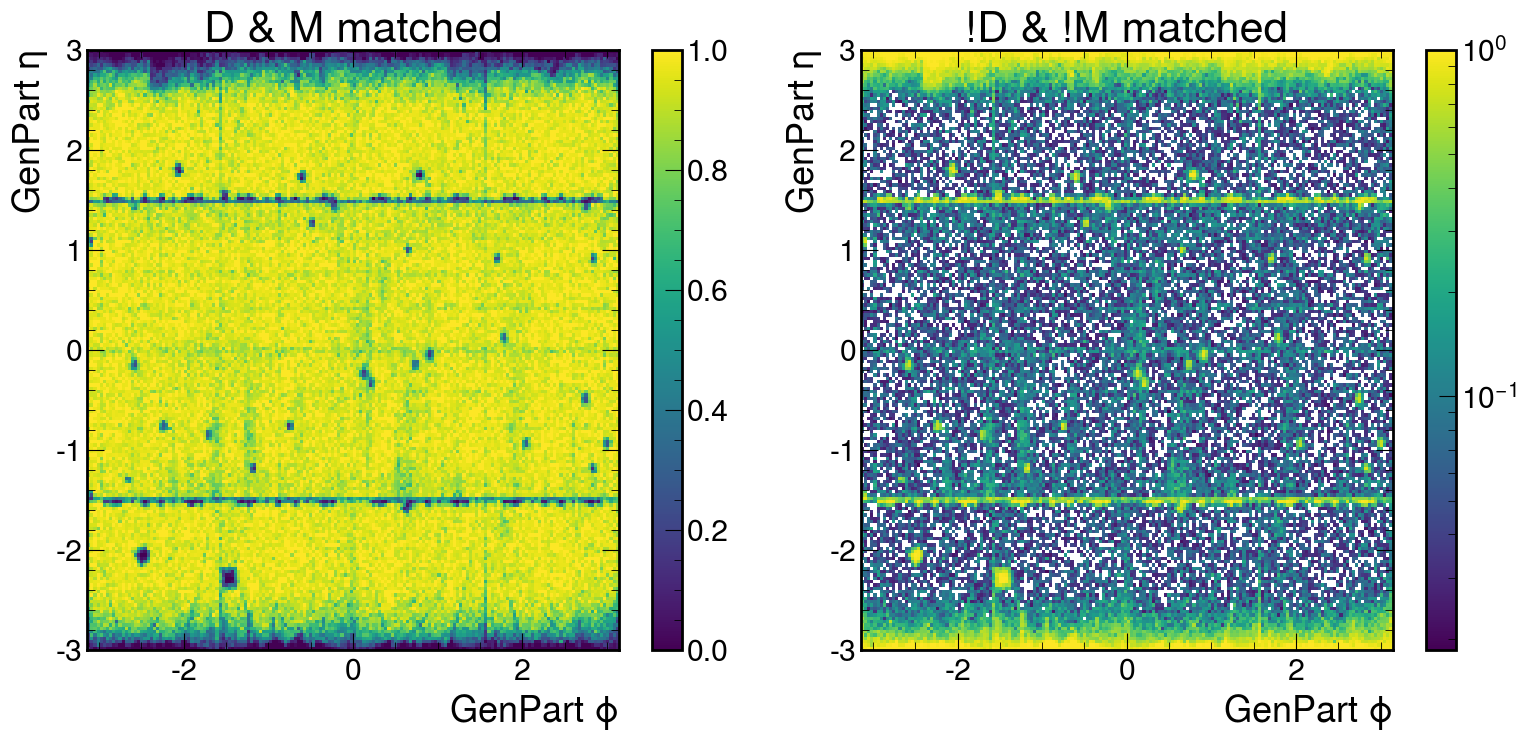

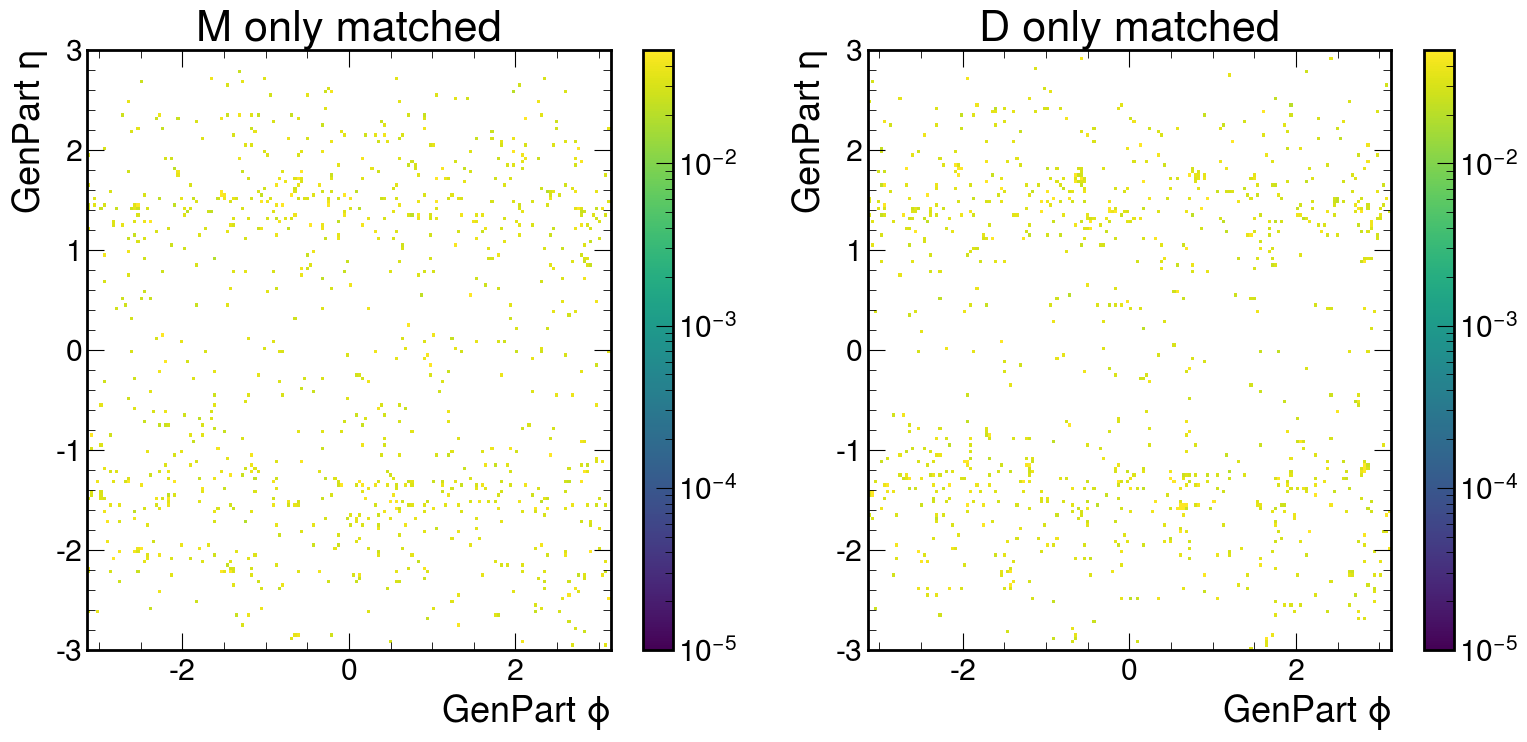

In [82]:
bins = (170, 180)
rrange = ((-np.pi, np.pi),(-3,3))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)],
                                            dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)],
                                             dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)], 
                                            dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
                                                  dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
             bins=bins, range=rrange )


N_tot, _, _ = np.histogram2d(dfj["genpart_phi_M"], dfj["genpart_eta_M"], 
             bins=bins, range=rrange )

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T, norm=LogNorm( ))

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_ylabel("GenPart $\eta$")
ax4.set_ylabel("GenPart $\eta$")
ax3.set_xlabel("GenPart $\phi$")
ax4.set_xlabel("GenPart $\phi$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_2.pdf")

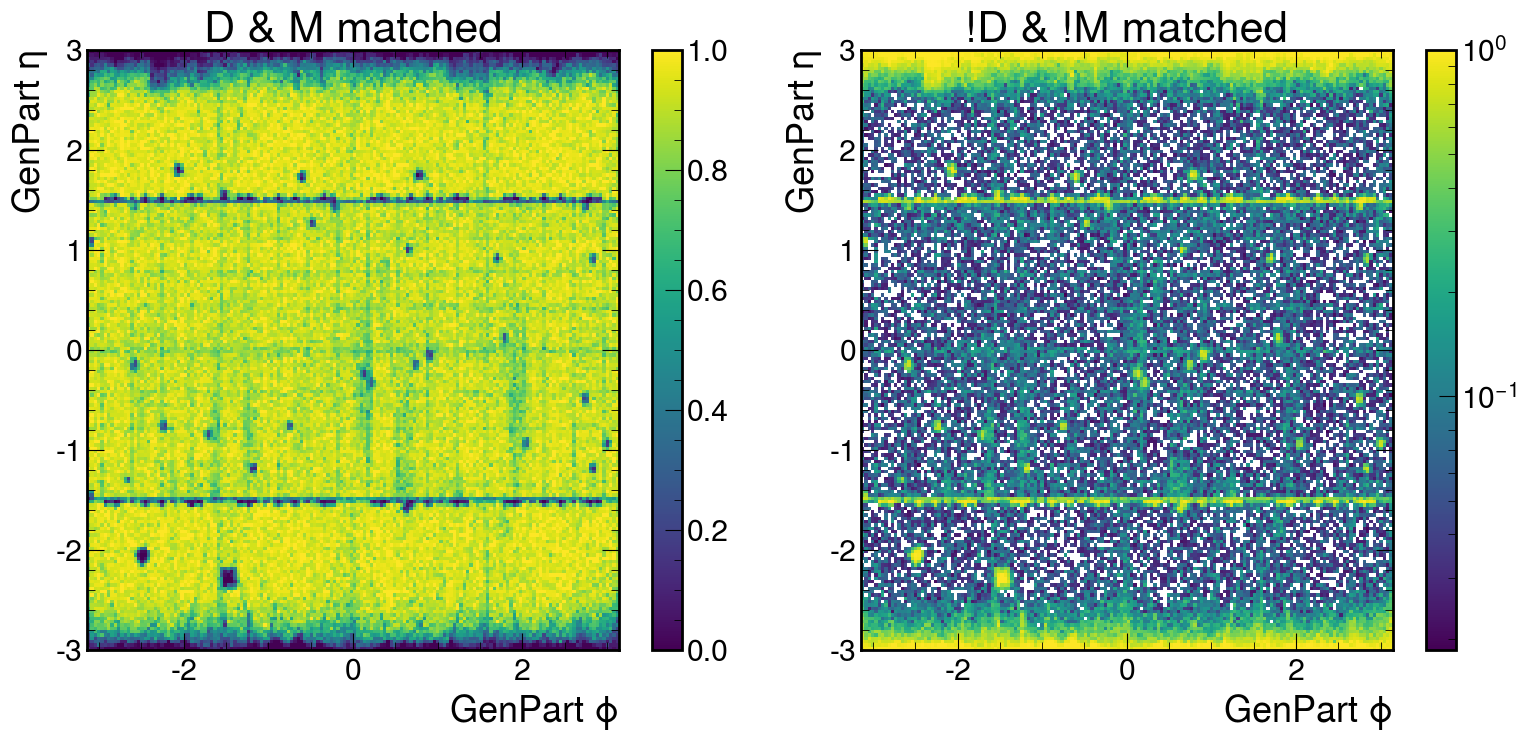

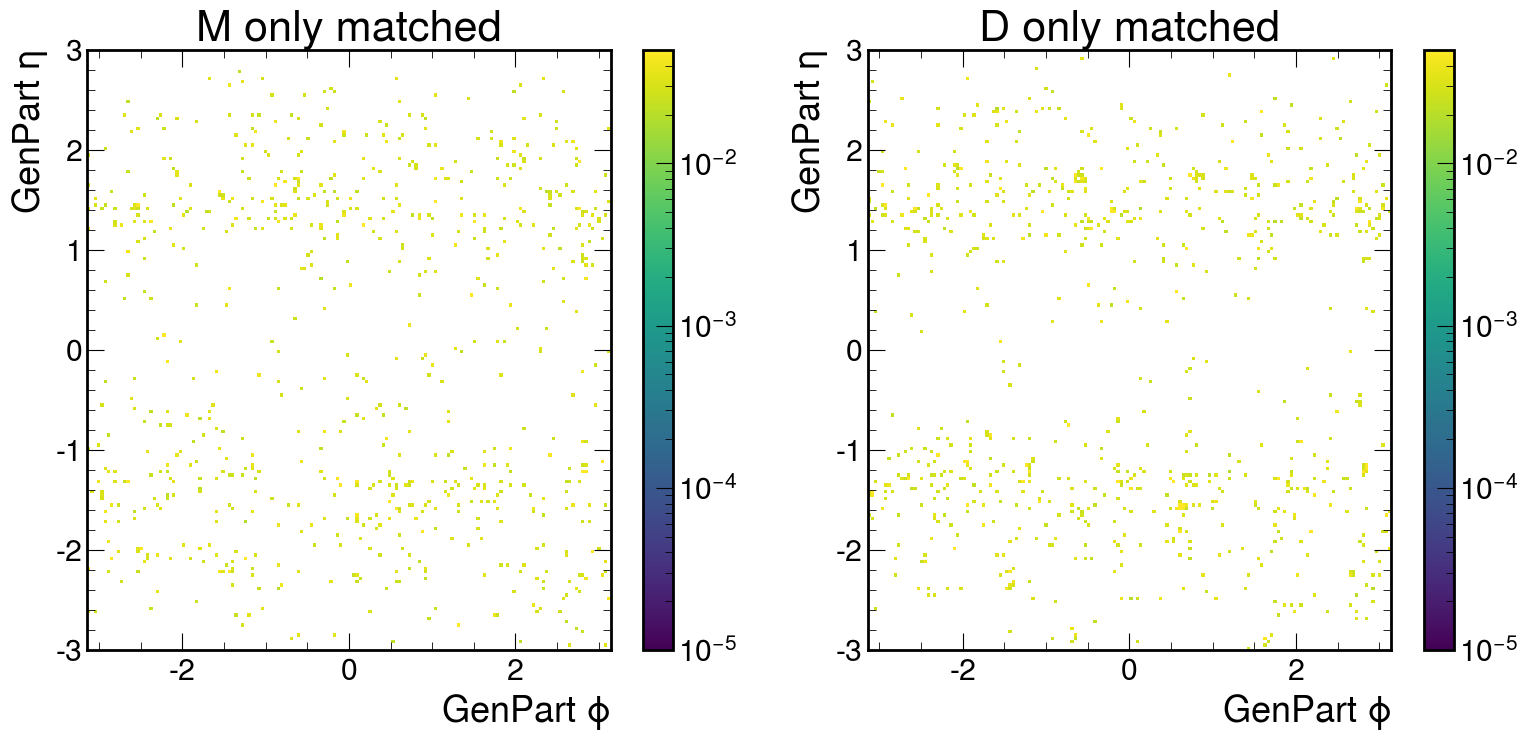

In [83]:
bins = (160, 180)
rrange = ((-np.pi, np.pi),(-3,3))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
                                            dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)&(dfj.ele_isEcalDriven_D==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_D==1)],
                                             dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_D==1)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)], 
                                            dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
                                                  dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
             bins=bins, range=rrange )



N_tot, _, _ = np.histogram2d(dfj["genpart_phi_M"], dfj["genpart_eta_M"], 
             bins=bins, range=rrange )


X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T, norm=LogNorm( ))

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()


plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_ylabel("GenPart $\eta$")
ax4.set_ylabel("GenPart $\eta$")
ax3.set_xlabel("GenPart $\phi$")
ax4.set_xlabel("GenPart $\phi$")
ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_2.pdf")

/tmp/ipykernel_7187/1674121524.py:28: RuntimeWarning: invalid value encountered in divide
  c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
/tmp/ipykernel_7187/1674121524.py:29: RuntimeWarning: invalid value encountered in divide
  c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T, norm=LogNorm( ))
/tmp/ipykernel_7187/1674121524.py:46: RuntimeWarning: invalid value encountered in divide
  c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
/tmp/ipykernel_7187/1674121524.py:47: RuntimeWarning: invalid value encountered in divide
  c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))


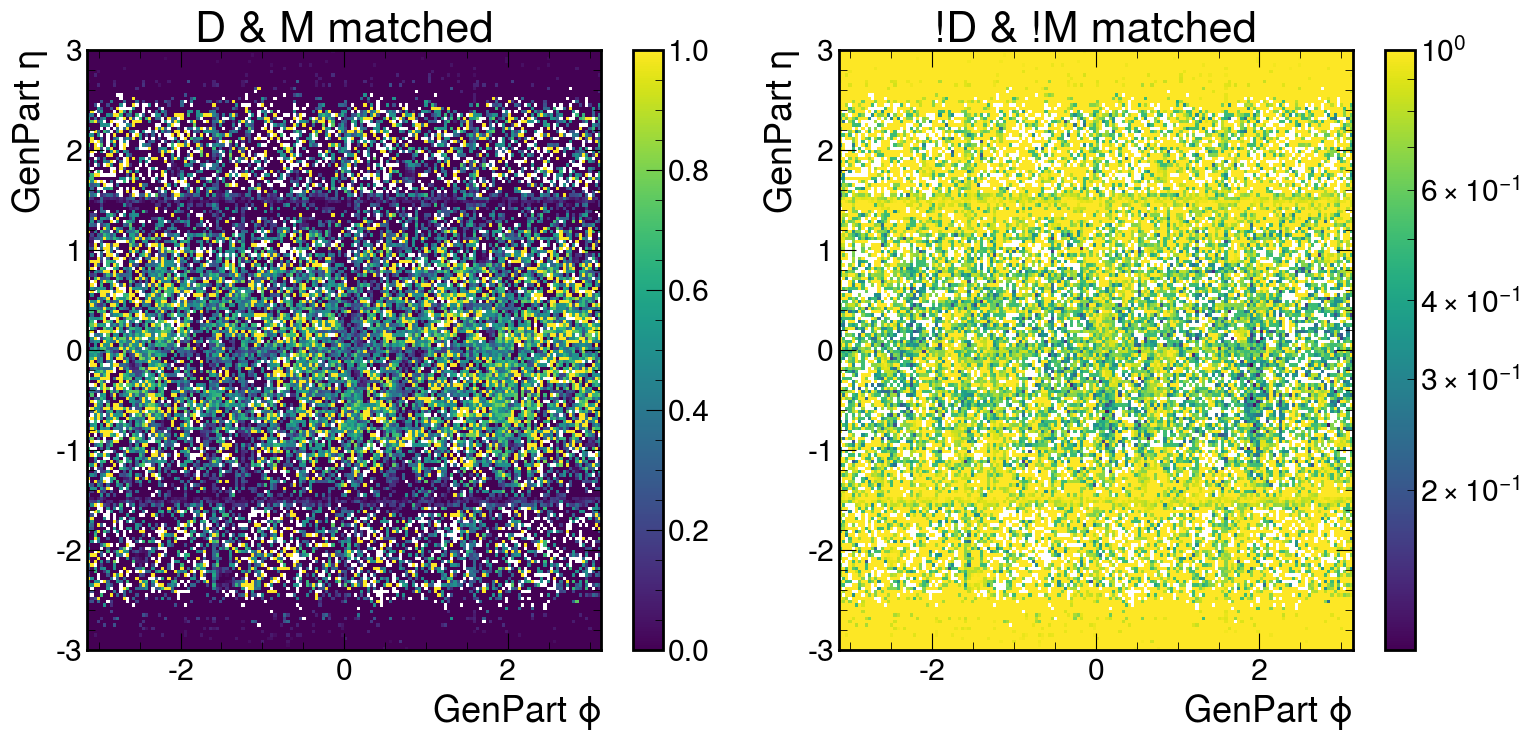

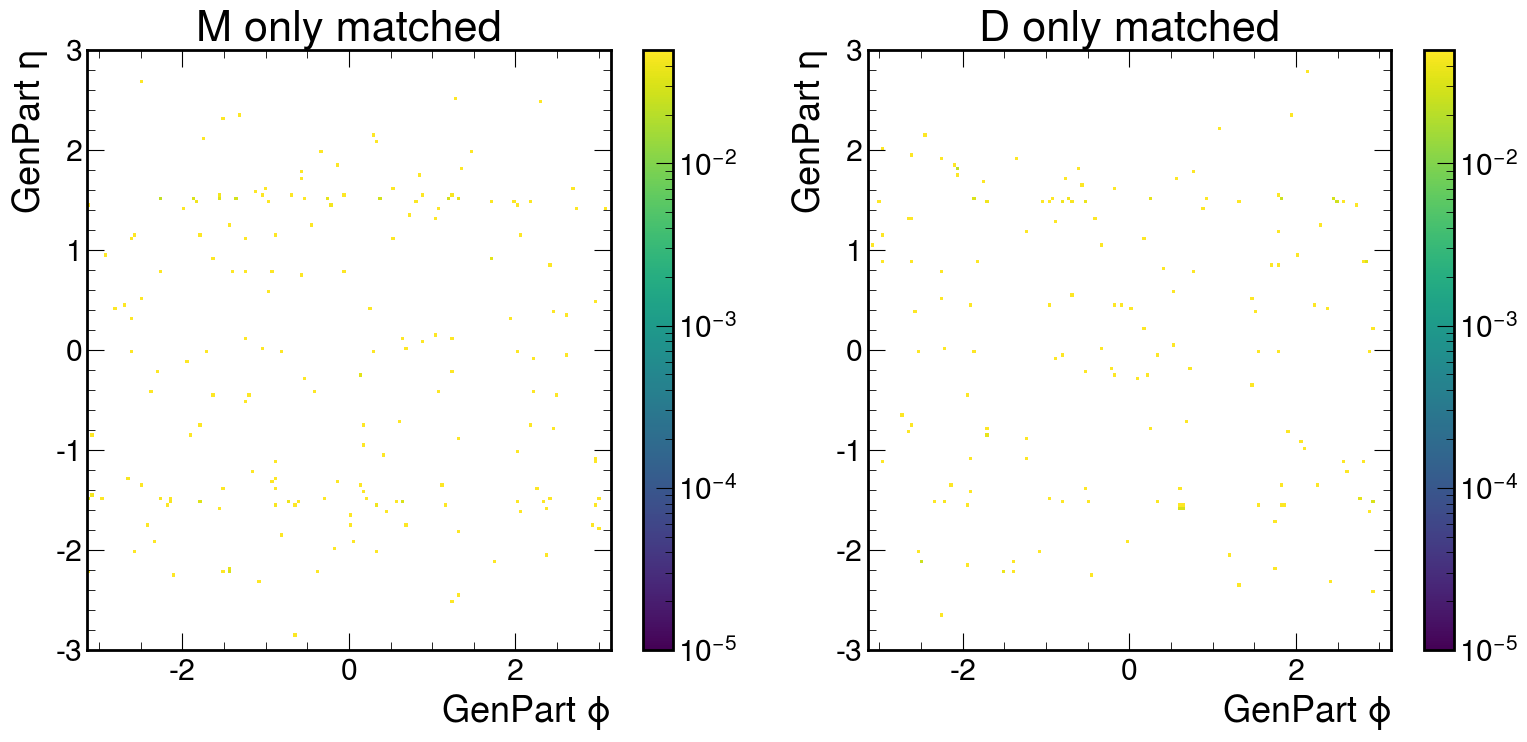

In [84]:
bins = (160, 180)
rrange = ((-np.pi, np.pi),(-3,3))
df_join = dfj
N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)&(dfj.ele_isEcalDriven_D==0)],
                                            dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)&(dfj.ele_isEcalDriven_D==0)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_phi_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_D==0)],
                                             dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isEcalDriven_D==0)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)], 
                                            dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isEcalDriven_M==0)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_phi_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
                                                  dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
             bins=bins, range=rrange )



N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T, norm=LogNorm( ))

ax1.set_ylabel("GenPart $\eta$")
ax2.set_ylabel("GenPart $\eta$")
ax1.set_xlabel("GenPart $\phi$")
ax2.set_xlabel("GenPart $\phi$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()


plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_ylabel("GenPart $\eta$")
ax4.set_ylabel("GenPart $\eta$")
ax3.set_xlabel("GenPart $\phi$")
ax4.set_xlabel("GenPart $\phi$")
ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etaphi_onlyEcalDriven_2.pdf")

### Tracker driven

In [58]:
dfj.ele_isTrackerDriven_D

0          False
1           True
2           -999
3           True
4           True
           ...  
2163899    False
2163900     True
2163901     True
2163902     True
2163903    False
Name: ele_isTrackerDriven_D, Length: 2163904, dtype: object

In [68]:
(dfj.ele_isEcalDriven_M==1)

0          False
1          False
2          False
3          False
4          False
           ...  
2163899    False
2163900    False
2163901    False
2163902    False
2163903    False
Name: ele_isEcalDriven_M, Length: 2163904, dtype: bool

In [64]:
dfj.elematched_D = dfj.deltaR_genPart_ele_D<0.4
dfj.elematched_M = dfj.deltaR_genPart_ele_M<0.4

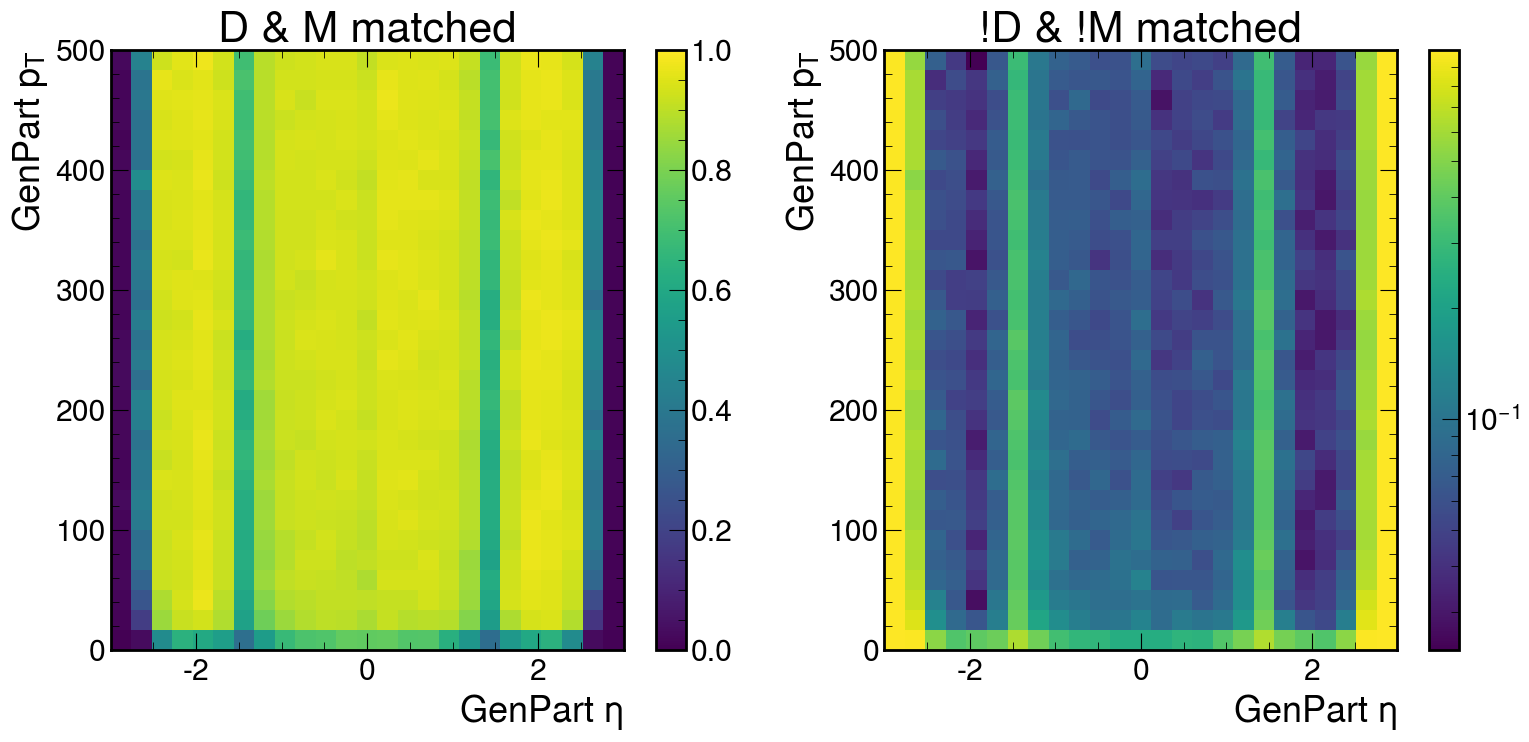

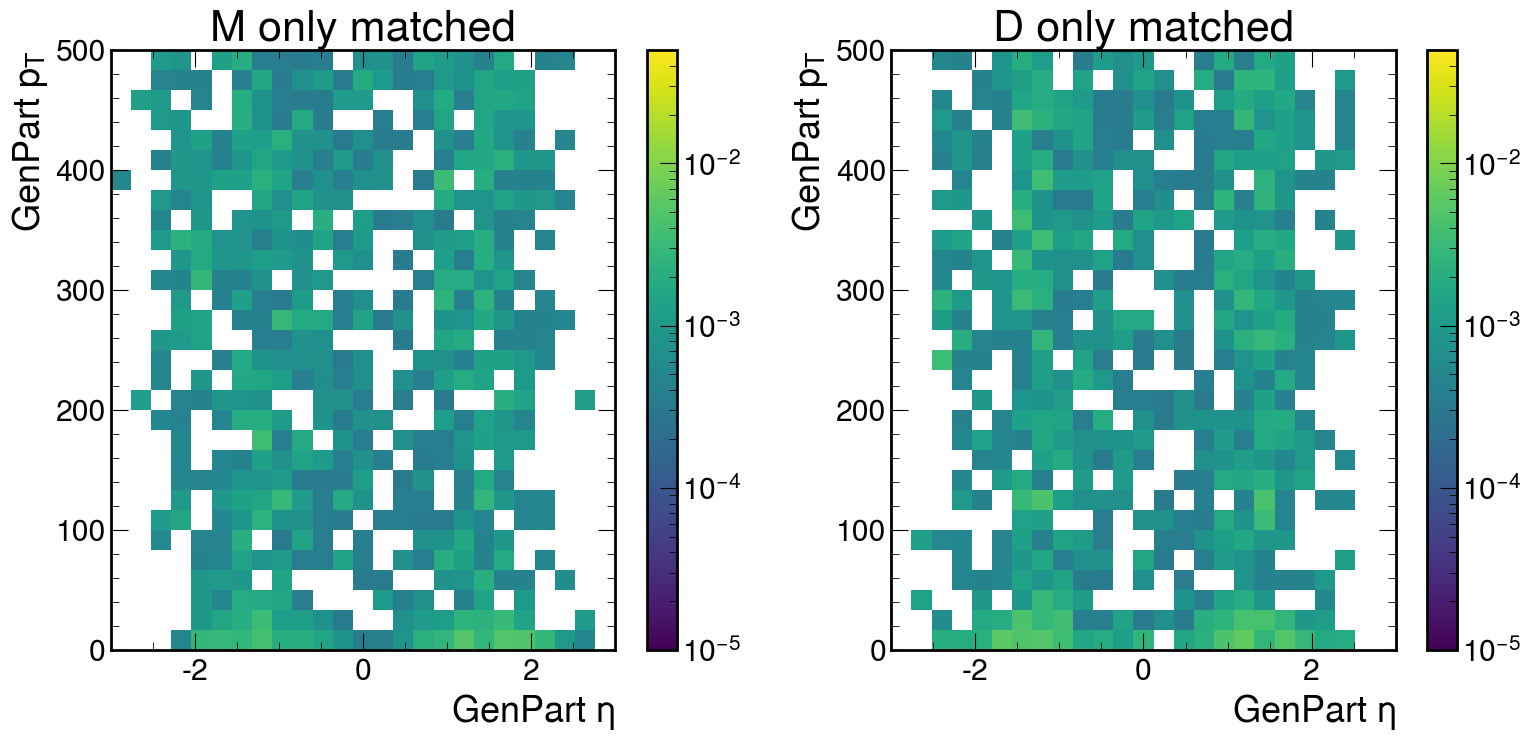

In [66]:
bins = (25, 30)
rrange = ((-3,3),(0,500))


N_matched_both_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isTrackerDriven_M==1)],
                                            dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==1)&(dfj.ele_isTrackerDriven_M==1)],
               bins=bins, range=rrange )

N_matched_Donly_pteta, _, _ = np.histogram2d(dfj["genpart_eta_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isTrackerDriven_D==1)],
                                             dfj["genpart_pt_D"][(dfj.elematched_D==1)&(dfj.elematched_M==0)&(dfj.ele_isTrackerDriven_D==1)],
            bins=bins, range=rrange  )

N_matched_Monly_pteta, _, _= np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isTrackerDriven_M==1)], 
                                            dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==1)&(dfj.ele_isTrackerDriven_M==1)], 
            bins=bins, range=rrange )

N_notmatched_pteta, xbins, ybins = np.histogram2d(dfj["genpart_eta_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
                                                  dfj["genpart_pt_M"][(dfj.elematched_D==0)&(dfj.elematched_M==0)], 
             bins=bins, range=rrange )


N_tot = N_matched_both_pteta + N_matched_Donly_pteta + N_matched_Monly_pteta + N_notmatched_pteta

X, Y = np.meshgrid(xbins, ybins)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

c1 = ax1.pcolormesh(X,Y, (N_matched_both_pteta/N_tot).T, vmax=1, vmin=0)
c2 = ax2.pcolormesh(X,Y, (N_notmatched_pteta/N_tot).T,  norm=LogNorm())

ax1.set_xlabel("GenPart $\eta$")
ax2.set_xlabel("GenPart $\eta$")
ax1.set_ylabel("GenPart $p_T$")
ax2.set_ylabel("GenPart $p_T$")
ax1.set_title("D & M matched")
ax2.set_title("!D & !M matched")
plt.colorbar(c1, ax=ax1)
plt.colorbar(c2, ax=ax2)
plt.tight_layout()

plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_1.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_1.pdf")

fig2, (ax3,ax4) = plt.subplots(1,2, figsize=(16,8))
c3 = ax3.pcolormesh(X,Y, (N_matched_Monly_pteta/N_tot).T,  norm=LogNorm(vmax=0.05, vmin=1e-5,))
c4 = ax4.pcolormesh(X,Y, (N_matched_Donly_pteta/N_tot).T, norm=LogNorm( vmax=0.05, vmin=1e-5,))

ax3.set_xlabel("GenPart $\eta$")
ax4.set_xlabel("GenPart $\eta$")

ax3.set_ylabel("GenPart $p_T$")
ax4.set_ylabel("GenPart $p_T$")

ax3.set_title("M only matched")
ax4.set_title("D only matched")

plt.colorbar(c3, ax=ax3)
plt.colorbar(c4, ax=ax4)
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_2.png")
plt.savefig(f"{output_folder}/Matched_genparticle_ele_etapt_2.pdf")

### Checking the SuperCluster when there is not matching of the patElectron

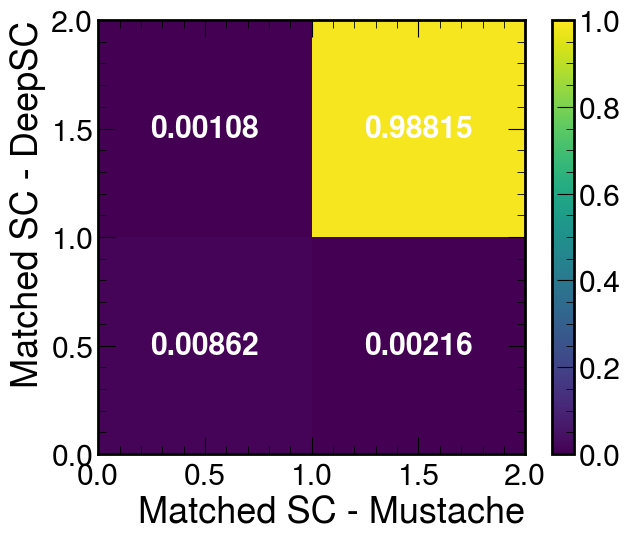

In [85]:
mask_onlyM = (dfj.elematched_D==0)&(dfj.elematched_M==1)

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d(dfj[mask_onlyM].sc_matched_M, dfj[mask_onlyM].sc_matched_D,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched SC - Mustache")
ax.set_ylabel("Matched SC - DeepSC")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_SC_withonlyMustachePatElectronMatched.png")
plt.savefig(f"{output_folder}/Matched_SC_withonlyMustachePatElectronMatched.pdf")

In [ ]:
mask_onlyM = (df_join.elematched_D==0)&(df_join.elematched_M==1)

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

hist, xbins, ybins = np.histogram2d(dfj[mask_onlyM].sc_matched_M, dfj[mask_onlyM].sc_matched_D,
                                     range=((0,2),(0,2)), bins=(2,2), density=True)

X, Y = np.meshgrid(xbins, ybins)
C = ax.pcolormesh(X,Y, hist.T, vmax=1, vmin=0)

for i in range(2):
    for j in range(2):
        ax.text(xbins[j]+0.5,ybins[i]+0.5, "{:.5f}".format(hist.T[i,j]), 
                color="w", ha="center", va="center", fontweight="bold", fontsize="small")

fig.colorbar(C,ax=ax)
ax.set_xlabel("Matched SC - Mustache")
ax.set_ylabel("Matched SC - DeepSC")
plt.tight_layout()
plt.savefig(f"{output_folder}/Matched_SC_withonlyMustachePatElectronMatched.png")
plt.savefig(f"{output_folder}/Matched_SC_withonlyMustachePatElectronMatched.pdf")

# Comparison of the SC and seed position

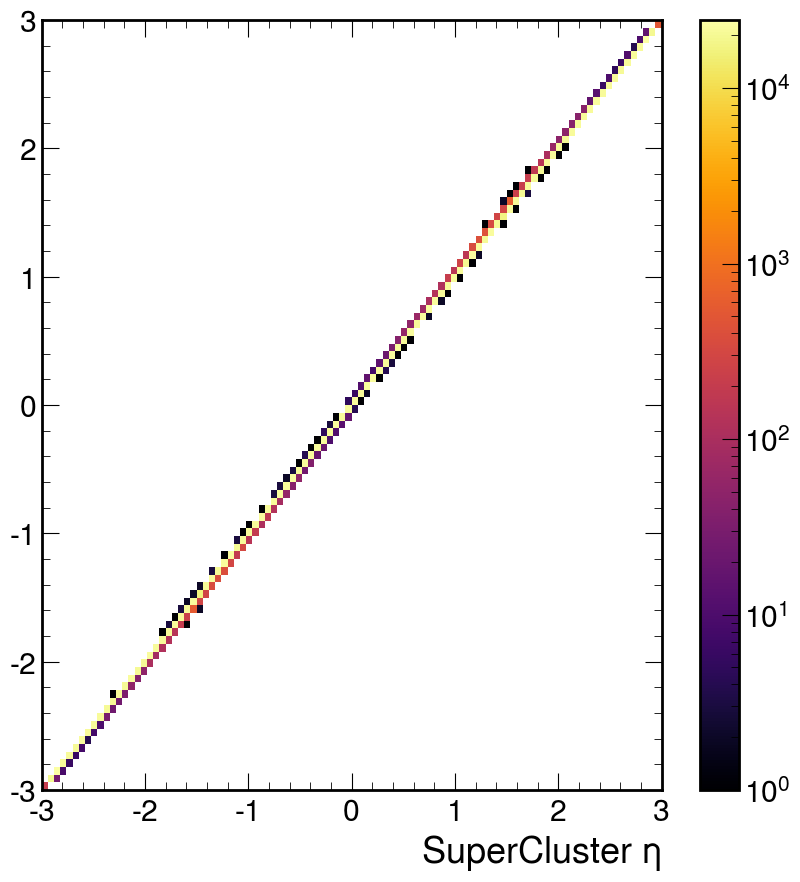

In [53]:
plt.hist2d(dfj.seed_eta_D, 
          dfj.sc_eta_D, 
           bins=100,
          range=((-3,3),(-3,3)),
          norm=LogNorm(), cmap="inferno");
plt.xlabel("Seed $\eta$")
plt.xlabel("SuperCluster $\eta$")
plt.colorbar()
plt.savefig(f"{output_folder}/seed_eta_SC_eta_comparison.png")
plt.savefig(f"{output_folder}/seed_eta_SC_eta_comparison.pdf")

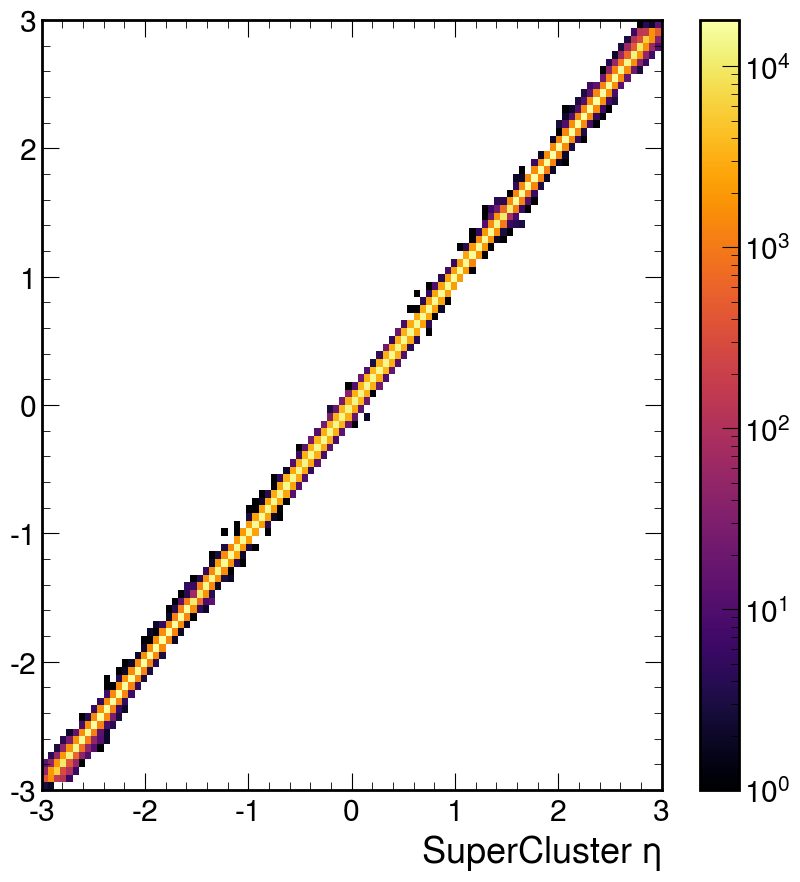

In [52]:
plt.hist2d(dfj.ele_eta_D, 
          dfj.sc_eta_D, 
           bins=100,
          range=((-3,3),(-3,3)),
          norm=LogNorm(), cmap="inferno");
plt.xlabel("Seed $\eta$")
plt.xlabel("SuperCluster $\eta$")
plt.colorbar()
plt.savefig(f"{output_folder}/seed_eta_ele_eta_comparison.png")
plt.savefig(f"{output_folder}/seed_eta_ele_eta_comparison.pdf")

# Analysis of not matched events

In [36]:
(dfj.elematched_D==0)&(dfj.elematched_M==1)

0          False
1          False
2          False
3          False
4          False
           ...  
2163899    False
2163900    False
2163901    False
2163902    False
2163903    False
Length: 2163904, dtype: bool

In [37]:
only_M_ele = (dfj.elematched_D==0)&(dfj.elematched_M==1)
runIDs = list(map(str, dfj[only_M_ele].runId ))
eventId = list(map(int, dfj[only_M_ele].eventId ))

In [43]:
input_folder_deep = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/FourElectronsGunPt1-500_pythia8_PremixRun3PU40_13p6TeV_130X_mcRun3_2022_realistic_v2_235fbNoiseECAL_DeepSC_AlgoA_pfRechitThres_34sigma_235fb_SCAndEleRegression_Dumper/Fix_DeepSCAlgoA_thres235/230311_175745/"
input_folder_must = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/FourElectronsGunPt1-500_pythia8_PremixRun3PU40_13p6TeV_130X_mcRun3_2022_realistic_v2_235fbNoiseECAL_Mustache_pfRechitThres_34sigma_235fb_SCAndEleRegression_Dumper/230307_165449"

non_matching_deepsc = []
for r, ev in zip(runIDs,eventId) :
    file_must = f"{input_folder_must}/000{int(float(r)//1000)}/output_{r[:-2]}.root"
    file_deep = f"{input_folder_deep}/000{int(float(r)//1000)}/output_{r[:-2]}.root"
    non_matching_deepsc.append((file_must, file_deep, ev, f"{int(float(r)//1000)}_output_{r[:-2]}_ev"))
    #print(f"event:{ev} , file={file}")

In [44]:
def get_event(ev, files):
    tree_nomatch_M = uproot.lazy(f"{files[ev][0]}:recosimdumper/caloTree", num_workers=3)
    tree_nomatch_D = uproot.lazy(f"{files[ev][1]}:recosimdumper/caloTree", num_workers=3)

    ev_M = tree_nomatch_M[tree_nomatch_M.eventId == files[ev][2]]
    ev_D = tree_nomatch_D[tree_nomatch_D.eventId == files[ev][2]]

    gen_mask_ele = (ev_D.genParticle_status==1)&(abs(ev_D.genParticle_pdgId)==11)&(ev_D.genParticle_statusFlag&1==1)

    genpart = ak.zip(dict(
        pt = ev_D.genParticle_pt[gen_mask_ele],
        eta = ev_D.genParticle_eta[gen_mask_ele],
        phi = ev_D.genParticle_phi[gen_mask_ele])
    )

    ele_M= ak.zip(dict(
        pt = ev_M.patElectron_energy / np.cosh(ev_M.patElectron_eta),
        eta = ev_M.patElectron_eta,
        phi = ev_M.patElectron_phi,
        ecalDriven = ev_M.patElectron_isEcalDriven),

    )

    sc_M = ak.zip(dict(
        pt = ev_M.superCluster_energy / np.cosh(ev_M.superCluster_eta),
        eta = ev_M.superCluster_eta,
        phi = ev_M.superCluster_phi,
        seed_eta = ev_M.pfCluster_eta[ev_M.superCluster_seedIndex],
        seed_phi = ev_M.pfCluster_phi[ev_M.superCluster_seedIndex])
    )

    cl_M = ak.zip(dict(
        pt = ev_M.pfCluster_energy / np.cosh(ev_M.pfCluster_eta),
        eta = ev_M.pfCluster_eta,
        phi = ev_M.pfCluster_phi)
    )

    ele_D = ak.zip(dict(
        pt = ev_D.patElectron_energy / np.cosh(ev_D.patElectron_eta),
        eta = ev_D.patElectron_eta,
        phi = ev_D.patElectron_phi,
        ecalDriven = ev_D.patElectron_isEcalDriven)
    )

    sc_D = ak.zip(dict(
        pt = ev_D.superCluster_energy / np.cosh(ev_D.superCluster_eta),
        eta = ev_D.superCluster_eta,
        phi = ev_D.superCluster_phi,
        seed_eta = ev_D.pfCluster_eta[ev_D.superCluster_seedIndex],
        seed_phi = ev_D.pfCluster_phi[ev_D.superCluster_seedIndex])
    )

    cl_D = ak.zip(dict(
        pt = ev_D.pfCluster_energy / np.cosh(ev_D.pfCluster_eta),
        eta = ev_D.pfCluster_eta,
        phi = ev_D.pfCluster_phi)
    )


    return genpart, ele_M, ele_D, sc_M, sc_D, cl_M, cl_D

In [45]:
os.makedirs(output_folder+"/not_matched_events/", exist_ok=True)

for iev in range(200):
    try:
        genpart, ele_M, ele_D, sc_M, sc_D, cl_M, cl_D = get_event(iev,non_matching_deepsc)
    except:
        continue
    fig = plt.figure(figsize=(8,8), dpi=100)

    plt.scatter(cl_M.eta, cl_M.phi, s=cl_M.pt, marker="^", alpha=0.8,  c="blue", label="PFClusters")
    plt.scatter(sc_M.seed_eta, sc_M.seed_phi, s=sc_M.pt, c="r", edgecolors="none", alpha=0.5, label="Mustache")
    plt.scatter(sc_D.seed_eta, sc_D.seed_phi, s=sc_D.pt, edgecolors="green", facecolor="none",  alpha=0.8, label="DeepSC (seed pos.)")
    plt.scatter(sc_D.eta, sc_D.phi, s=sc_D.pt, c="green",edgecolors="none",  alpha=0.5, label="DeepSC")

    plt.scatter(ele_M.eta[~ele_M.ecalDriven], ele_M.phi[~ele_M.ecalDriven], marker="1",s=120, c="orange", label="Ele Mustache (Trk)")
    plt.scatter(ele_D.eta[~ele_D.ecalDriven], ele_D.phi[~ele_D.ecalDriven], marker="2",s=120, c="blueviolet", label="Ele DeepSC (Trk)")
    plt.scatter(ele_M.eta[ele_M.ecalDriven], ele_M.phi[ele_M.ecalDriven], marker="x",s=120, c="orange", label="Ele Mustache (Ecal)")
    plt.scatter(ele_D.eta[ele_D.ecalDriven], ele_D.phi[ele_D.ecalDriven], marker="+",s=120, c="blueviolet", label="Ele DeepSC (Ecal)")
    plt.scatter(genpart.eta, genpart.phi, marker="*",s=80, alpha=0.6, c="yellow",edgecolors="none", label="Gen Ele")
    plt.legend(fontsize=15)
    plt.xlabel("$\eta$")
    plt.ylabel("$\phi$")
    plt.tight_layout()
    plt.savefig(f"{output_folder}/not_matched_events/{non_matching_deepsc[iev][3]}.pdf")
    plt.savefig(f"{output_folder}/not_matched_events/{non_matching_deepsc[iev][3]}.png")
    plt.close()
    

